<a id="4"></a>
<h1 style="background-color:#ffcc99;font-family:Baloo Da;font-size:200%;text-align:left">US Foods – Daily Delivery Service Analytics </h1>

**US Foods** is a national food distributor that services restaurants and other operators that provide food service. Although most customers typically receive deliveries twice a week, US Foods currently offers a daily delivery service to some of our operators as part of an enhanced service strategy. We believe that there’s opportunity to offer this service to a broader group to help get the restaurant supplies they need precisely when they need it, so they can provide their customers with the best dining experience and more effectively manage their inventory. 

**Problem:** However, this enhanced service comes at an increased cost to serve. So, to better understand which operators would benefit the most from our daily delivery service, market research was conducted with a randomized set of customers (results attached here). 

**Objective:** To determine which customer is best to target for this selected service offering. 

Note: The dataset does not reflect actual data. Please send both your code (notebook, pdf, pickle file when necessary) and answers to the questions listed below to our hiring recruiter per their guidelines.  

<a id="4"></a>
<h1 style="background-color:#16DCC9;font-family:Baloo Da;font-size:200%;text-align:left">Briefing</h1>

**For Decision Scientists**  

Your business stakeholders are wondering how this data will help us refine our business strategy. Please answer the following questions:   

1.      Based on the survey responses and the transaction data, what customer should we offer the daily delivery service to? And why? Are there customers who should not be eligible for the service? If so, why?  

2.      Develop a visualization tool or output that can be used to support business decisions. What recommendations can you make to the business?  

3.      How would you partner with the broader analytics team (including data scientists) to enhance this analysis?   

**Metrics:** 
- Use AUC-ROC to pick the best model.
- Maximize recall 
- Maximize profit

**Input:** 22 features

**Output:** potential customers for daily dilivering (0,1)
- 1: target customers
- 0: others

**Customer segmentation** will be conducted to categorize customers into meaningful groups (such as "Already on Daily Service," "Potential Customers," and "Competitor's Customers") based on their characteristics and behaviors

**Benchmark**: % of people already on daily delivering.

<h1 style="background-color:#16DCC9;font-family:Calibri;font-size:200%;text-align:left">Proposed Solutions</h1>

I will follow these steps to build a classification model with the provided dataset:

1. Data examination
    - Feature columns; missing values; target label (Customer segmentation)
2. EDA
    - Univariate analysis on numerical columns and categrical columns
    - Multivariate analysis
3. Modelling
    - Pipeline
    - XGBoost, Random Forest, Logistic Regression
    - Feature importance (SHAP)
4. Assignment question answers

<a id="4"></a>
<h1 style="background-color:#16DCC9;font-family:Calibri;font-size:200%;text-align:left">Data Quality</h1>

<a id='Load_Libraries'></a>
<h2 style="color:blue">Load Libraries</h2>

In [718]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
import missingno as msno

# check if missing in these column is MCAR (missing completely at random)
import sys
from scipy import stats
from scipy.stats import ttest_ind

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# to visualize all the columns 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

# Enable inline figure display
%matplotlib inline

<a id='Read_Dataset'></a>
<h2 style="color:blue">Overall of the Datasets</h2>

In [912]:
# Load each sheet into a separate DataFrame
df_survey = pd.read_excel("Survey_Data_Assessment_Final.xlsx", sheet_name="survey_data_assessment", engine='openpyxl')
df_transaction = pd.read_excel("Survey_Data_Assessment_Final.xlsx", sheet_name="transactional_data", engine='openpyxl')

# Merge the two DataFrames based on the 'CUST_NBR' column
df = pd.merge(survey_data, transactional_data, on='CUST_NBR', how='left')

# Save the merged DataFrame to a CSV file
df.to_csv('merged_data.csv', index=False)

In [913]:
print('Size of survey_data data', df_survey.shape)
print('Size of transactional_data data', df_transaction.shape)
print('Size of final data ', df.shape)

Size of survey_data data (4031, 15)
Size of transactional_data data (10224, 8)
Size of final data  (4106, 22)


how='inner' will only include rows where the CUST_NBR exists in both sheets, while how='left' will include all rows from the left DataFrame and fill in NaN values for rows where the CUST_NBR doesn't exist in the right DataFrame.

In [721]:
# Info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4106 entries, 0 to 4105
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CUST_NBR                               4106 non-null   int64  
 1   REPORTED_WKLY_SPEND                    4106 non-null   float64
 2   REPORTED_WKLY_SPEND_USF                4106 non-null   float64
 3   REPORTED_WKLY_SPEND_USF_DAILY_SERVICE  4106 non-null   float64
 4   REPORTED_WKLY_SPEND_COMP               4106 non-null   float64
 5   REPORTED_WKLY_SPEND_COMPETITOR_1       4106 non-null   float64
 6   REPORTED_WKLY_SPEND_OTHER_BLD          4106 non-null   float64
 7   REPORTED_WKLY_SPEND_SPCLTY             4106 non-null   float64
 8   REPORTED_WKLY_SPEND_CC                 4106 non-null   float64
 9   REPORTED_WKLY_SPEND_OTHER              4106 non-null   float64
 10  REPORTED_COP_SPEND                     4106 non-null   float64
 11  REPO

In [914]:
df.head()

CUST_NBR  REPORTED_WKLY_SPEND  REPORTED_WKLY_SPEND_USF  \
0     24682          53874.74544              53731.46154   
1     40724          13023.91865              13023.91865   
2     40724          13023.91865              13023.91865   
3     40724          13023.91865              13023.91865   
4     40724          13023.91865              13023.91865   

   REPORTED_WKLY_SPEND_USF_DAILY_SERVICE  REPORTED_WKLY_SPEND_COMP  \
0                            53803.10349                143.283897   
1                            13023.91865                  0.000000   
2                            13023.91865                  0.000000   
3                            13023.91865                  0.000000   
4                            13023.91865                  0.000000   

   REPORTED_WKLY_SPEND_COMPETITOR_1  REPORTED_WKLY_SPEND_OTHER_BLD  \
0                               0.0                     143.283897   
1                               0.0                       0.000000   
2                               0.0                       0.000000   
3                               0.0                       0.000000   
4                               0.0                       0.000000   

   REPORTED_WKLY_SPEND_SPCLTY  REPORTED_WKLY_SPEND_CC  \
0                         0.0                     0.0   
1                         0.0                     0.0   
2                         0.0                     0.0   
3                         0.0                     0.0   
4                         0.0                     0.0   

   REPORTED_WKLY_SPEND_OTHER  REPORTED_COP_SPEND  REPORTED_PRODUCE_SPEND  \
0                        0.0        32253.205310              107.462923   
1                        0.0         7814.351192             2604.783731   
2                        0.0         6000.000000             2000.000000   
3                        0.0         6000.000000             2000.000000   
4                        0.0            0.000000                0.000000   

   SMALL_QTY_RANK  DEL_FLEX_RANK  CUT_TIME_RANK  DIV_NBR  WKLY_ORDERS  \
0              10              9              4      1.0          3.5   
1               5              1              8      6.0          4.5   
2               8              9              1      6.0          4.5   
3               4              3              7      6.0          4.5   
4               0              0              0      6.0          4.5   

    PERC_EB   MENU_TYP_DESC   PYR_SEG_CD  AVG_WKLY_SALES  AVG_WKLY_CASES  
0  0.163933  MT UNAVAILABLE       Retail    53731.461540      562.846154  
1  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479  
2  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479  
3  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479  
4  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479

### A quick EDA of data with Pandas Profiling

**The pandas-profiling library generates a report having:**
- An overview of the dataset
- Variable properties
- Interaction of variables
- Correlation of variables
- Missing values
- Sample data

In [723]:
# import ydata_profiling

In [724]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, minimal=True)
profile.to_file(output_file="output_min.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [725]:
from IPython.display import IFrame

# specify path to output_min.html file
filepath = "output_min.html"

# display report in the notebook
IFrame(filepath, width=1000, height=400)

### A quick EDA of data with D-Tale


D-Tale is an open-source python auto-visualization library. It is one of the best auto data-visualization libraries. D-Tale helps you to get a detailed EDA of the data. It also has a feature of code export, for every plot or analysis in the report.

The dtale library generates a report having:
- An overview of the dataset
- Custom filters
- Correlation, Charts, and Heatmaps
- Highlight datatypes, missing values, ranges
- Code export

In [373]:
import dtale

In [375]:
dtale.show(df)

2023-09-04 12:55:52,125 - INFO     - Executing shutdown due to inactivity...
2023-09-04 12:55:56,283 - INFO     - Executing shutdown...


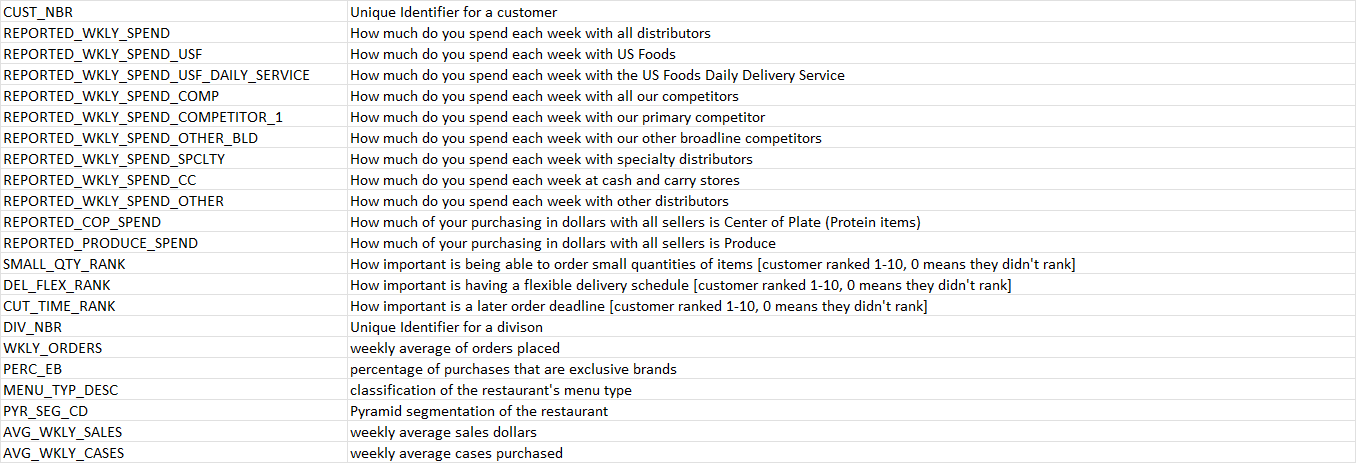

<a id='Data_Quality'></a>
<h2 style="color:blue">Feature Description</h2>

<a id='Data_Quality'></a>
<h3 style="color:blue">Categorical columns</h2>

In [1101]:
# Count nemeric and categorical features
categorical_features = [col for col in df.columns if df[col].dtype == 'object']
numerical_features = [col for col in df.columns if col not in categorical_features]

In [916]:
print('categorical_features : {} \n\
numerical_features : {}'.format(len(categorical_features), len(numerical_features)))

categorical_features : 2 
numerical_features : 20


In [917]:
df.dtypes.value_counts()
df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

float64    16
int64       4
object      2
Name: count, dtype: int64

MENU_TYP_DESC    51
PYR_SEG_CD        9
dtype: int64

In [918]:
df[categorical_features].head()

MENU_TYP_DESC   PYR_SEG_CD
0  MT UNAVAILABLE       Retail
1  MT UNAVAILABLE  Hospitality
2  MT UNAVAILABLE  Hospitality
3  MT UNAVAILABLE  Hospitality
4  MT UNAVAILABLE  Hospitality

<a id='Data_Quality'></a>
<h3 style="color:blue">Numerical columns</h2>

In [919]:
df[numerical_features].head()

CUST_NBR  REPORTED_WKLY_SPEND  REPORTED_WKLY_SPEND_USF  \
0     24682          53874.74544              53731.46154   
1     40724          13023.91865              13023.91865   
2     40724          13023.91865              13023.91865   
3     40724          13023.91865              13023.91865   
4     40724          13023.91865              13023.91865   

   REPORTED_WKLY_SPEND_USF_DAILY_SERVICE  REPORTED_WKLY_SPEND_COMP  \
0                            53803.10349                143.283897   
1                            13023.91865                  0.000000   
2                            13023.91865                  0.000000   
3                            13023.91865                  0.000000   
4                            13023.91865                  0.000000   

   REPORTED_WKLY_SPEND_COMPETITOR_1  REPORTED_WKLY_SPEND_OTHER_BLD  \
0                               0.0                     143.283897   
1                               0.0                       0.000000   
2                               0.0                       0.000000   
3                               0.0                       0.000000   
4                               0.0                       0.000000   

   REPORTED_WKLY_SPEND_SPCLTY  REPORTED_WKLY_SPEND_CC  \
0                         0.0                     0.0   
1                         0.0                     0.0   
2                         0.0                     0.0   
3                         0.0                     0.0   
4                         0.0                     0.0   

   REPORTED_WKLY_SPEND_OTHER  REPORTED_COP_SPEND  REPORTED_PRODUCE_SPEND  \
0                        0.0        32253.205310              107.462923   
1                        0.0         7814.351192             2604.783731   
2                        0.0         6000.000000             2000.000000   
3                        0.0         6000.000000             2000.000000   
4                        0.0            0.000000                0.000000   

   SMALL_QTY_RANK  DEL_FLEX_RANK  CUT_TIME_RANK  DIV_NBR  WKLY_ORDERS  \
0              10              9              4      1.0          3.5   
1               5              1              8      6.0          4.5   
2               8              9              1      6.0          4.5   
3               4              3              7      6.0          4.5   
4               0              0              0      6.0          4.5   

    PERC_EB  AVG_WKLY_SALES  AVG_WKLY_CASES  
0  0.163933    53731.461540      562.846154  
1  0.573987     4031.561051       74.332479  
2  0.573987     4031.561051       74.332479  
3  0.573987     4031.561051       74.332479  
4  0.573987     4031.561051       74.332479

In [920]:
# Distribution of numeric columns
df[numerical_features].describe()

CUST_NBR  REPORTED_WKLY_SPEND  REPORTED_WKLY_SPEND_USF  \
count    4106.000000          4106.000000              4106.000000   
mean    79237.458597          5178.802813              3000.869931   
std     45087.218465         15164.164427              6220.036789   
min       151.000000             0.000000                 0.000000   
25%     39912.250000           637.640096               226.862163   
50%     80014.500000          2244.835000              1133.397500   
75%    118713.000000          5317.202692              3292.414711   
max    155034.000000        508868.053500            122168.236200   

       REPORTED_WKLY_SPEND_USF_DAILY_SERVICE  REPORTED_WKLY_SPEND_COMP  \
count                            4106.000000               4106.000000   
mean                             3413.692069               2177.932882   
std                              6760.838987              13448.376935   
min                                 0.000000                  0.000000   
25%                               353.517524                  0.000000   
50%                              1458.311442                  0.000000   
75%                              3846.720625               1500.000000   
max                            125952.856200             505500.000000   

       REPORTED_WKLY_SPEND_COMPETITOR_1  REPORTED_WKLY_SPEND_OTHER_BLD  \
count                       4106.000000                    4106.000000   
mean                         497.208151                     532.038078   
std                         2799.741443                    4553.534786   
min                            0.000000                       0.000000   
25%                            0.000000                       0.000000   
50%                            0.000000                       0.000000   
75%                            0.000000                       0.000000   
max                       100000.000000                  200000.000000   

       REPORTED_WKLY_SPEND_SPCLTY  REPORTED_WKLY_SPEND_CC  \
count                 4106.000000             4106.000000   
mean                   503.367939               93.449918   
std                   8236.870763              583.280950   
min                      0.000000                0.000000   
25%                      0.000000                0.000000   
50%                      0.000000                0.000000   
75%                      0.000000                0.000000   
max                 500000.000000            25000.000000   

       REPORTED_WKLY_SPEND_OTHER  REPORTED_COP_SPEND  REPORTED_PRODUCE_SPEND  \
count                4106.000000         4106.000000             4106.000000   
mean                  551.868795         1599.537972              911.545091   
std                  8239.898727         6302.286516             6873.602303   
min                     0.000000            0.000000                0.000000   
25%                     0.000000            0.000000                0.000000   
50%                     0.000000          381.000000              150.000000   
75%                     0.000000         1500.000000              800.000000   
max                400000.000000       229000.000000           400000.000000   

       SMALL_QTY_RANK  DEL_FLEX_RANK  CUT_TIME_RANK      DIV_NBR  WKLY_ORDERS  \
count     4106.000000    4106.000000    4106.000000  2338.000000  2338.000000   
mean         2.894301       3.263030       3.863858    29.165526     2.502221   
std          3.248315       3.489184       3.893368    18.045169     1.981095   
min          0.000000       0.000000       0.000000     1.000000     1.000000   
25%          0.000000       0.000000       0.000000    13.000000     1.304650   
50%          2.000000       2.000000       3.000000    28.000000     1.833333   
75%          5.000000       6.000000       8.000000    42.000000     3.000000   
max         10.000000      10.000000      10.000000    71.000000    24.807692   

           PERC_EB  AVG_WKLY_SALES  AVG_WKLY_C

In [921]:
# Checking for missing values
missing_values = df.isnull().sum()
print(missing_values)

CUST_NBR                                    0
REPORTED_WKLY_SPEND                         0
REPORTED_WKLY_SPEND_USF                     0
REPORTED_WKLY_SPEND_USF_DAILY_SERVICE       0
REPORTED_WKLY_SPEND_COMP                    0
REPORTED_WKLY_SPEND_COMPETITOR_1            0
REPORTED_WKLY_SPEND_OTHER_BLD               0
REPORTED_WKLY_SPEND_SPCLTY                  0
REPORTED_WKLY_SPEND_CC                      0
REPORTED_WKLY_SPEND_OTHER                   0
REPORTED_COP_SPEND                          0
REPORTED_PRODUCE_SPEND                      0
SMALL_QTY_RANK                              0
DEL_FLEX_RANK                               0
CUT_TIME_RANK                               0
DIV_NBR                                  1768
WKLY_ORDERS                              1768
PERC_EB                                  1770
MENU_TYP_DESC                            1768
PYR_SEG_CD                               1768
AVG_WKLY_SALES                           1768
AVG_WKLY_CASES                    

- Datasets infomation: 
1. Size of survey_data data (4031, 15)
2. Size of transactional_data data (10224, 8)
3. Size of final data  (4106, 22)
- We have 19 numerical and 2 categorical columns, and customer ID. 
- There are 7 out of 21 columns with missing values.

   **Preliminary Thoughts**
1. Based on survey responses and the transaction data, which customer should we offer the daily delivery service to?

a. Value Potential:

Consider customers with high AVG_WKLY_SALES and AVG_WKLY_CASES because high order volume means they might benefit from daily deliveries.
Focus on customers with high REPORTED_WKLY_SPEND_USF but low REPORTED_WKLY_SPEND_USF_DAILY_SERVICE as they are already spending a lot with US Foods but not utilizing the daily service.

b. Survey Preferences:

Customers who rated high (close to 10) for SMALL_QTY_RANK, DEL_FLEX_RANK, and CUT_TIME_RANK will value daily delivery more.


c. Exclusivity:

High PERC_EB indicates loyalty and preference towards US Foods' exclusive brands. Targeting these customers could further strengthen the business relationship.

d. Avoid Offering:

Customers already spending a lot on REPORTED_WKLY_SPEND_USF_DAILY_SERVICE might already be on the daily service.
Those who spend more with competitors (REPORTED_WKLY_SPEND_COMP, REPORTED_WKLY_SPEND_COMPETITOR_1) might not see the value unless US Foods offers something the competitors don't.

### Customer Segmentation

Customer segmentation was conducted to categorize customers into meaningful groups (such as "Already on Daily Service," "Potential Customers," and "Competitor's Customers") based on their characteristics and behaviors. This provides a structured approach to analysis, enabling us to tailor strategies and interventions to specific customer types. It also offers a clearer understanding of where our current strengths lie, which customers have untapped potential, and which ones are leaning towards competitors, as highlighted in our discussions. This segmentation acts as a foundation for data-driven decision-making throughout the analysis.

#### Interpretation and Profiling
Analyzing Clusters: For each cluster, analyze the average values of the selected features to understand the characteristics of each cluster.

Identify Target Cluster(s):

Customers with high values for AVG_WKLY_SALES, AVG_WKLY_CASES, REPORTED_WKLY_SPEND_USF, SMALL_QTY_RANK, DEL_FLEX_RANK, CUT_TIME_RANK, and PERC_EB.

Low values for REPORTED_WKLY_SPEND_USF_DAILY_SERVICE, REPORTED_WKLY_SPEND_COMP, and REPORTED_WKLY_SPEND_COMPETITOR_1.

Label the clusters: Based on your interpretation, give meaningful names to each cluster, e.g., "High Value Potential Customers", "Already on Daily Service", "Competitor's Customers", etc.

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Elbow Method For Optimal k (High-Value Customers)')

Text(0.5, 0, 'Number of clusters')

Text(0, 0.5, 'WCSS')

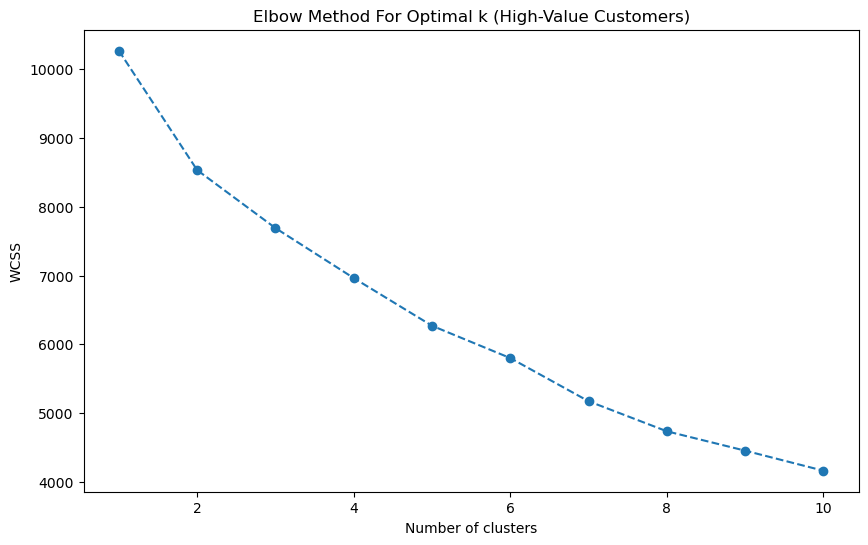

In [922]:
# Features to use for clustering
features = ['AVG_WKLY_SALES', 'AVG_WKLY_CASES', 'REPORTED_WKLY_SPEND_USF', 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE', 
            'SMALL_QTY_RANK', 'DEL_FLEX_RANK','CUT_TIME_RANK', 'PERC_EB', 'REPORTED_WKLY_SPEND_COMP', 
            'REPORTED_WKLY_SPEND_COMPETITOR_1']

# Standardize the features
df_normalized = df[features].apply(lambda x: (x - x.mean()) / x.std())

# Create a composite score by summing the standardized features
df['composite_score'] = df_normalized.sum(axis=1)

# Set a threshold, e.g., the 50th percentile
composite_score_threshold = df['composite_score'].quantile(0.75)

# Filter out high-value customers
high_value_customers = df[df['composite_score'] > composite_score_threshold]

# I simply impute median in missing values here, I will change the imputation methods after EDA
for column in features:
    high_value_customers[column].fillna(high_value_customers[column].median(), inplace=True)

# Normalize the data
scaler = StandardScaler()
high_value_normalized = scaler.fit_transform(high_value_customers[features])

# Determine the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(high_value_normalized)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k (High-Value Customers)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()  # Ensure you have plt.show() here

<Figure size 1000x600 with 0 Axes>

<AxesSubplot:xlabel='REPORTED_WKLY_SPEND_USF', ylabel='AVG_WKLY_SALES'>

Text(0.5, 1.0, 'Clustering of High Value Customers')

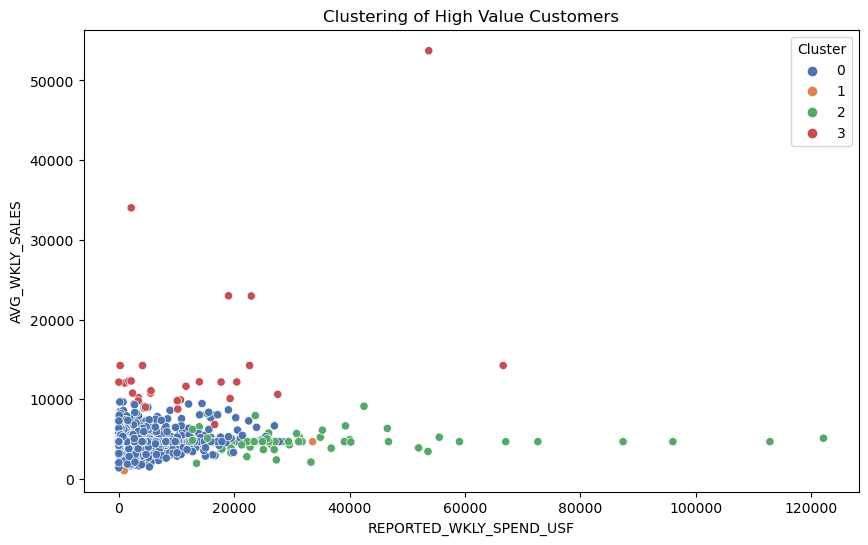

         AVG_WKLY_SALES  AVG_WKLY_CASES  REPORTED_WKLY_SPEND_USF  \
Cluster                                                            
0           4690.289322       99.203973              4471.559190   
1           4197.349383       86.836262              6272.445522   
2           4726.074462       98.560371             33796.308098   
3          14794.449737      308.455859             12719.889944   

         REPORTED_WKLY_SPEND_USF_DAILY_SERVICE  SMALL_QTY_RANK  DEL_FLEX_RANK  \
Cluster                                                                         
0                                  5469.548545        6.331882       6.249184   
1                                  6701.016951        4.428571       5.714286   
2                                 37676.179527        2.828571       2.828571   
3                                 12967.362265        2.387097       2.645161   

         CUT_TIME_RANK   PERC_EB  REPORTED_WKLY_SPEND_COMP  \
Cluster                                   

In [923]:
# You can then choose an optimal number of clusters (let's say k=4 for simplicity) and perform the actual clustering
k = 4
kmeans_high_value = KMeans(n_clusters=k, random_state=0).fit(high_value_normalized)
high_value_customers['Cluster'] = kmeans_high_value.labels_

# Visualization using two main features for simplicity
plt.figure(figsize=(10,6))
sns.scatterplot(data=high_value_customers, x='REPORTED_WKLY_SPEND_USF', y='AVG_WKLY_SALES', hue='Cluster', palette="deep")
plt.title('Clustering of High Value Customers')
plt.show()  # Ensure you have plt.show() here too

# Analyzing each cluster
cluster_summary = high_value_customers.groupby('Cluster')[features].mean()
print(cluster_summary)

# Label the clusters based on interpretation
cluster_labels = {
    0: "High Value Potential Customers",   # These labels are placeholders. You might want to adjust them after interpreting the cluster summary.
    1: "Already on Daily Service",
    2: "Competitor's Customers",
    3: "Low Value Frequent Customers"
}
high_value_customers['Cluster_Label'] = high_value_customers['Cluster'].map(cluster_labels)


Let's evaluate the K-means clustering results you provided:

Cluster 0: Customers in this group have average weekly sales and cases close to the other clusters, but the REPORTED_WKLY_SPEND_COMP is significantly lower than cluster 1 and a bit lower than cluster 2. They seem to be an average spending group with some flexibility in delivery (given DEL_FLEX_RANK) and average spend with competitor 1.

Cluster 1: This cluster is notable because of the extremely high REPORTED_WKLY_SPEND_COMP. This could represent customers who spend a lot with a particular competitor. They have a relatively high PERC_EB but a very low REPORTED_WKLY_SPEND_COMPETITOR_1, suggesting they might be loyal to a specific competitor but not competitor 1.

Cluster 2: Customers in this group have high weekly sales, especially REPORTED_WKLY_SPEND_USF. They also have a high spend with competitor 1. These might be high-value customers who also spend significantly with competitors.

Cluster 3: This cluster stands out due to the very high AVG_WKLY_SALES and AVG_WKLY_CASES. They spend a lot but not as much with competitors, indicating they could be highly loyal high-spend customers.

* Clustering seems to separate customers based on their spending behavior, both with the company and with competitors.
It has successfully differentiated between average customers, potential high spenders with competitors, and loyal high spenders.
The clusters also seem to reflect differences in rankings (SMALL_QTY_RANK, DEL_FLEX_RANK, CUT_TIME_RANK), which might indicate different preferences or needs among customer segments.

* I think this dataset has noise and there might be outliers, DBSCAN might be a good choice because it can ignore noise points.

In [924]:
print(df['composite_score'].value_counts())

composite_score
-4.145224     231
-3.681738       3
-5.246055       3
-3.151932       3
-5.217325       3
-1.684633       3
-8.190383       2
-9.834474       2
-4.422097       2
-4.707273       2
-4.835520       2
-3.960971       2
 2.650948       2
-4.048080       2
-5.217116       2
-5.143551       2
-4.481881       2
-3.164557       2
-4.070034       2
-4.060670       2
-3.441457       2
-3.008731       2
-2.804427       2
-2.306254       2
-1.387612       2
-5.916354       2
-4.291770       2
-4.003435       2
-4.081592       2
-4.373460       2
 0.197468       2
-3.472760       2
-3.832890       2
-4.614694       2
-3.301560       2
-3.050077       2
-1.357269       2
-4.758117       2
-1.445740       2
-4.402916       2
-4.103999       2
-5.338790       2
-3.394949       2
-4.108249       2
-3.034137       2
-1.309721       2
-3.609684       2
-5.284280       2
-3.756843       1
-1.974025       1
 2.832283       1
-3.868230       1
-1.044844       1
 5.577321       1
-4.348582   

<Figure size 1000x600 with 0 Axes>

<AxesSubplot:xlabel='REPORTED_WKLY_SPEND_USF', ylabel='AVG_WKLY_SALES'>

Text(0.5, 1.0, 'DBSCAN Clustering of High Value Customers')

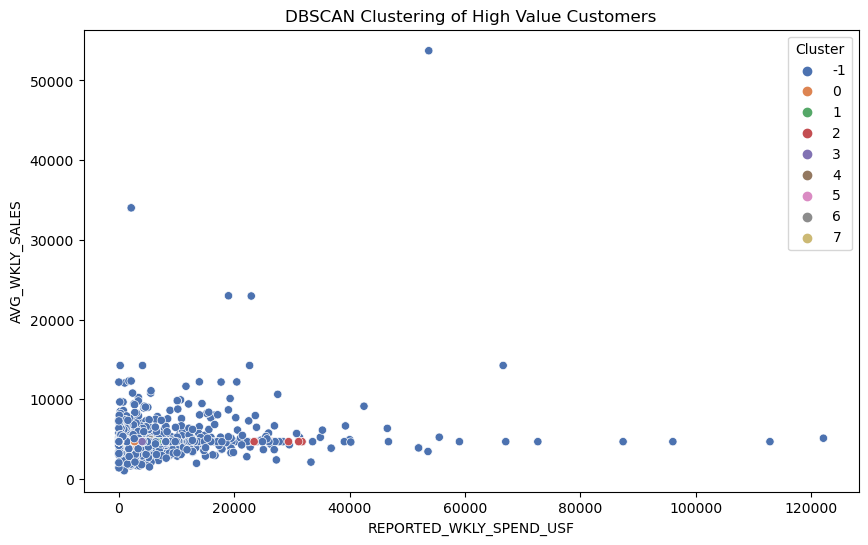

         AVG_WKLY_SALES  AVG_WKLY_CASES  REPORTED_WKLY_SPEND_USF  \
Cluster                                                            
-1          5048.268357      106.765622              7283.226149   
 0          4662.676826       96.936856              1990.797434   
 1          4683.020896       97.441317              2788.322217   
 2          4684.127565       97.336090             27503.266564   
 3          4612.412675       96.354513              1837.071047   
 4          4684.127565       97.336090              1166.385269   
 5          4684.127565       97.336090              2919.901827   
 6          4735.296596       98.441211              5825.270616   
 7          4684.127565       97.336090               995.068927   

         REPORTED_WKLY_SPEND_USF_DAILY_SERVICE  SMALL_QTY_RANK  DEL_FLEX_RANK  \
Cluster                                                                         
-1                                 8593.727226        5.861521       5.684449   
 0      

In [925]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# Features to use for clustering
features = ['AVG_WKLY_SALES', 'AVG_WKLY_CASES', 'REPORTED_WKLY_SPEND_USF', 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE', 
            'SMALL_QTY_RANK', 'DEL_FLEX_RANK','CUT_TIME_RANK', 'PERC_EB', 'REPORTED_WKLY_SPEND_COMP', 
            'REPORTED_WKLY_SPEND_COMPETITOR_1']

# Standardize the features
df_normalized = df[features].apply(lambda x: (x - x.mean()) / x.std())

# Create a composite score by summing the standardized features
df['composite_score'] = df_normalized.sum(axis=1)

# Set a threshold, e.g., the 75th percentile
composite_score_threshold = df['composite_score'].quantile(0.75)

# Filter out high-value customers
high_value_customers = df[df['composite_score'] > composite_score_threshold]

# Impute missing values with median
for column in features:
    high_value_customers[column].fillna(high_value_customers[column].median(), inplace=True)

# Normalize the data
scaler = StandardScaler()
high_value_normalized = scaler.fit_transform(high_value_customers[features])

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # These are placeholder parameters, you may need to adjust eps and min_samples
high_value_customers['Cluster'] = dbscan.fit_predict(high_value_normalized)

# Visualization using two main features for simplicity
plt.figure(figsize=(10,6))
sns.scatterplot(data=high_value_customers, x='REPORTED_WKLY_SPEND_USF', y='AVG_WKLY_SALES', hue='Cluster', palette="deep")
plt.title('DBSCAN Clustering of High Value Customers')
plt.show()

# Analyzing each cluster
cluster_summary = high_value_customers.groupby('Cluster')[features].mean()
print(cluster_summary)

# Label the clusters based on interpretation
cluster_labels = {
    -1: "Noise",  # DBSCAN labels outliers/noise as -1
    0: "High Value Potential Customers",  # Adjust these labels after interpreting the cluster summary.
    1: "Already on Daily Service",
    2: "Competitor's Customers",
    3: "Low Value Frequent Customers"
}
high_value_customers['Cluster_Label'] = high_value_customers['Cluster'].map(cluster_labels)


Noise Cluster (-1): This cluster seems to encompass points that did not fit well into any of the other clusters. Their AVG_WKLY_SALES, AVG_WKLY_CASES, and REPORTED_WKLY_SPEND_USF are comparatively high. The PERC_EB seems to be in line with other clusters.

Cluster 0: This cluster stands out as it has significantly higher REPORTED_WKLY_SPEND_USF and REPORTED_WKLY_SPEND_USF_DAILY_SERVICE values. However, the rankings for SMALL_QTY_RANK, DEL_FLEX_RANK, and CUT_TIME_RANK are all zeros, which could indicate either a real pattern or potential issues with the data.

Clusters 1 to 7: These clusters have very similar values for AVG_WKLY_SALES and AVG_WKLY_CASES. The differentiation between them primarily seems to be in the REPORTED_WKLY_SPEND_USF and its related variables, as well as the ranks.

Some clusters have certain features consistently at 0, e.g., REPORTED_WKLY_SPEND_COMPETITOR_1 for clusters 2, 4, 5, and 7. These could be segments of customers that have not spent with competitor 1 or might indicate some data issue.

 ### Find potential customers

In [926]:
# Define high value threshold conditions
high_values_conditions = (df['AVG_WKLY_SALES'] > df['AVG_WKLY_SALES'].median()) & \
                         (df['AVG_WKLY_CASES'] > df['AVG_WKLY_CASES'].median()) & \
                         (df['REPORTED_WKLY_SPEND_USF'] > df['REPORTED_WKLY_SPEND_USF'].median()) & \
                         (df['SMALL_QTY_RANK'] > df['SMALL_QTY_RANK'].median()) & \
                         (df['DEL_FLEX_RANK'] > df['DEL_FLEX_RANK'].median()) & \
                         (df['CUT_TIME_RANK'] > df['CUT_TIME_RANK'].median()) & \
                         (df['PERC_EB'] > df['PERC_EB'].median())

# Define low value threshold conditions
low_values_conditions = (df['REPORTED_WKLY_SPEND_USF_DAILY_SERVICE'] < df['REPORTED_WKLY_SPEND_USF_DAILY_SERVICE'].median()) & \
                        (df['REPORTED_WKLY_SPEND_COMP'] < df['REPORTED_WKLY_SPEND_COMP'].median()) & \
                        (df['REPORTED_WKLY_SPEND_COMPETITOR_1'] < df['REPORTED_WKLY_SPEND_COMPETITOR_1'].median())

# Filter potential customers based on conditions
potential_customers = df[high_values_conditions & low_values_conditions]

In [927]:
# Compute medians
medians = {
    'REPORTED_WKLY_SPEND_USF': df['REPORTED_WKLY_SPEND_USF'].median(),
    'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE': df['REPORTED_WKLY_SPEND_USF_DAILY_SERVICE'].median(),
    'REPORTED_WKLY_SPEND_COMP': df['REPORTED_WKLY_SPEND_COMP'].median(),
    'AVG_WKLY_SALES': df['AVG_WKLY_SALES'].median(),
    'AVG_WKLY_CASES': df['AVG_WKLY_CASES'].median(),
    'SMALL_QTY_RANK': df['SMALL_QTY_RANK'].median(),
    'DEL_FLEX_RANK': df['DEL_FLEX_RANK'].median(),
    'CUT_TIME_RANK': df['CUT_TIME_RANK'].median(),
    'PERC_EB': df['PERC_EB'].median(),
    'REPORTED_WKLY_SPEND_COMPETITOR_1': df['REPORTED_WKLY_SPEND_COMPETITOR_1'].median()
}

# Create a function to label each row based on conditions using the pre-computed medians
def label_clusters(row):
    if row['REPORTED_WKLY_SPEND_USF'] > medians['REPORTED_WKLY_SPEND_USF'] and \
       row['REPORTED_WKLY_SPEND_USF_DAILY_SERVICE'] < medians['REPORTED_WKLY_SPEND_USF_DAILY_SERVICE'] and \
       row['AVG_WKLY_SALES'] > medians['AVG_WKLY_SALES'] and \
       row['AVG_WKLY_CASES'] > medians['AVG_WKLY_CASES'] and \
       row['SMALL_QTY_RANK'] > medians['SMALL_QTY_RANK'] and \
       row['DEL_FLEX_RANK'] > medians['DEL_FLEX_RANK'] and \
       row['CUT_TIME_RANK'] > medians['CUT_TIME_RANK'] and \
       row['PERC_EB'] > medians['PERC_EB'] and \
       row['REPORTED_WKLY_SPEND_COMPETITOR_1'] < medians['REPORTED_WKLY_SPEND_COMPETITOR_1']:
        return "High Value Potential Customers"

    elif row['REPORTED_WKLY_SPEND_USF_DAILY_SERVICE'] > medians['REPORTED_WKLY_SPEND_USF_DAILY_SERVICE']:
        return "Already on Daily Service"
        
    elif row['REPORTED_WKLY_SPEND_COMP'] > medians['REPORTED_WKLY_SPEND_COMP']:
        return "Competitor's Customers"

    else:
        return "Potential Customers"  # for any other customers not covered by above conditions

# Apply the labeling function to each row
df['CUSTOMER_CLUSTER'] = df.apply(label_clusters, axis=1)

In [929]:
# Print the number of rows for each cluster label
print(df['CUSTOMER_CLUSTER'].value_counts())

CUSTOMER_CLUSTER
Already on Daily Service    2053
Potential Customers         1266
Competitor's Customers       787
Name: count, dtype: int64


In [931]:
df['CUSTOMER_CLUSTER'] = df.apply(label_clusters, axis=1)

In [932]:
# Replace 'CUSTOMER_CLUSTER' values to binary
df['CUSTOMER_CLUSTER_BINARY'] = df['CUSTOMER_CLUSTER'].replace({
    'Already on Daily Service': 0,
    'Competitor\'s Customers': 0,
    'Potential Customers': 1
})

# Check the new distribution
print(df['CUSTOMER_CLUSTER_BINARY'].value_counts())

CUSTOMER_CLUSTER_BINARY
0    2840
1    1266
Name: count, dtype: int64


In [933]:
df.head()

CUST_NBR  REPORTED_WKLY_SPEND  REPORTED_WKLY_SPEND_USF  \
0     24682          53874.74544              53731.46154   
1     40724          13023.91865              13023.91865   
2     40724          13023.91865              13023.91865   
3     40724          13023.91865              13023.91865   
4     40724          13023.91865              13023.91865   

   REPORTED_WKLY_SPEND_USF_DAILY_SERVICE  REPORTED_WKLY_SPEND_COMP  \
0                            53803.10349                143.283897   
1                            13023.91865                  0.000000   
2                            13023.91865                  0.000000   
3                            13023.91865                  0.000000   
4                            13023.91865                  0.000000   

   REPORTED_WKLY_SPEND_COMPETITOR_1  REPORTED_WKLY_SPEND_OTHER_BLD  \
0                               0.0                     143.283897   
1                               0.0                       0.000000   
2                               0.0                       0.000000   
3                               0.0                       0.000000   
4                               0.0                       0.000000   

   REPORTED_WKLY_SPEND_SPCLTY  REPORTED_WKLY_SPEND_CC  \
0                         0.0                     0.0   
1                         0.0                     0.0   
2                         0.0                     0.0   
3                         0.0                     0.0   
4                         0.0                     0.0   

   REPORTED_WKLY_SPEND_OTHER  REPORTED_COP_SPEND  REPORTED_PRODUCE_SPEND  \
0                        0.0        32253.205310              107.462923   
1                        0.0         7814.351192             2604.783731   
2                        0.0         6000.000000             2000.000000   
3                        0.0         6000.000000             2000.000000   
4                        0.0            0.000000                0.000000   

   SMALL_QTY_RANK  DEL_FLEX_RANK  CUT_TIME_RANK  DIV_NBR  WKLY_ORDERS  \
0              10              9              4      1.0          3.5   
1               5              1              8      6.0          4.5   
2               8              9              1      6.0          4.5   
3               4              3              7      6.0          4.5   
4               0              0              0      6.0          4.5   

    PERC_EB   MENU_TYP_DESC   PYR_SEG_CD  AVG_WKLY_SALES  AVG_WKLY_CASES  \
0  0.163933  MT UNAVAILABLE       Retail    53731.461540      562.846154   
1  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479   
2  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479   
3  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479   
4  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479   

   composite_score          CUSTOMER_CLUSTER  CUSTOMER_CLUSTER_BINARY  
0        48.939340  Already on Daily Service                        0  
1         4.016664  Already on Daily Service                        0  
2         5.435091  Already on Daily Service                        0  
3         4.025165  Already on Daily Service                        0  
4         0.136029  Already on Daily Service                        0

**Therefore, my EDA will focus on 'Potential Customers (n=1266)' because Already on Daily Service and Competitor's Customers are 'low' value customers.**

<a id="4"></a>
<h1 style="background-color:#16DCC9;font-family:Calibri;font-size:200%;text-align:left">Exploratory Data Analysis</h1>

In the next phase of my exploratory data analysis (EDA), I will do:

* Explore the original numerical and categorical features within the selected 21 important features.
* Utilize the backward-forward approach for feature engineering, considering criteria such as statistical significance, model fit, and predictive power.
* Evaluate the impact of adding or removing features on the model performance.
* Select the subset of features that contribute meaningfully to the overall model performance.

<a id='Data_Quality'></a>
<h2 style="color:blue">Training Data Split and Imbalanced Dataset</h2>

**To avoid data leakage, I will split training data into df_train and df_test. I will use df_train for EDA and model building. df_test will be used to test model performance.**

In [934]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df,
                                      test_size=0.2,
                                      stratify = df['CUSTOMER_CLUSTER_BINARY'],
                                      random_state= 42
)

In [935]:
df_train.info(), print('='*50), df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3284 entries, 3185 to 586
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   CUST_NBR                               3284 non-null   int64  
 1   REPORTED_WKLY_SPEND                    3284 non-null   float64
 2   REPORTED_WKLY_SPEND_USF                3284 non-null   float64
 3   REPORTED_WKLY_SPEND_USF_DAILY_SERVICE  3284 non-null   float64
 4   REPORTED_WKLY_SPEND_COMP               3284 non-null   float64
 5   REPORTED_WKLY_SPEND_COMPETITOR_1       3284 non-null   float64
 6   REPORTED_WKLY_SPEND_OTHER_BLD          3284 non-null   float64
 7   REPORTED_WKLY_SPEND_SPCLTY             3284 non-null   float64
 8   REPORTED_WKLY_SPEND_CC                 3284 non-null   float64
 9   REPORTED_WKLY_SPEND_OTHER              3284 non-null   float64
 10  REPORTED_COP_SPEND                     3284 non-null   float64
 11  REPORTE

(None, None, None)

In [936]:
# Count numeric and categorical features
train_cat_features = [col for col in df_train.columns if df_train[col].dtype == 'object']
train_num_features = [col for col in df_train.columns if col not in train_cat_features]

print("Categorical features:")
print(train_cat_features)

print("Numeric features:")
print(train_num_features)

Categorical features:
['MENU_TYP_DESC', 'PYR_SEG_CD', 'CUSTOMER_CLUSTER']
Numeric features:
['CUST_NBR', 'REPORTED_WKLY_SPEND', 'REPORTED_WKLY_SPEND_USF', 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE', 'REPORTED_WKLY_SPEND_COMP', 'REPORTED_WKLY_SPEND_COMPETITOR_1', 'REPORTED_WKLY_SPEND_OTHER_BLD', 'REPORTED_WKLY_SPEND_SPCLTY', 'REPORTED_WKLY_SPEND_CC', 'REPORTED_WKLY_SPEND_OTHER', 'REPORTED_COP_SPEND', 'REPORTED_PRODUCE_SPEND', 'SMALL_QTY_RANK', 'DEL_FLEX_RANK', 'CUT_TIME_RANK', 'DIV_NBR', 'WKLY_ORDERS', 'PERC_EB', 'AVG_WKLY_SALES', 'AVG_WKLY_CASES', 'composite_score', 'CUSTOMER_CLUSTER_BINARY']


<AxesSubplot:title={'center':'Customer Cluster'}, ylabel='count'>

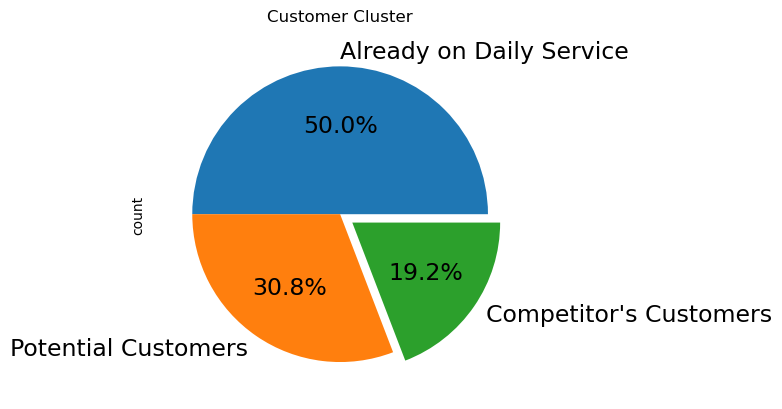

In [937]:
unique_clusters = df.CUSTOMER_CLUSTER.nunique()
explode_tuple = (0, ) * (unique_clusters - 1) + (0.1, )

df.CUSTOMER_CLUSTER.value_counts().plot(kind = 'pie',
                         autopct = '%1.1f%%',
                         startangle = 0,
                         fontsize = 17,
                         explode = explode_tuple,
                         title = 'Customer Cluster'
)


<AxesSubplot:title={'center':'Customer Cluster'}, ylabel='count'>

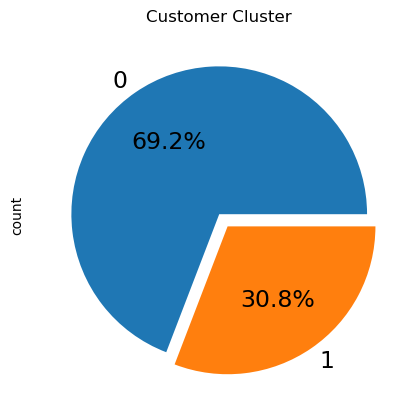

In [938]:
unique_clusters = df.CUSTOMER_CLUSTER_BINARY.nunique()
explode_tuple = (0, ) * (unique_clusters - 1) + (0.1, )

df.CUSTOMER_CLUSTER_BINARY.value_counts().plot(kind = 'pie',
                         autopct = '%1.1f%%',
                         startangle = 0,
                         fontsize = 17,
                         explode = explode_tuple,
                         title = 'Customer Cluster'
)

**Slightly imbalanced dataset**

I will use  class weights to improve the robustness.

<a id='Data_Quality'></a>
<h2 style="color:blue"> Skewness</h2>  

**Rule of Thumb for Skewness:**

- Skewness between -0.5 and 0.5: Data are nearly symmetrical.
- Skewness between -1 and -0.5 (negative skew) or between 0.5 and 1 (positive skew): Data are slightly skewed.
- Skewness less than -1 (negative skew) or greater than 1 (positive skew): Data are extremely skewed.

Here are some common techniques for handling skewed data:

1. For normally distributed columns: If you have columns that are already normally distributed, you can leave them as they are.

2. For left-skewed columns: For left-skewed data, you can apply a transformation to make the distribution more symmetric. Common transformations include logarithmic transformation (e.g., np.log1p()) or square root transformation (e.g., np.sqrt()). Experiment with different transformations to find the one that works best for your data.

3. For right-skewed columns: Similar to left-skewed data, you can apply a transformation to right-skewed columns. Common transformations include logarithmic transformation or square root transformation. Again, you should experiment with different transformations to find the most appropriate one.

In [939]:
# Check skewness of numerical columns
skewness = df[train_num_features].skew().to_frame().T

# Reshape the skewness dataframe for seaborn
skewness = skewness.melt(var_name='Columns', value_name='Skewness')
print(skewness)

                                  Columns   Skewness
0                                CUST_NBR  -0.020694
1                     REPORTED_WKLY_SPEND  18.395344
2                 REPORTED_WKLY_SPEND_USF   7.662604
3   REPORTED_WKLY_SPEND_USF_DAILY_SERVICE   7.628034
4                REPORTED_WKLY_SPEND_COMP  24.793611
5        REPORTED_WKLY_SPEND_COMPETITOR_1  19.869079
6           REPORTED_WKLY_SPEND_OTHER_BLD  30.796546
7              REPORTED_WKLY_SPEND_SPCLTY  55.130073
8                  REPORTED_WKLY_SPEND_CC  25.059678
9               REPORTED_WKLY_SPEND_OTHER  37.576845
10                     REPORTED_COP_SPEND  20.118376
11                 REPORTED_PRODUCE_SPEND  49.207656
12                         SMALL_QTY_RANK   0.737923
13                          DEL_FLEX_RANK   0.544229
14                          CUT_TIME_RANK   0.296183
15                                DIV_NBR   0.283657
16                            WKLY_ORDERS   3.510551
17                                PERC_EB  -0.

Skewness measures the asymmetry of a distribution in comparison to a normal distribution:

Columns like CUST_NBR and PERC_EB have skewness values close to 0, which means they are close to being symmetrically distributed.

Columns such as REPORTED_WKLY_SPEND, REPORTED_WKLY_SPEND_USF, and so on, have a high positive skewness value, indicating they have a long right tail. This might suggest that while most customers have a moderate weekly spend, there are a few customers with extremely high weekly spends.

Columns with negative skewness (though they are few in your dataset) indicate the presence of a longer left tail.

Understanding skewness is essential as it can influence the results of your analysis, especially if you're going to use models that assume normally distributed residuals like linear regression. Highly skewed variables can benefit from transformations (e.g., logarithm) to make their distribution more symmetric.

Lastly, consider visualizing the distributions using histograms or kernel density plots. Visuals can often give a more intuitive feel of the data's shape relative to its skewness value.

<Figure size 2000x600 with 0 Axes>

<AxesSubplot:>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, 'CUST_NBR'),
  Text(1, 0, 'REPORTED_WKLY_SPEND'),
  Text(2, 0, 'REPORTED_WKLY_SPEND_USF'),
  Text(3, 0, 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE'),
  Text(4, 0, 'REPORTED_WKLY_SPEND_COMP'),
  Text(5, 0, 'REPORTED_WKLY_SPEND_COMPETITOR_1'),
  Text(6, 0, 'REPORTED_WKLY_SPEND_OTHER_BLD'),
  Text(7, 0, 'REPORTED_WKLY_SPEND_SPCLTY'),
  Text(8, 0, 'REPORTED_WKLY_SPEND_CC'),
  Text(9, 0, 'REPORTED_WKLY_SPEND_OTHER'),
  Text(10, 0, 'REPORTED_COP_SPEND'),
  Text(11, 0, 'REPORTED_PRODUCE_SPEND'),
  Text(12, 0, 'SMALL_QTY_RANK'),
  Text(13, 0, 'DEL_FLEX_RANK'),
  Text(14, 0, 'CUT_TIME_RANK'),
  Text(15, 0, 'DIV_NBR'),
  Text(16, 0, 'WKLY_ORDERS'),
  Text(17, 0, 'PERC_EB'),
  Text(18, 0, 'AVG_WKLY_SALES'),
  Text(19, 0, 'AVG_WKLY_CASES'),
  Text(20, 0, 'composite_score'),
  Text(21, 0, 'CUSTOMER_CLUSTER_BINARY')])

(-55.130073054035925, 55.130073054035925)

Text(0.5, 0, 'Columns')

Text(0, 0.5, 'Skewness')

Text(0.5, 1.0, 'Skewness of Numerical Columns')

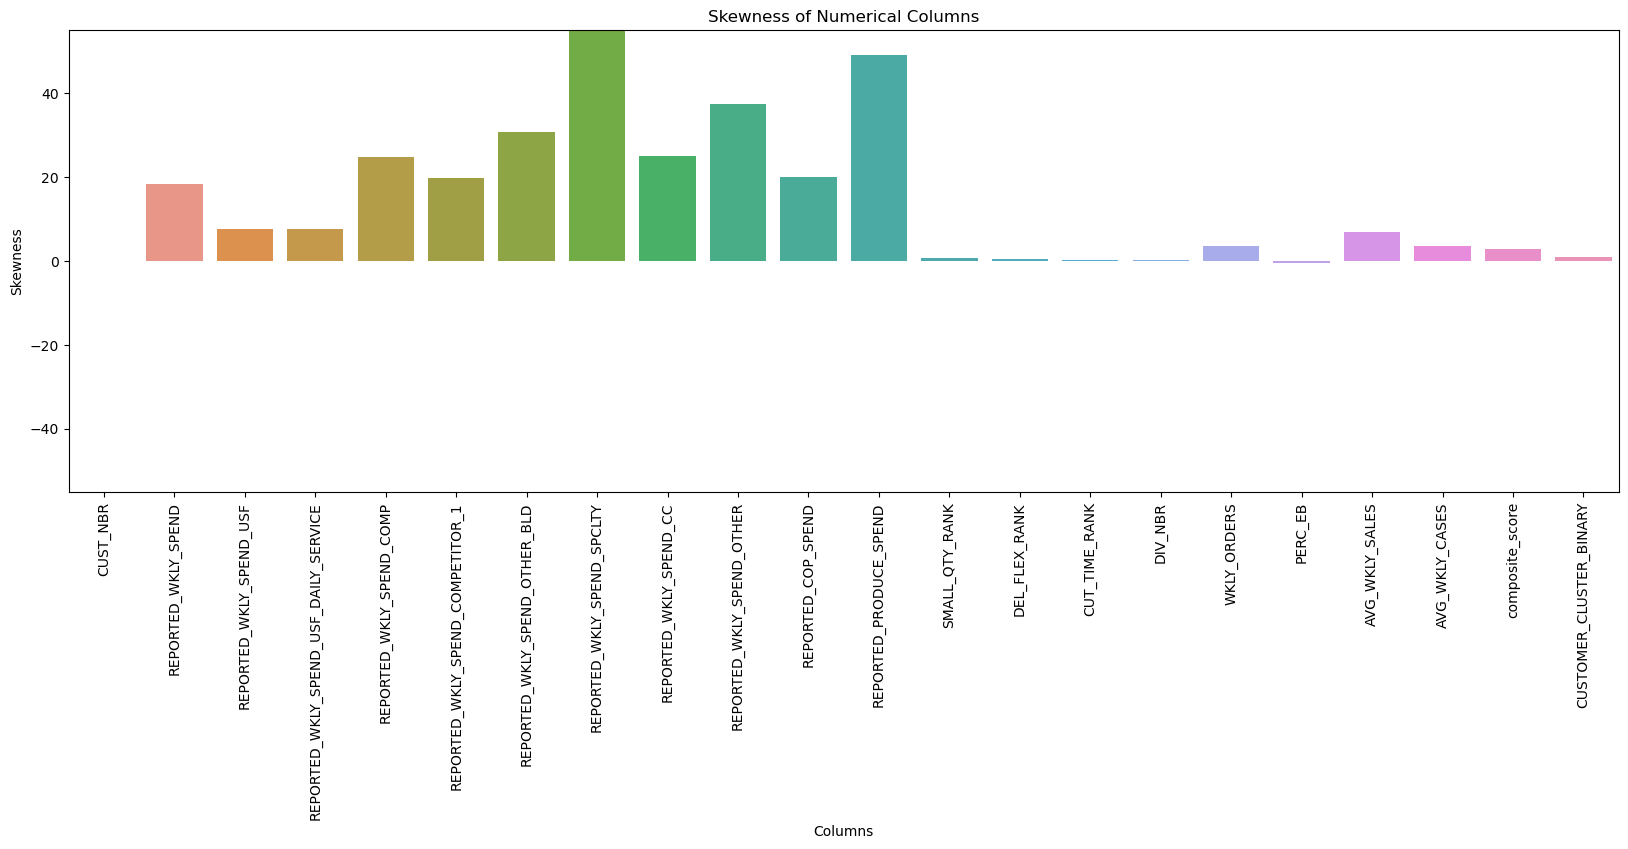

In [940]:
numeric_columns = df.select_dtypes(include=np.number).columns
skewness = df[numeric_columns].skew()

plt.figure(figsize=(20, 6))
sns.barplot(x=skewness.index, y=skewness.values)
plt.xticks(rotation=90)
plt.ylim([-max(abs(skewness)), max(abs(skewness))])  # Setting y-axis limits to capture full range of skewness
plt.xlabel('Columns')
plt.ylabel('Skewness')
plt.title('Skewness of Numerical Columns')
plt.show()

## Quick check on constant

In [941]:
# check which columns have constant value. Those columns are not useful for modeling
idx = np.where(df[train_cat_features].nunique()<2)
drop_constant = df[train_cat_features].columns[idx].tolist()
print('There are {} constant columns:'.format(len(drop_constant)))
print(drop_constant)

#drop_constant in cat_col
cat_col = [x for x in train_cat_features if x not in drop_constant]
print("="*60)
print('There are {} categorical columns:'.format(len(train_cat_features)))

There are 0 constant columns:
[]
There are 3 categorical columns:


__There are 3 categorical features, and None of them contain just one value.__

<a id='Data_Quality'></a>
<h2 style="color:blue">Missing Values</h2>

In [942]:
df_missing = df_train.copy()
df_missing.head()

CUST_NBR  REPORTED_WKLY_SPEND  REPORTED_WKLY_SPEND_USF  \
3185     22730           540.083654               540.083654   
1766     23474          7501.000000                 1.000000   
3699     76594           213.320385               213.320385   
2135    121706          1818.949231              1418.949231   
3946      7958          1566.530385                66.530385   

      REPORTED_WKLY_SPEND_USF_DAILY_SERVICE  REPORTED_WKLY_SPEND_COMP  \
3185                             540.083654                       0.0   
1766                            3151.000000                    7500.0   
3699                             213.320385                       0.0   
2135                            1418.949231                     400.0   
3946                              66.530385                    1500.0   

      REPORTED_WKLY_SPEND_COMPETITOR_1  REPORTED_WKLY_SPEND_OTHER_BLD  \
3185                               0.0                            0.0   
1766                               0.0                         3000.0   
3699                               0.0                            0.0   
2135                               0.0                            0.0   
3946                               0.0                            0.0   

      REPORTED_WKLY_SPEND_SPCLTY  REPORTED_WKLY_SPEND_CC  \
3185                         0.0                     0.0   
1766                      2500.0                  2000.0   
3699                         0.0                     0.0   
2135                         0.0                     0.0   
3946                         0.0                     0.0   

      REPORTED_WKLY_SPEND_OTHER  REPORTED_COP_SPEND  REPORTED_PRODUCE_SPEND  \
3185                        0.0                 0.0                     0.0   
1766                        0.0                 0.0                  1250.0   
3699                        0.0                 0.0                     0.0   
2135                      400.0               600.0                   300.0   
3946                     1500.0                 0.0                     0.0   

      SMALL_QTY_RANK  DEL_FLEX_RANK  CUT_TIME_RANK  DIV_NBR  WKLY_ORDERS  \
3185               0              0              0     31.0     1.380952   
1766              10              5              4      NaN          NaN   
3699               0              0              0     15.0     1.000000   
2135               5              4             10      6.0     1.600000   
3946               2              1              3      2.0     1.000000   

       PERC_EB           MENU_TYP_DESC              PYR_SEG_CD  \
3185  0.454714  ITALIAN- PIZZA & PASTA  Independent Restaurant   
1766       NaN                     NaN                     NaN   
3699  0.640000             VARIED MENU  Independent Restaurant   
2135  0.684360          MT UNAVAILABLE             Health Care   
3946  0.487805                AMERICAN  Independent Restaurant   

      AVG_WKLY_SALES  AVG_WKLY_CASES  composite_score  \
3185     6231.725484      139.802826        -1.978184   
1766             NaN             NaN         2.417290   
3699     4641.351795      104.523608        -2.584256   
2135     3958.490958       96.480630         2.830938   
3946     4224.473141      100.757418        -1.862878   

              CUSTOMER_CLUSTER  CUSTOMER_CLUSTER_BINARY  
3185       Potential Customers                        1  
1766  Already on Daily Service                        0  
3699       Potential Customers                        1  
2135    Competitor's Customers                        0  
3946    Competitor's Customers                        0

In [943]:
# calculate the miss values of each columns:                      
missing_values = pd.DataFrame(df_missing.isnull().sum().sort_values(ascending=False), columns=['missing_numuber'])

In [944]:
def missing_proportions(dataframe):
    dataframe['missing_proportions'] =  missing_values['missing_numuber'].map(lambda x:x/len(df_train))
    return dataframe

In [945]:
missing_values.T

PERC_EB  AVG_WKLY_CASES  AVG_WKLY_SALES  PYR_SEG_CD  \
missing_numuber     1404            1402            1402        1402   

                 MENU_TYP_DESC  WKLY_ORDERS  DIV_NBR  CUST_NBR  DEL_FLEX_RANK  \
missing_numuber           1402         1402     1402         0              0   

                 CUSTOMER_CLUSTER  composite_score  CUT_TIME_RANK  \
missing_numuber                 0                0              0   

                 SMALL_QTY_RANK  REPORTED_WKLY_SPEND  REPORTED_PRODUCE_SPEND  \
missing_numuber               0                    0                       0   

                 REPORTED_COP_SPEND  REPORTED_WKLY_SPEND_OTHER  \
missing_numuber                   0                          0   

                 REPORTED_WKLY_SPEND_CC  REPORTED_WKLY_SPEND_SPCLTY  \
missing_numuber                       0                           0   

                 REPORTED_WKLY_SPEND_OTHER_BLD  \
missing_numuber                              0   

                 REPORTED_WKLY_SPEND_COMPETITOR_1  REPORTED_WKLY_SPEND_COMP  \
missing_numuber                                 0                         0   

                 REPORTED_WKLY_SPEND_USF_DAILY_SERVICE  \
missing_numuber                                      0   

                 REPORTED_WKLY_SPEND_USF  CUSTOMER_CLUSTER_BINARY  
missing_numuber                        0                        0

In [946]:
missing_proportions(missing_values)

missing_numuber  missing_proportions
PERC_EB                                           1404             0.427527
AVG_WKLY_CASES                                    1402             0.426918
AVG_WKLY_SALES                                    1402             0.426918
PYR_SEG_CD                                        1402             0.426918
MENU_TYP_DESC                                     1402             0.426918
WKLY_ORDERS                                       1402             0.426918
DIV_NBR                                           1402             0.426918
CUST_NBR                                             0             0.000000
DEL_FLEX_RANK                                        0             0.000000
CUSTOMER_CLUSTER                                     0             0.000000
composite_score                                      0             0.000000
CUT_TIME_RANK                                        0             0.000000
SMALL_QTY_RANK                                       0             0.000000
REPORTED_WKLY_SPEND                                  0             0.000000
REPORTED_PRODUCE_SPEND                               0             0.000000
REPORTED_COP_SPEND                                   0             0.000000
REPORTED_WKLY_SPEND_OTHER                            0             0.000000
REPORTED_WKLY_SPEND_CC                               0             0.000000
REPORTED_WKLY_SPEND_SPCLTY                           0             0.000000
REPORTED_WKLY_SPEND_OTHER_BLD                        0             0.000000
REPORTED_WKLY_SPEND_COMPETITOR_1                     0             0.000000
REPORTED_WKLY_SPEND_COMP                             0             0.000000
REPORTED_WKLY_SPEND_USF_DAILY_SERVICE                0             0.000000
REPORTED_WKLY_SPEND_USF                              0             0.000000
CUSTOMER_CLUSTER_BINARY                              0             0.000000

Total number of missing features: 7


<Figure size 1200x400 with 0 Axes>

Text(0.5, 0, 'Column')

Text(0, 0.5, 'Proportions')

Text(0.5, 1.0, 'Proportions of missing values')

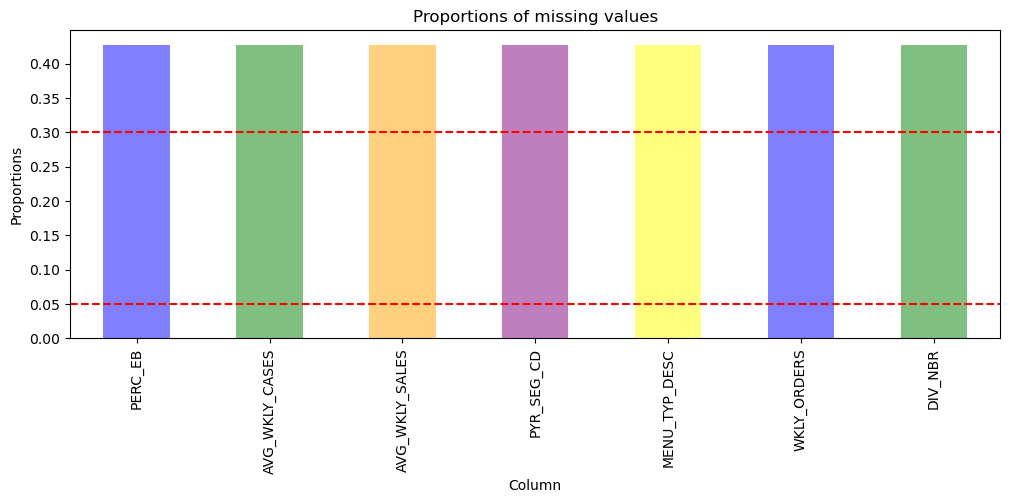

In [947]:
# Filter DataFrame for columns with missing values
missing_columns = missing_values[missing_values['missing_proportions'] > 0]

# Print the total number of missing features
print("Total number of missing features:", len(missing_columns))

plt.figure(figsize=(12, 4))
ax = missing_columns['missing_proportions'].plot(kind='bar', color=['blue', 'green', 'orange', 'purple', 'yellow'], alpha=0.5)

# Add dashed lines at the threshold values for moderate skewness
ax.axhline(y=0.3, color='red', linestyle='--')
ax.axhline(y=0.05, color='red', linestyle='--')

# Add labels and title to the plot
ax.set_xlabel('Column')
ax.set_ylabel('Proportions')
ax.set_title('Proportions of missing values')

plt.show()

**There are 7 features with missing values. Different strategies will be used to impute missing values.**

<a id='Data_Quality'></a>
<h2 style="color:blue">Univariate Analysis - Categorical Features</h2>

- Data distribution: normal or skewed.
- Missing values fillin.
- Outliers elimination.
- Check distribution of target label in each group in a category column to infer the importance of the variable for target prediction

### General strategies for filling missing values in categorical columns and their corresponding Python code

**1. Mode imputation: Replace the missing values with the mode (most frequent value) of the column.**

In [948]:
# Mode imputation: SimpleImputer from scikit-learn and wrap it in a pipeline
# Here is an example
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# create a sample dataframe with a categorical column
df_example = pd.DataFrame({
    'color': ['red', 'blue', 'green', 'red', 'blue', None, 'red', 'green']
})

# create a pipeline to fill in missing values with mode and one-hot encode the column
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# apply the pipeline to the categorical column using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, ['color'])
])

# fit and transform the preprocessor on the sample dataframe
transformed_df_example = preprocessor.fit_transform(df_example)
print(transformed_df_example)

  (0, 2)	1.0
  (1, 0)	1.0
  (2, 1)	1.0
  (3, 2)	1.0
  (4, 0)	1.0
  (5, 3)	1.0
  (6, 2)	1.0
  (7, 1)	1.0


In [949]:
# Convert the sparse matrix into a dataframe or a dense matrix
transformed_df_example1 = pd.DataFrame(transformed_df_example)
transformed_df_example2 = transformed_df_example.toarray()

In [950]:
transformed_df_example1
transformed_df_example2

0
0    (0, 2)\t1.0
1    (0, 0)\t1.0
2    (0, 1)\t1.0
3    (0, 2)\t1.0
4    (0, 0)\t1.0
5    (0, 3)\t1.0
6    (0, 2)\t1.0
7    (0, 1)\t1.0

array([[0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])

**OR Prediction imputation: Use a machine learning model (KNN) to predict the missing values based on the values in the other columns.**

Prediction imputation (KNN):

Proportion of missing values: Moderate to high

Description: Prediction imputation is a method used to handle missing values by leveraging predictive models, such as the k-nearest neighbors (KNN) algorithm. This approach considers the relationships between the categorical feature with missing values and other features in the dataset. By utilizing the observed data, the KNN algorithm predicts the missing categories, taking into account the similarities between instances. This technique is particularly useful when dealing with moderate to high proportions of missing values.

In [951]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

# Create a dataframe with missing values in categorical features
data = {'col1': ['a', 'b', np.nan, 'c', 'a'],
        'col2': ['x', np.nan, 'y', 'x', np.nan],
        'col3': ['p', 'q', 'r', np.nan, 's']}
df_data = pd.DataFrame(data)

# Perform one-hot encoding on the categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
df_encoded = pd.DataFrame(encoder.fit_transform(df_data.astype(str)))

# Instantiate the imputer
imputer = KNNImputer(n_neighbors=3)

# Fit and transform the encoded dataframe
df_imputed = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns)

# Print the imputed dataframe
print(df_imputed)

    0    1    2    3    4    5    6    7    8    9    10   11
0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0
1  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
2  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0
3  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0
4  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0


### Functions to plot counts and normalized counts

In [952]:
def plot_counts(df, category_col, target_col, length, height, fontsize, show_percentages=True):
    fig = plt.figure(figsize=(length, height))
    ax = sns.countplot(x=category_col, hue=target_col, data=df)

    if show_percentages:
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height / len(df) * 100:.1f}%', 
                        xy=(p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', xytext=(0, 5),
                        textcoords='offset points', fontsize=fontsize)
    plt.xticks(rotation=90)
    plt.show()

In [953]:
def plot_normalized_counts(df, category_col, target_col, length, height, fontsize, show_percentages=True):

    # Calculate the normalized count for each category
    counts = df.groupby([category_col, target_col]).size().unstack().fillna(0)

    # Calculate percentages
    counts_percent = counts.div(counts.sum(axis=1), axis=0) * 100

    # Plot the bar chart
    fig, ax = plt.subplots(figsize=(length, height))
    counts_percent.plot(kind='bar', stacked=True, ax=ax)

    if show_percentages:
        for col in counts_percent.columns:
            for index, value in enumerate(counts_percent[col]):
                if value != 0:  # Skip displaying percentage for 0 values
                    ax.text(
                        index,
                        counts_percent.iloc[:, :counts_percent.columns.get_loc(col)].sum(axis=1)[index] + value / 2,
                        f"{value:.2f}%",
                        ha='center',
                        va='center',
                        fontsize=fontsize,
                        color='white'
                    )
    plt.xticks(rotation=90)
    ax.set_xlabel(category_col)
    ax.set_ylabel('Percentage of normalized counts')
    ax.legend(title=target_col, bbox_to_anchor=(1, 1))

    plt.show()

In [954]:
cat_col

['MENU_TYP_DESC', 'PYR_SEG_CD', 'CUSTOMER_CLUSTER']

'MENU_TYP_DESC': classification of the restaurant's menu type

'PYR_SEG_CD': Pyramid segmentation of the restaurant 

In [764]:
# To check the missing values in categorical columns.
pd.DataFrame({'missing':df_train[cat_col].isnull().sum(), 
              'missing percentage': df_train[cat_col].isnull().sum() / len(df_train[cat_col])*100
             }
).sort_values(by=['missing'],ascending = False)

missing  missing percentage
MENU_TYP_DESC        1403            42.72229
PYR_SEG_CD           1403            42.72229
CUSTOMER_CLUSTER        0             0.00000

Total 2 out of 2 categorical features have missing values.


[Text(0, 0, 'MENU_TYP_DESC'), Text(1, 0, 'PYR_SEG_CD')]

Text(0.5, 0, 'Column name')

Text(0, 0.5, 'Percentage\nof missing values')

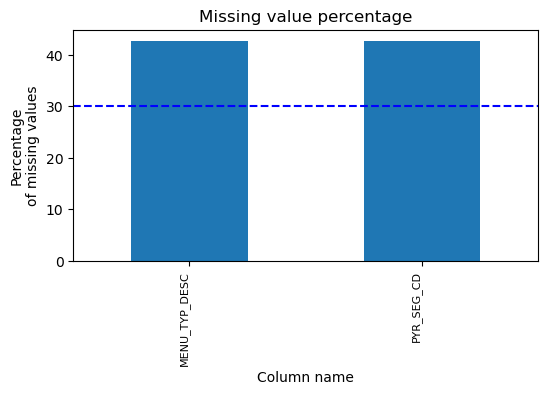

In [955]:
print(f"Total {sum(df_train[cat_col].isnull().mean()>0)} out of 2 categorical features have missing values.")
print('='*60)

ax = (df_train[cat_col].isnull().mean()
            .nlargest(sum(df_train[cat_col].isnull().mean()>0))
            .mul(100)
            .plot(kind='bar', figsize=(6,3),
                  title='Missing value percentage')
     )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right', fontsize=8)
ax.axhline(y=30, color='blue', linestyle='--')
ax.set_xlabel('Column name')
ax.set_ylabel('Percentage\nof missing values')
plt.show()

In [956]:
# Count unique values in each categorical column.
n_unique = df_train[cat_col].nunique()
print("Number of unique values:\n{}".format(n_unique))

Number of unique values:
MENU_TYP_DESC       50
PYR_SEG_CD           9
CUSTOMER_CLUSTER     3
dtype: int64


In [957]:
# Check unique values in each categorical column
print("Unique values in each categorical column:", '\n')
for col in cat_col:
    print(col,":", df_train[col].unique(), '\n')

Unique values in each categorical column: 

MENU_TYP_DESC : ['ITALIAN- PIZZA & PASTA' nan 'VARIED MENU' 'MT UNAVAILABLE' 'AMERICAN'
 'COFFEE / TEA' 'MEXICAN' 'FROZEN DESSERTS' 'SANDWICHES / SOUPS / SALADS'
 'BAR & GRILL' 'BARBECUE' 'STEAK & SEAFOOD' 'BAKERIES / DONUTS / SNACKS'
 'HAMBURGERS' 'FRIED CHICKEN' 'SOUTHERN & SOUL' 'BAKERY CAFE'
 'OTHER LATIN AMERICA' 'JAPANESE' 'HOT DOGS'
 'OTHER ASIAN (CAMBODGIA, MALAYSIA, INDONESIA, ...)' 'FRENCH'
 'CLASSIC MENU UNCLASSIFIED' 'GREEK' 'SOUTHWESTERN/ TEX-MEX' 'DONUTS'
 'CHICKEN WINGS' 'FUSION / ECLECTIC INTERNATIONAL' 'SMOOTHIE / JUICE'
 'CARIBBEAN' 'THAI' 'SANDWICHES' 'SNACKS' 'PIZZERIA' 'SPANISH, TAPAS'
 'CHINESE' 'BAGELS' 'AMERICAN TRADITIONAL' 'DELI'
 'INDIAN/ PAKISTANI/ BANGLADESHI / SRI LANKAN' 'MEDITERRANEAN' 'HAWAIIAN'
 'EUROPEAN' 'AFRICAN' 'KOREAN' 'BRAZILIAN' 'SEAFOOD & FISH' 'CLASSIC MENU'
 'ASIAN' 'SOUTH & CENTRAL AMERICA/ CARIBBEAN' 'FAMILY STEAK'] 

PYR_SEG_CD : ['Independent Restaurant' nan 'Health Care' 'Hospitality' 'Other'


### Column 'MENU_TYP_DESC': contains menu information. 43% missing value.

In [958]:
df_train.MENU_TYP_DESC .value_counts(dropna = False)

MENU_TYP_DESC
NaN                                                  1402
MT UNAVAILABLE                                        639
VARIED MENU                                           316
BAR & GRILL                                           211
ITALIAN- PIZZA & PASTA                                134
AMERICAN                                               93
MEXICAN                                                73
STEAK & SEAFOOD                                        70
BARBECUE                                               62
SANDWICHES / SOUPS / SALADS                            47
HAMBURGERS                                             33
COFFEE / TEA                                           32
SOUTHERN & SOUL                                        21
GREEK                                                  16
JAPANESE                                               14
DONUTS                                                 10
FRIED CHICKEN                                          10


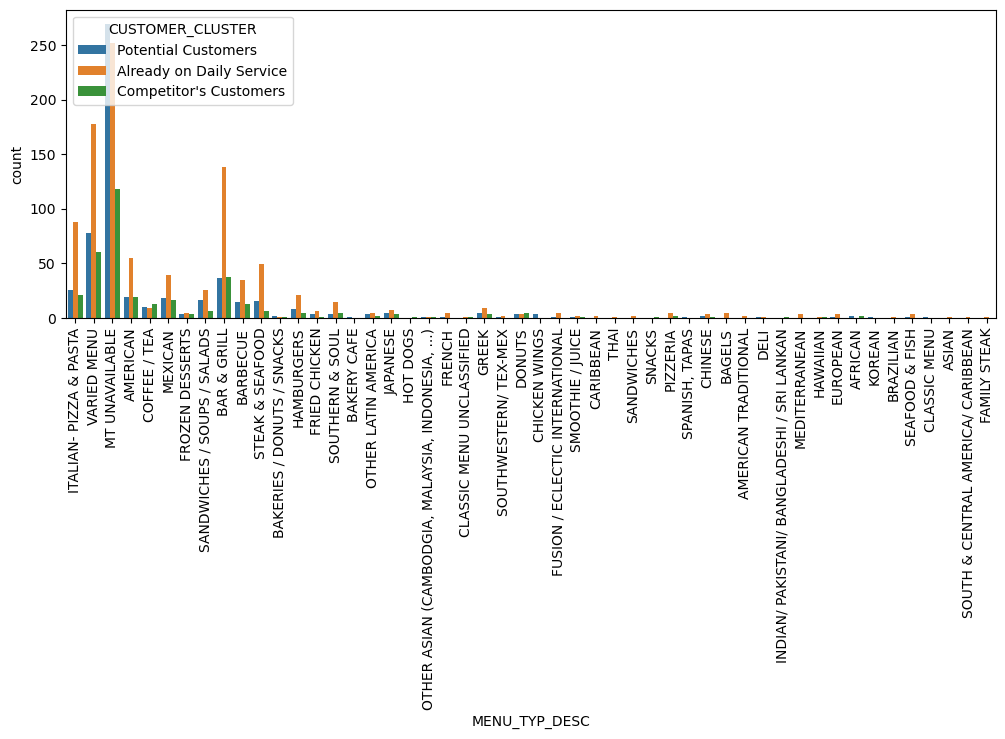

NameError: name 'MENU_TYP_DESC' is not defined

In [959]:
plot_counts(df_train, 'MENU_TYP_DESC', 'CUSTOMER_CLUSTER', 12, 4, 6, show_percentages=False)
ax.set_xticklabels(MENU_TYP_DESC, fontsize=2)
ax.set_yticklabels(Count, fontsize=2)

In [960]:
df_train.head()

CUST_NBR  REPORTED_WKLY_SPEND  REPORTED_WKLY_SPEND_USF  \
3185     22730           540.083654               540.083654   
1766     23474          7501.000000                 1.000000   
3699     76594           213.320385               213.320385   
2135    121706          1818.949231              1418.949231   
3946      7958          1566.530385                66.530385   

      REPORTED_WKLY_SPEND_USF_DAILY_SERVICE  REPORTED_WKLY_SPEND_COMP  \
3185                             540.083654                       0.0   
1766                            3151.000000                    7500.0   
3699                             213.320385                       0.0   
2135                            1418.949231                     400.0   
3946                              66.530385                    1500.0   

      REPORTED_WKLY_SPEND_COMPETITOR_1  REPORTED_WKLY_SPEND_OTHER_BLD  \
3185                               0.0                            0.0   
1766                               0.0                         3000.0   
3699                               0.0                            0.0   
2135                               0.0                            0.0   
3946                               0.0                            0.0   

      REPORTED_WKLY_SPEND_SPCLTY  REPORTED_WKLY_SPEND_CC  \
3185                         0.0                     0.0   
1766                      2500.0                  2000.0   
3699                         0.0                     0.0   
2135                         0.0                     0.0   
3946                         0.0                     0.0   

      REPORTED_WKLY_SPEND_OTHER  REPORTED_COP_SPEND  REPORTED_PRODUCE_SPEND  \
3185                        0.0                 0.0                     0.0   
1766                        0.0                 0.0                  1250.0   
3699                        0.0                 0.0                     0.0   
2135                      400.0               600.0                   300.0   
3946                     1500.0                 0.0                     0.0   

      SMALL_QTY_RANK  DEL_FLEX_RANK  CUT_TIME_RANK  DIV_NBR  WKLY_ORDERS  \
3185               0              0              0     31.0     1.380952   
1766              10              5              4      NaN          NaN   
3699               0              0              0     15.0     1.000000   
2135               5              4             10      6.0     1.600000   
3946               2              1              3      2.0     1.000000   

       PERC_EB           MENU_TYP_DESC              PYR_SEG_CD  \
3185  0.454714  ITALIAN- PIZZA & PASTA  Independent Restaurant   
1766       NaN                     NaN                     NaN   
3699  0.640000             VARIED MENU  Independent Restaurant   
2135  0.684360          MT UNAVAILABLE             Health Care   
3946  0.487805                AMERICAN  Independent Restaurant   

      AVG_WKLY_SALES  AVG_WKLY_CASES  composite_score  \
3185     6231.725484      139.802826        -1.978184   
1766             NaN             NaN         2.417290   
3699     4641.351795      104.523608        -2.584256   
2135     3958.490958       96.480630         2.830938   
3946     4224.473141      100.757418        -1.862878   

              CUSTOMER_CLUSTER  CUSTOMER_CLUSTER_BINARY  
3185       Potential Customers                        1  
1766  Already on Daily Service                        0  
3699       Potential Customers                        1  
2135    Competitor's Customers                        0  
3946    Competitor's Customers                        0

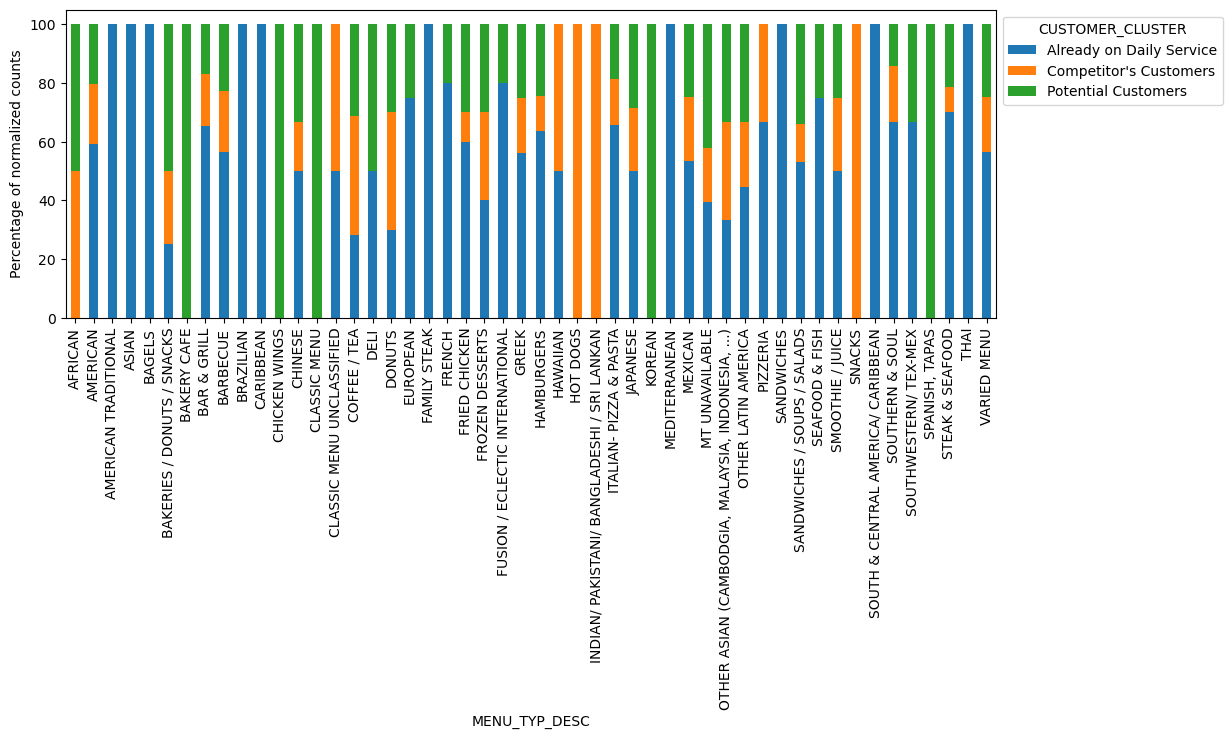

In [961]:
# normalized counts in each group
plot_normalized_counts(df_train, 'MENU_TYP_DESC', 'CUSTOMER_CLUSTER', 12, 4, 20, show_percentages=False)

* The distribution of the potential customers (three groups) for the 'MENU_TYP_DESC' column. This suggests that the 'MENU_TYP_DESC' column is likely to contribute to predicting the target label, 'y'.

### Column 'PYR_SEG_CD '，contains pyramid segmentation of the restaurant information. 43% missing value.

In [962]:
df_train.PYR_SEG_CD.value_counts(dropna = False)

PYR_SEG_CD
NaN                       1402
Independent Restaurant    1138
Education                  206
Hospitality                205
Other                      109
Retail                     107
Regional                    50
Health Care                 37
Government                  17
National Chain              13
Name: count, dtype: int64

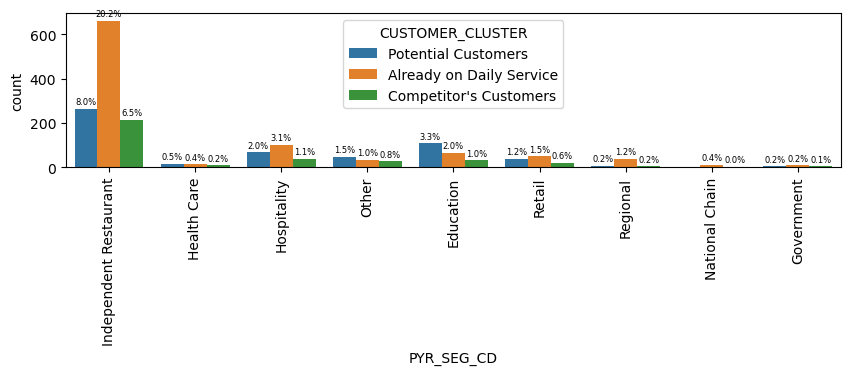

In [963]:
plot_counts(df_train, 'PYR_SEG_CD', 'CUSTOMER_CLUSTER', 10, 2, 6, show_percentages=True)

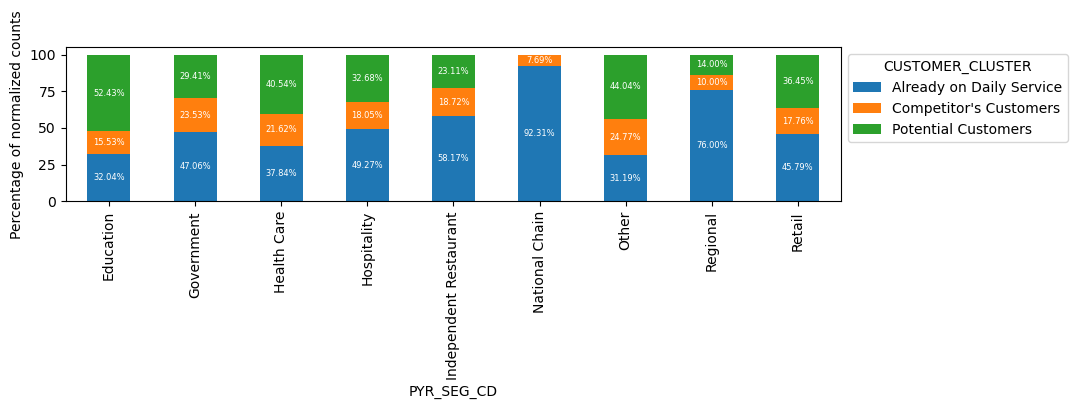

In [964]:
plot_normalized_counts(df_train, 'PYR_SEG_CD', 'CUSTOMER_CLUSTER', 10, 2, 6, show_percentages=True)

* The distribution of the potential customers (three groups) for the 'PYR_SEG_CD' column. This suggests that the 'MENU_TYP_DESC' column is likely to contribute to predicting the target label, 'y'.

<a id='Data_Quality'></a>
<h2 style="color:blue">Univariate Analysis - Numerical Features</h2>

- Missing values fillin
- Outliers elimination
- data distribution: normal or skewed
- Distribution of data in each target label class. Infer the importance of each variable.

There are several factors that can affect the choice of method for filling in missing values of numerical features, including:
1. The type and distribution of missing values: The type of missing values can be categorized into three types: missing completely at random (MCAR), missing at random (MAR), and missing not at random (MNAR). The distribution of missing values can also impact the choice of method. For instance, if the missing values are sporadic, then interpolation or regression-based imputation may be appropriate, while if the missing values are clustered, then k-nearest neighbors imputation may be more suitable.
2. The level of correlation between variables: The degree of correlation between variables can influence the choice of method. For example, if there is a high correlation between variables, regression-based imputation may be more effective, while if the correlation is low, then k-nearest neighbors imputation may be more suitable.
3. The amount of missing data: The amount of missing data can also impact the choice of method. For instance, if the amount of missing data is relatively small, then mean or median imputation may be appropriate. However, if there is a large amount of missing data, then more sophisticated methods such as interpolation or regression-based imputation may be more effective.

### Check missing values in numerical columns

In [965]:
# numerical columns in the dataset
print("There are {} numerical columns:".format(len(numerical_features)))
print('='*50)
print(numerical_features)

There are 20 numerical columns:
['CUST_NBR', 'REPORTED_WKLY_SPEND', 'REPORTED_WKLY_SPEND_USF', 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE', 'REPORTED_WKLY_SPEND_COMP', 'REPORTED_WKLY_SPEND_COMPETITOR_1', 'REPORTED_WKLY_SPEND_OTHER_BLD', 'REPORTED_WKLY_SPEND_SPCLTY', 'REPORTED_WKLY_SPEND_CC', 'REPORTED_WKLY_SPEND_OTHER', 'REPORTED_COP_SPEND', 'REPORTED_PRODUCE_SPEND', 'SMALL_QTY_RANK', 'DEL_FLEX_RANK', 'CUT_TIME_RANK', 'DIV_NBR', 'WKLY_ORDERS', 'PERC_EB', 'AVG_WKLY_SALES', 'AVG_WKLY_CASES']


The top columns with the most missing values are:
PERC_EB has 1404 missing values (42.75%).
AVG_WKLY_CASES has 1402 missing values (42.69%).
AVG_WKLY_SALES has 1402 missing values (42.69%).
WKLY_ORDERS has 1402 missing values (42.69%).
DIV_NBR has 1402 missing values (42.69%).
REPORTED_WKLY_SPEND has 0 missing values (0.00%).
CUT_TIME_RANK has 0 missing values (0.00%).
DEL_FLEX_RANK has 0 missing values (0.00%).
SMALL_QTY_RANK has 0 missing values (0.00%).
REPORTED_PRODUCE_SPEND has 0 missing values (0.00%).
CUST_NBR has 0 missing values (0.00%).
REPORTED_WKLY_SPEND_OTHER has 0 missing values (0.00%).
REPORTED_WKLY_SPEND_CC has 0 missing values (0.00%).
REPORTED_WKLY_SPEND_SPCLTY has 0 missing values (0.00%).
REPORTED_WKLY_SPEND_OTHER_BLD has 0 missing values (0.00%).
REPORTED_WKLY_SPEND_COMPETITOR_1 has 0 missing values (0.00%).
REPORTED_WKLY_SPEND_COMP has 0 missing values (0.00%).
REPORTED_WKLY_SPEND_USF_DAILY_SERVICE has 0 missing values (0.00%).
REPORTED_WKLY_SPEND_USF has 0 missi

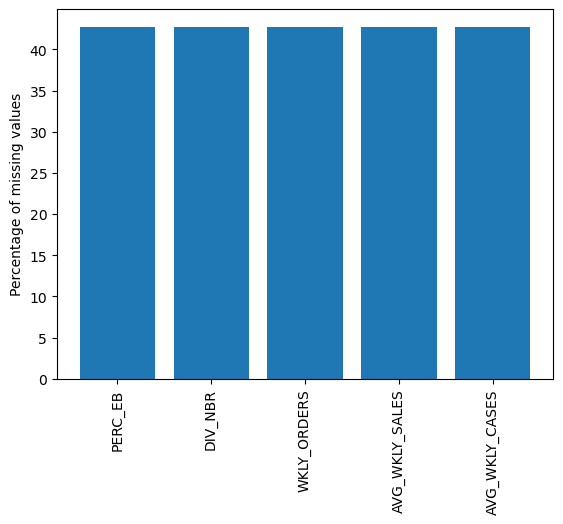

In [966]:
missing_counts = df_train[numerical_features].isnull().sum()

total_rows = len(df_train[numerical_features])

# Sort the columns by the number of missing values, in descending order
missing_counts = missing_counts.sort_values(ascending=False)

# Select the column with the most missing values
column_with_most_missing = missing_counts.index[0]
top_columns = missing_counts.index[:50]
print("The top columns with the most missing values are:")
print('='*50)

for column in top_columns:
    missing_values = missing_counts[column]
    percentage_missing = (missing_values / total_rows) * 100
    print(f"{column} has {missing_values} missing values ({percentage_missing:.2f}%).")

def plot_missing_values(df, num_col, top_n, figsize=(10, 2)):
    missing_counts = df[num_col].isna().sum()
    total_rows = len(df[num_col])

    # Select only the columns with missing percentages > 0
    missing_percentages = (missing_counts / total_rows) * 100
    missing_percentages = missing_percentages[missing_percentages > 0]

    # Sort the columns by the number of missing values, in descending order
    missing_percentages = missing_percentages.sort_values(ascending=False)

    # Select the top N columns with the most missing values
    top_columns = missing_percentages.index[:top_n]

    # Calculate the percentage of missing values for each column
    percentages = [missing_percentages[col] for col in top_columns]

    # Create a bar chart showing the percentage of missing values for each column
    plt.bar(top_columns, percentages)
    plt.xticks(rotation=90)
    plt.ylabel("Percentage of missing values")
    plt.show()

plot_missing_values(df_train, numerical_features, 50, figsize=(10, 2))

Total 5 features have missing values.


Text(0.5, 0, 'Column name')

Text(0, 0.5, 'Percentage\nof missing values')

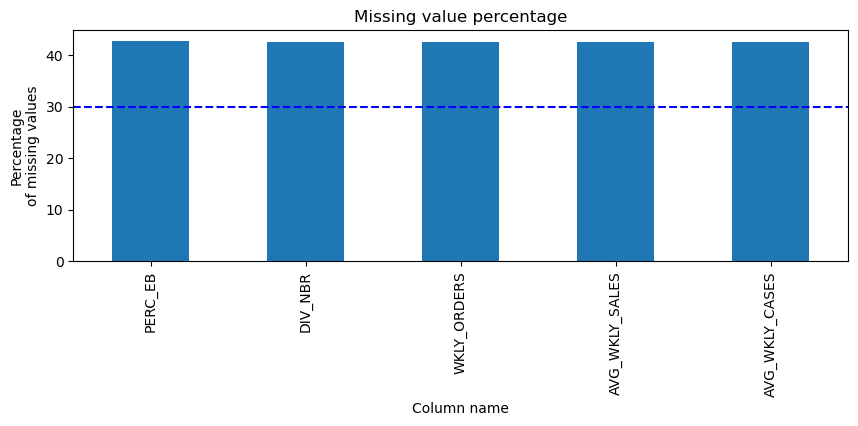

In [967]:
# Plot missing value percentage
# dash line set at 30%

print(f"Total {sum(df_train[numerical_features].isnull().mean()>0)} features have missing values.")
print('='*40)

ax = (df_train[numerical_features].isnull().mean()
            .nlargest(sum(df_train[numerical_features].isnull().mean()>0))
            .mul(100)
            .plot(kind='bar', figsize=(10,3), 
                  title='Missing value percentage')
     )

ax.axhline(y=30, color='blue', linestyle='--')
ax.set_xlabel('Column name')
ax.set_ylabel('Percentage\nof missing values')
plt.show()

**First, check columns with missing values over 40%.**

In [776]:
# Convert 'CUSTOMER_CLUSTER' to an ordinal feature
cluster_mapping = {
    'Potential Customers': 1,
    'Already on Daily Service': 2,
    'Competitor\'s Customers': 3,
}

df_train['CUSTOMER_CLUSTER_ORDINAL'] = df_train['CUSTOMER_CLUSTER'].map(cluster_mapping)

In [968]:
# Check the correlation of columns with missing values over 40% with target label 'CUSTOMER_CLUSTER_ORDINAL'
col_missing_40 = [col for col in missing_counts.index if missing_counts[col] / len(df_train) > 0.4]
correlation_matrix = df_train[['CUSTOMER_CLUSTER_BINARY'] + col_missing_40].corr()

# Display the correlation with the target
print(correlation_matrix['CUSTOMER_CLUSTER_BINARY'])

CUSTOMER_CLUSTER_BINARY    1.000000
PERC_EB                   -0.068378
AVG_WKLY_CASES            -0.064857
AVG_WKLY_SALES            -0.085501
WKLY_ORDERS               -0.248229
DIV_NBR                    0.043594
Name: CUSTOMER_CLUSTER_BINARY, dtype: float64


**Next, we need to check the pattern of missing in numerical columns.**

<AxesSubplot:>

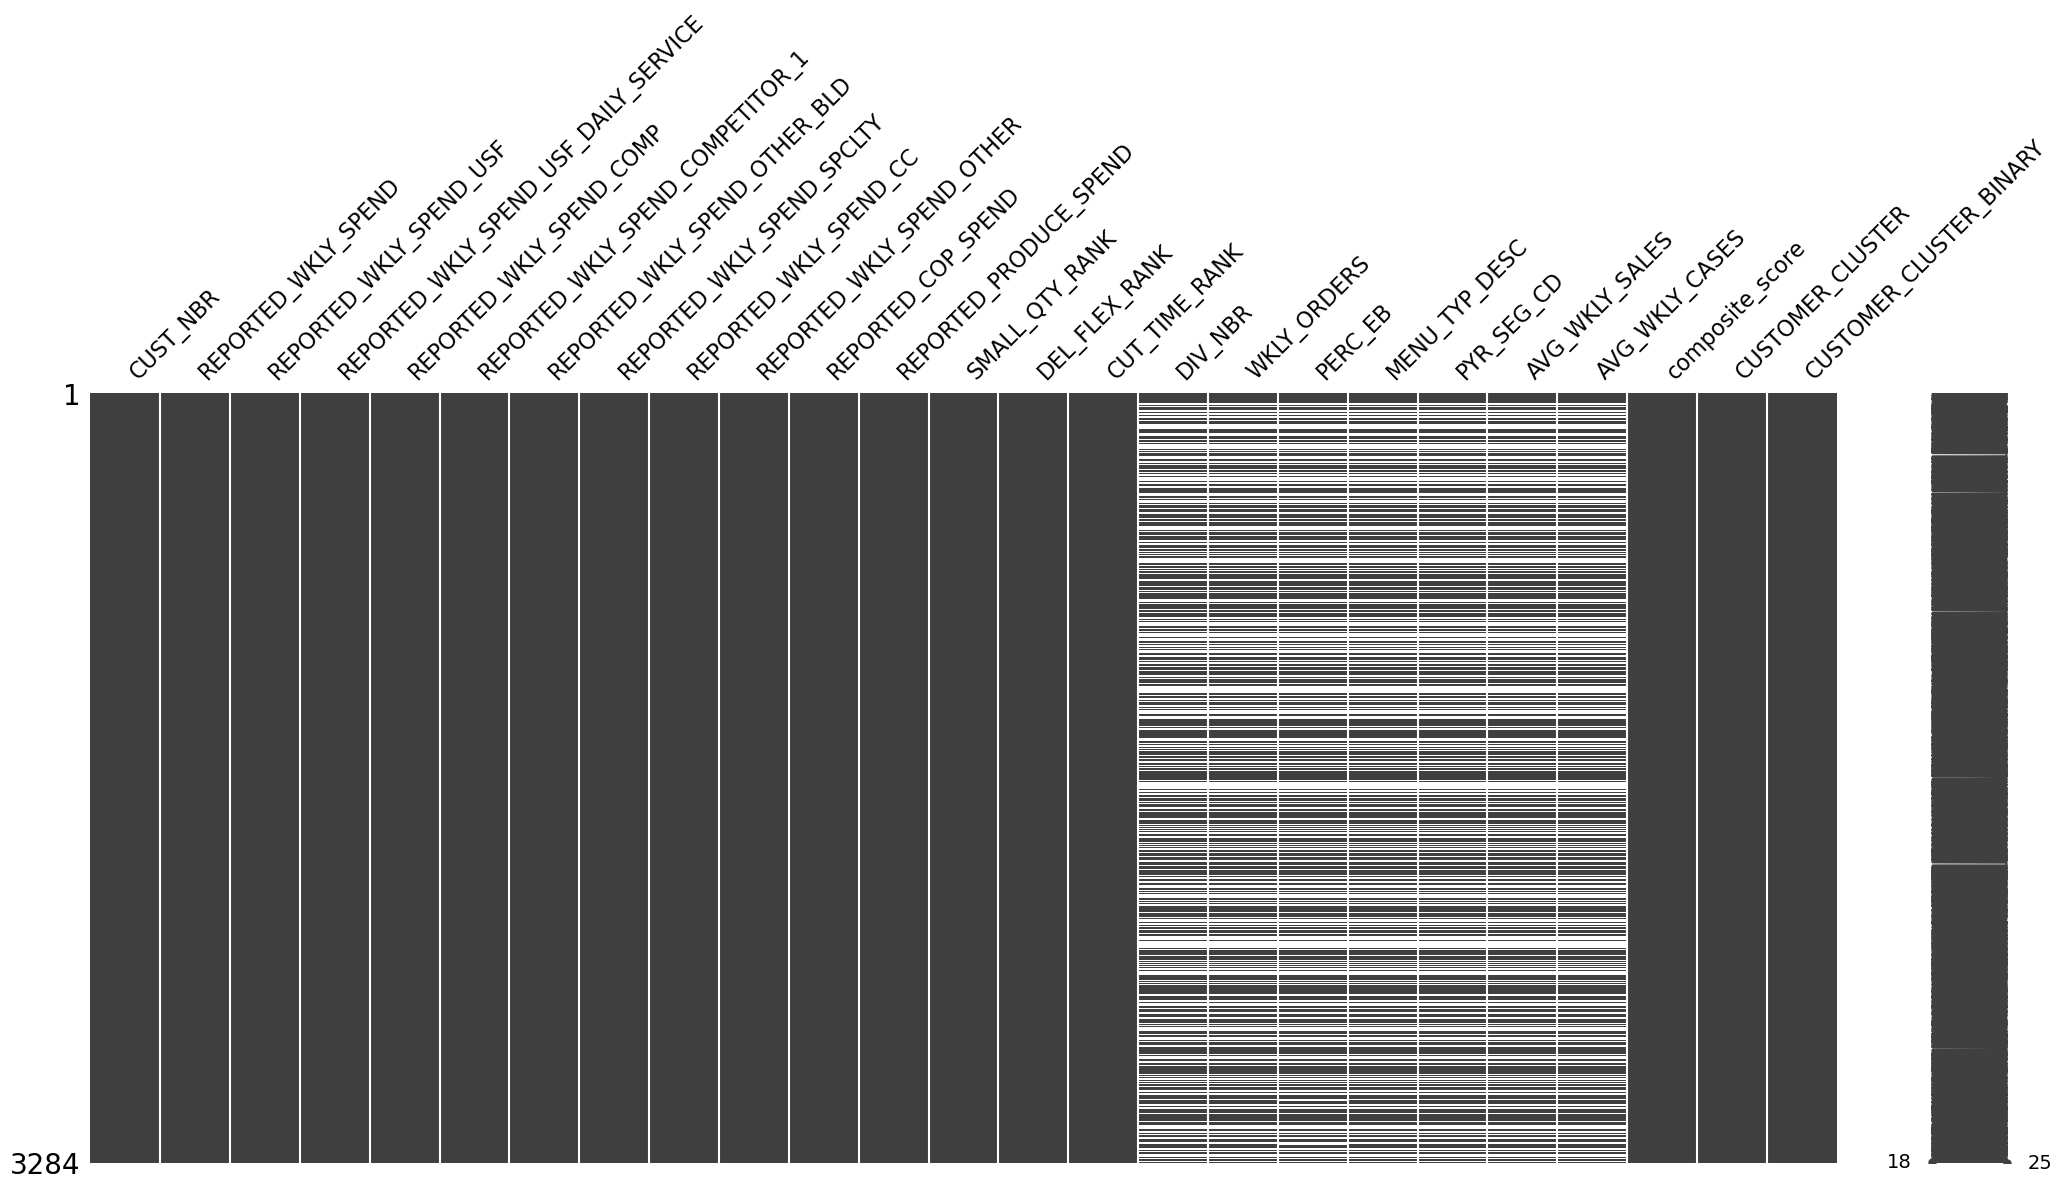

In [969]:
msno.matrix(df_train)

**For the rest of numerical columns with missing values, I will fillin using different strategy**

- For missing values less than 10%:
    - check missing value distribution in the column, is it MCAR or not?
    - check data distribution in the column
    - fillin with mean for columns with normal distribution
    - fillin with median for columns with skewed distribution
    - check if there is abnormal data distribution
    
- For missing values over 10%, check missing value distribution in the columns
    - if missing is MCAR: fillin with interpolation or regression based strategy
        - if column has good correlation with target label, used regression based strategy
        - if no good correlation, use interpolation to fillin
    - if missing is not MCAR: fillin with KNN
   

**Check the distribution of missing values in each numerical column to see if the missingness is MCAR (missing completely at random) or not**

In [970]:
num_col_with_missing = [col for col in df_train.columns if df_train[col].isnull().sum() > 0 ]

In [971]:
mcar_cols = []
non_mcar_cols = []

for col in num_col_with_missing:
    # Check if all values in the column are numeric
    if pd.api.types.is_numeric_dtype(df_train[col]):
        
        missing_percentages = df_train[col].isnull().sum() / len(df_train) * 100

        if missing_percentages == 0:
            continue
        elif missing_percentages == 100:
            non_mcar_cols.append(col)
        else:
            p_value = 1.0  # initialize p-value
            
            # Check MCAR by comparing original column with a column with missing 
            # values imputed using mean imputation
            col_imputed = df_train[col].fillna(df_train[col].mean())
            t_statistic, p_value = stats.ttest_ind(df_train[col].dropna(), col_imputed.dropna(), equal_var=False)
            
            if p_value < 0.05:
                non_mcar_cols.append(col)
            else:
                mcar_cols.append(col)
    else:
        print(f"Column {col} contains non-numeric values.")
    
print("MCAR columns:", mcar_cols)
print("Non-MCAR columns:", non_mcar_cols)

Column MENU_TYP_DESC contains non-numeric values.
Column PYR_SEG_CD contains non-numeric values.
MCAR columns: ['DIV_NBR', 'WKLY_ORDERS', 'PERC_EB', 'AVG_WKLY_SALES', 'AVG_WKLY_CASES']
Non-MCAR columns: []


* For all numerical columns with missing values, it appears that the missingness is Missing Completely at Random (MCAR). In cases where the missingness is severe, methods such as interpolation or regression-based imputation may be appropriate. On the other hand, if the missingness is relatively light, filling the missing values with the mean or median could be suitable.

In [972]:
num_col_heavy

[]

In [973]:
print(df_train.columns)

Index(['CUST_NBR', 'REPORTED_WKLY_SPEND', 'REPORTED_WKLY_SPEND_USF',
       'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE', 'REPORTED_WKLY_SPEND_COMP',
       'REPORTED_WKLY_SPEND_COMPETITOR_1', 'REPORTED_WKLY_SPEND_OTHER_BLD',
       'REPORTED_WKLY_SPEND_SPCLTY', 'REPORTED_WKLY_SPEND_CC',
       'REPORTED_WKLY_SPEND_OTHER', 'REPORTED_COP_SPEND',
       'REPORTED_PRODUCE_SPEND', 'SMALL_QTY_RANK', 'DEL_FLEX_RANK',
       'CUT_TIME_RANK', 'DIV_NBR', 'WKLY_ORDERS', 'PERC_EB', 'MENU_TYP_DESC',
       'PYR_SEG_CD', 'AVG_WKLY_SALES', 'AVG_WKLY_CASES', 'composite_score',
       'CUSTOMER_CLUSTER', 'CUSTOMER_CLUSTER_BINARY'],
      dtype='object')


- **check WKLY_ORDERS**

In [974]:
# Get value counts and percentage frequencies for column AMT_REQ_CREDIT_BUREAU_HOUR
value_counts = df_train['WKLY_ORDERS'].value_counts(dropna=False).sort_values(ascending=False).head(5)
percentages = (value_counts / len(df_train['WKLY_ORDERS'])) * 100

# Create resulting DataFrame
result = pd.DataFrame({'Count': value_counts, 'Percentage': percentages})
print(result)

             Count  Percentage
WKLY_ORDERS                   
NaN           1402   42.691839
1.000000       172    5.237515
1.500000        38    1.157125
2.000000        36    1.096224
1.333333        26    0.791717


In [975]:
#Check the distribution of the binary target label
target_dist = df_train['CUSTOMER_CLUSTER_BINARY'].value_counts(normalize=True)
print("high_value_customers distribution:\n", target_dist)

# Check the distribution of the binary target label within the dominant value 
dominant_value = df_train['WKLY_ORDERS'].mode().iloc[0]
dominant_value_dist = df_train.loc[df_train['WKLY_ORDERS'] == dominant_value, 'CUSTOMER_CLUSTER_BINARY'].value_counts(normalize=True)
print(f"\nhigh_value_customers distribution within dominant value ({dominant_value}):\n", dominant_value_dist)

high_value_customers distribution:
 CUSTOMER_CLUSTER_BINARY
0    0.691535
1    0.308465
Name: proportion, dtype: float64

high_value_customers distribution within dominant value (1.0):
 CUSTOMER_CLUSTER_BINARY
1    0.593023
0    0.406977
Name: proportion, dtype: float64


- **The distribution of the target label in the dominant value deviates from the base rate. Thus, I will retain this feature.**

- **check AVG_WKLY_SALES**

In [792]:
# Get value counts and percentage frequencies for column AMT_REQ_CREDIT_BUREAU_DAY
value_counts = df_train['AVG_WKLY_SALES'].value_counts(dropna=False).sort_values(ascending=False).head(5)
percentages = (value_counts / len(df_train['AVG_WKLY_SALES'])) * 100

# Create resulting DataFrame
result = pd.DataFrame({'Count': value_counts, 'Percentage': percentages})
print(result)

                Count  Percentage
AVG_WKLY_SALES                   
NaN              1403   42.722290
5164.419076         5    0.152253
5099.016203         4    0.121803
5656.803103         4    0.121803
6524.899439         4    0.121803


In [976]:
#Check the distribution of the binary target label
target_dist = df_train['CUSTOMER_CLUSTER_BINARY'].value_counts(normalize=True)
print("Target distribution:\n", target_dist)

# Check the distribution of the binary target label within the dominant value of AMT_REQ_CREDIT_BUREAU_DAY
dominant_value = df_train['AVG_WKLY_SALES'].mode().iloc[0]
dominant_value_dist = df_train.loc[df_train['AVG_WKLY_SALES'] == dominant_value, 'CUSTOMER_CLUSTER_BINARY'].value_counts(normalize=True)
print(f"\nhigh_value_customers distribution within dominant value ({dominant_value}):\n", dominant_value_dist)

Target distribution:
 CUSTOMER_CLUSTER_BINARY
0    0.691535
1    0.308465
Name: proportion, dtype: float64

high_value_customers distribution within dominant value (2257.48541):
 CUSTOMER_CLUSTER_BINARY
1    1.0
Name: proportion, dtype: float64


- **The distribution of the target label in the dominant value deviates from the base rate. Thus, I will retain this feature.**

- **check AVG_WKLY_CASES**

In [977]:
# Get value counts and percentage frequencies for column AMT_REQ_CREDIT_BUREAU_WEEK
value_counts = df_train['AVG_WKLY_CASES'].value_counts(dropna=False).sort_values(ascending=False).head(5)
percentages = (value_counts / len(df_train['AVG_WKLY_CASES'])) * 100

# Create resulting DataFrame
result = pd.DataFrame({'Count': value_counts, 'Percentage': percentages})
print(result)

#Check the distribution of the binary target label
target_dist = df_train['CUSTOMER_CLUSTER_BINARY'].value_counts(normalize=True)
print("Target distribution:\n", target_dist)

# Check the distribution of the binary target label within the dominant value of AMT_REQ_CREDIT_BUREAU_WEEK
dominant_value = df_train['AVG_WKLY_CASES'].mode().iloc[0]
dominant_value_dist = df_train.loc[df_train['AVG_WKLY_CASES'] == dominant_value, 'CUSTOMER_CLUSTER_BINARY'].value_counts(normalize=True)
print(f"\nhigh_value_customers distribution within dominant value ({dominant_value}):\n", dominant_value_dist)

                Count  Percentage
AVG_WKLY_CASES                   
NaN              1402   42.691839
128.371597          4    0.121803
42.095172           4    0.121803
151.918484          4    0.121803
91.324879           4    0.121803
Target distribution:
 CUSTOMER_CLUSTER_BINARY
0    0.691535
1    0.308465
Name: proportion, dtype: float64

high_value_customers distribution within dominant value (42.09517213):
 CUSTOMER_CLUSTER_BINARY
1    1.0
Name: proportion, dtype: float64


- **The distribution of the target label in the dominant value deviates from the base rate. Thus, I will retain this feature.**

In [978]:
df_train[['WKLY_ORDERS', 'AVG_WKLY_SALES', 'AVG_WKLY_CASES']].corr()

WKLY_ORDERS  AVG_WKLY_SALES  AVG_WKLY_CASES
WKLY_ORDERS        1.000000        0.253283        0.254325
AVG_WKLY_SALES     0.253283        1.000000        0.906198
AVG_WKLY_CASES     0.254325        0.906198        1.000000

**So I decise to fill 'Numerical columns with good correlation' by regression based interpolation.**
* By fitting a regression model using the correlated columns as predictors, we can impute the missing values based on the relationships observed in the data. This approach leverages the information from the other columns to make accurate predictions for the missing values.

In [979]:
corr_columns

[]

In [980]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

def fillna_with_regression(df, corr_columns):
    for col in corr_columns:
        # Create a copy of the dataframe without missing values in the correlated columns
        data = df.dropna(subset=corr_columns)
        
        # Skip column if there are no missing values
        if data[col].isnull().sum() == 0:
            continue
        
        # Split the data into features (X) and target variable (y)
        X = data.drop(col, axis=1)
        y = data[col]
        
        # Impute missing values in X
        imputer = SimpleImputer()
        X_imputed = imputer.fit_transform(X)
        
        # Create a linear regression model
        model = LinearRegression()
        
        # Fit the model on the available data
        model.fit(X_imputed, y)
        
        # Predict the missing values based on the other columns
        missing_data = df[df[col].isnull()].drop(col, axis=1)
        if missing_data.empty:
            continue
        missing_data_imputed = imputer.transform(missing_data)
        predicted_values = model.predict(missing_data_imputed)
        
        # Fill the missing values with the predicted values
        df.loc[df[col].isnull(), col] = predicted_values
    
    return df

# Fill missing values using linear regression
df_train_filled = fillna_with_regression(df_train[numerical_features], corr_columns)


**we will fillin with mean for normal distributed columns and median for skewed columns.**

In [981]:
# Filter only numeric columns
num_col_heavy = [col for col in num_col_heavy if np.issubdtype(df_train[col].dtype, np.number)]

# Then calculate skewness
num_col_heavy_normal = [col for col in num_col_heavy if abs(df_train[col].skew()) < 0.5]
num_col_heavy_skew = [col for col in num_col_heavy if abs(df_train[col].skew()) >= 0.5]

print('Normal columns:', num_col_heavy_normal)
print('Skewed columns:', num_col_heavy_skew)

Normal columns: []
Skewed columns: []


In [982]:
# fill missing values in num_col_heavy_normal with mean
df_train[num_col_heavy_normal] = df_train[num_col_heavy_normal].fillna(df_train[num_col_heavy_normal].mean())

# fill missing values in num_col_heavy_skew with median
df_train[num_col_heavy_skew] = df_train[num_col_heavy_skew].fillna(df_train[num_col_heavy_skew].median())

In [983]:
# check if we still have missing values in the dataset
df_train.isnull().sum().sum()

9816

<AxesSubplot:>

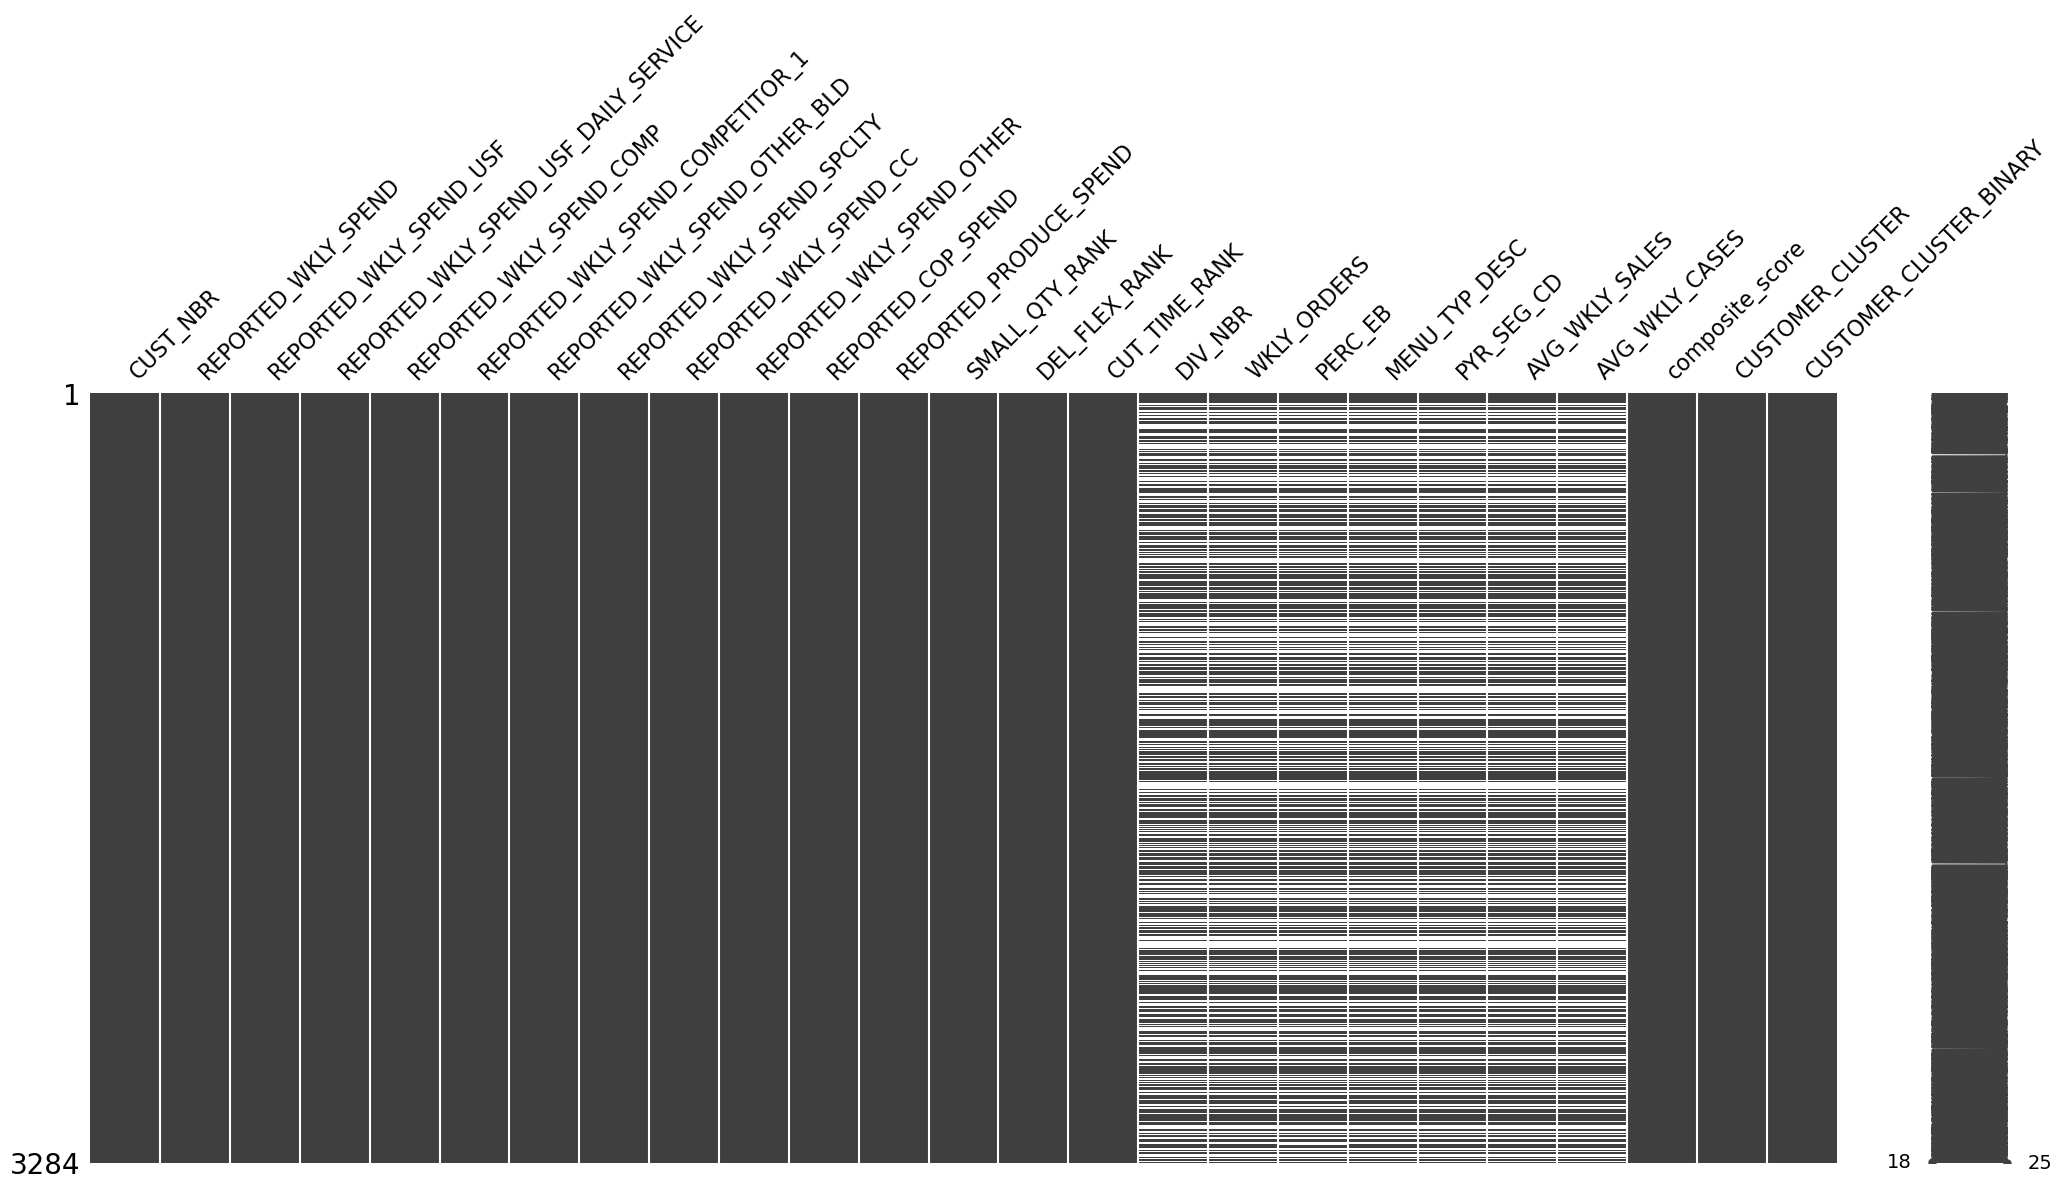

In [984]:
msno.matrix(df_train)

### Summary of missing value fill-in for numerical columns:

Feature names	Missing
(filling strategy)	Distribution	
DIV_NBR	43.1% (unknown)	Normal
	
WKLY_ORDERS	43.1% (median)	Skewed	
PERC_EB	43.1% (median)	Normal
	
MENU_TYP_DESC	43.1%	-	
PYR_SEG_CD	43.1%	-	
AVG_WKLY_SALES	43.1% (median)	Skewed
	
AVG_WKLY_CASES	43.1% (median)	Skewed
	


### Distribution of data in numerical columns 

In [985]:
num_col_train = df_train.select_dtypes(['int64','float64']).columns.to_list()
cat_col_train = df_train.select_dtypes(['object']).columns.to_list()

print('cat_col : {} \n\
num_col : {}'.format(len(cat_col_train), len(num_col_train)))

cat_col : 3 
num_col : 22


In [986]:
df_train[num_col_train].head()

CUST_NBR  REPORTED_WKLY_SPEND  REPORTED_WKLY_SPEND_USF  \
3185     22730           540.083654               540.083654   
1766     23474          7501.000000                 1.000000   
3699     76594           213.320385               213.320385   
2135    121706          1818.949231              1418.949231   
3946      7958          1566.530385                66.530385   

      REPORTED_WKLY_SPEND_USF_DAILY_SERVICE  REPORTED_WKLY_SPEND_COMP  \
3185                             540.083654                       0.0   
1766                            3151.000000                    7500.0   
3699                             213.320385                       0.0   
2135                            1418.949231                     400.0   
3946                              66.530385                    1500.0   

      REPORTED_WKLY_SPEND_COMPETITOR_1  REPORTED_WKLY_SPEND_OTHER_BLD  \
3185                               0.0                            0.0   
1766                               0.0                         3000.0   
3699                               0.0                            0.0   
2135                               0.0                            0.0   
3946                               0.0                            0.0   

      REPORTED_WKLY_SPEND_SPCLTY  REPORTED_WKLY_SPEND_CC  \
3185                         0.0                     0.0   
1766                      2500.0                  2000.0   
3699                         0.0                     0.0   
2135                         0.0                     0.0   
3946                         0.0                     0.0   

      REPORTED_WKLY_SPEND_OTHER  REPORTED_COP_SPEND  REPORTED_PRODUCE_SPEND  \
3185                        0.0                 0.0                     0.0   
1766                        0.0                 0.0                  1250.0   
3699                        0.0                 0.0                     0.0   
2135                      400.0               600.0                   300.0   
3946                     1500.0                 0.0                     0.0   

      SMALL_QTY_RANK  DEL_FLEX_RANK  CUT_TIME_RANK  DIV_NBR  WKLY_ORDERS  \
3185               0              0              0     31.0     1.380952   
1766              10              5              4      NaN          NaN   
3699               0              0              0     15.0     1.000000   
2135               5              4             10      6.0     1.600000   
3946               2              1              3      2.0     1.000000   

       PERC_EB  AVG_WKLY_SALES  AVG_WKLY_CASES  composite_score  \
3185  0.454714     6231.725484      139.802826        -1.978184   
1766       NaN             NaN             NaN         2.417290   
3699  0.640000     4641.351795      104.523608        -2.584256   
2135  0.684360     3958.490958       96.480630         2.830938   
3946  0.487805     4224.473141      100.757418        -1.862878   

      CUSTOMER_CLUSTER_BINARY  
3185                        1  
1766                        0  
3699                        1  
2135                        0  
3946                        0

**Check the data distribution of numerical columns with missing values**

In [987]:
# Let's check data distribution and see if the above grouping make sense or not
num_col_train

['CUST_NBR',
 'REPORTED_WKLY_SPEND',
 'REPORTED_WKLY_SPEND_USF',
 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE',
 'REPORTED_WKLY_SPEND_COMP',
 'REPORTED_WKLY_SPEND_COMPETITOR_1',
 'REPORTED_WKLY_SPEND_OTHER_BLD',
 'REPORTED_WKLY_SPEND_SPCLTY',
 'REPORTED_WKLY_SPEND_CC',
 'REPORTED_WKLY_SPEND_OTHER',
 'REPORTED_COP_SPEND',
 'REPORTED_PRODUCE_SPEND',
 'SMALL_QTY_RANK',
 'DEL_FLEX_RANK',
 'CUT_TIME_RANK',
 'DIV_NBR',
 'WKLY_ORDERS',
 'PERC_EB',
 'AVG_WKLY_SALES',
 'AVG_WKLY_CASES',
 'composite_score',
 'CUSTOMER_CLUSTER_BINARY']

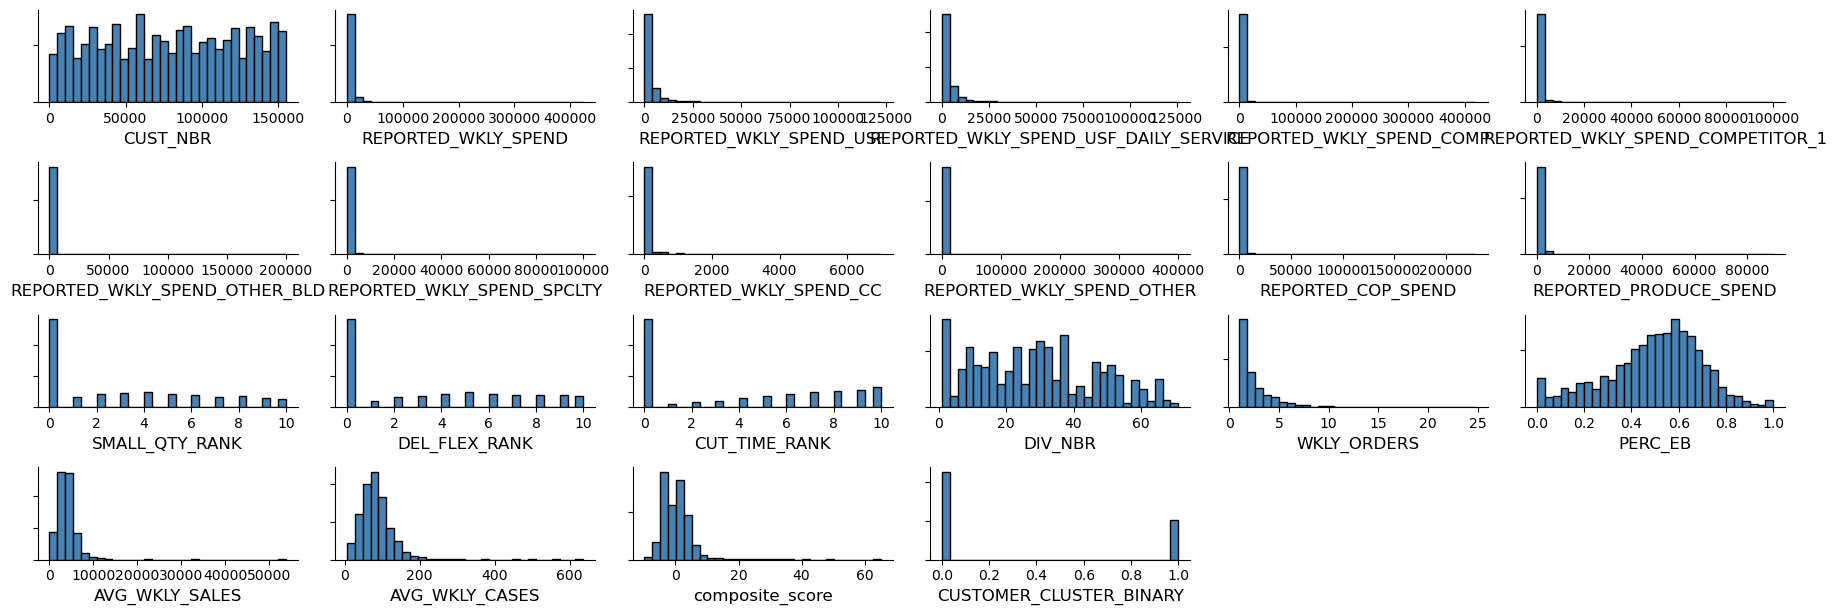

In [988]:
import matplotlib.pyplot as plt

def plot_histograms(df, num_columns, n_rows=10, n_cols=7, figsize=(18, 18)):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(num_columns):
        ax = axes[i]
        ax.hist(df[col], bins=30, color='steelblue', edgecolor='black')
        ax.tick_params(axis='both', which='both', labelsize=10)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel(col, fontsize=12)
        ax.set_yticklabels([])  # Remove y-axis tick labels

    # Remove empty subplots
    if len(num_columns) < len(axes):
        for j in range(len(num_columns), len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Plot histograms of numerical columns in a 7x10 grid layout
plot_histograms(df_train, num_col_train, n_rows=12, n_cols=6)

### Check distribution of target label y in numerical features

In [989]:
df_train[num_col_train].head()

CUST_NBR  REPORTED_WKLY_SPEND  REPORTED_WKLY_SPEND_USF  \
3185     22730           540.083654               540.083654   
1766     23474          7501.000000                 1.000000   
3699     76594           213.320385               213.320385   
2135    121706          1818.949231              1418.949231   
3946      7958          1566.530385                66.530385   

      REPORTED_WKLY_SPEND_USF_DAILY_SERVICE  REPORTED_WKLY_SPEND_COMP  \
3185                             540.083654                       0.0   
1766                            3151.000000                    7500.0   
3699                             213.320385                       0.0   
2135                            1418.949231                     400.0   
3946                              66.530385                    1500.0   

      REPORTED_WKLY_SPEND_COMPETITOR_1  REPORTED_WKLY_SPEND_OTHER_BLD  \
3185                               0.0                            0.0   
1766                               0.0                         3000.0   
3699                               0.0                            0.0   
2135                               0.0                            0.0   
3946                               0.0                            0.0   

      REPORTED_WKLY_SPEND_SPCLTY  REPORTED_WKLY_SPEND_CC  \
3185                         0.0                     0.0   
1766                      2500.0                  2000.0   
3699                         0.0                     0.0   
2135                         0.0                     0.0   
3946                         0.0                     0.0   

      REPORTED_WKLY_SPEND_OTHER  REPORTED_COP_SPEND  REPORTED_PRODUCE_SPEND  \
3185                        0.0                 0.0                     0.0   
1766                        0.0                 0.0                  1250.0   
3699                        0.0                 0.0                     0.0   
2135                      400.0               600.0                   300.0   
3946                     1500.0                 0.0                     0.0   

      SMALL_QTY_RANK  DEL_FLEX_RANK  CUT_TIME_RANK  DIV_NBR  WKLY_ORDERS  \
3185               0              0              0     31.0     1.380952   
1766              10              5              4      NaN          NaN   
3699               0              0              0     15.0     1.000000   
2135               5              4             10      6.0     1.600000   
3946               2              1              3      2.0     1.000000   

       PERC_EB  AVG_WKLY_SALES  AVG_WKLY_CASES  composite_score  \
3185  0.454714     6231.725484      139.802826        -1.978184   
1766       NaN             NaN             NaN         2.417290   
3699  0.640000     4641.351795      104.523608        -2.584256   
2135  0.684360     3958.490958       96.480630         2.830938   
3946  0.487805     4224.473141      100.757418        -1.862878   

      CUSTOMER_CLUSTER_BINARY  
3185                        1  
1766                        0  
3699                        1  
2135                        0  
3946                        0

**plot the distribution of data in either 0 or 1 group for each numerical columns**

[Text(0.5, 0, '')]

Text(0, 0.5, 'CUST_NBR')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_USF')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_COMP')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_COMPETITOR_1')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_OTHER_BLD')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_SPCLTY')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_CC')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_OTHER')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_COP_SPEND')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_PRODUCE_SPEND')

[Text(0.5, 0, '')]

Text(0, 0.5, 'SMALL_QTY_RANK')

[Text(0.5, 0, '')]

Text(0, 0.5, 'DEL_FLEX_RANK')

[Text(0.5, 0, '')]

Text(0, 0.5, 'CUT_TIME_RANK')

[Text(0.5, 0, '')]

Text(0, 0.5, 'DIV_NBR')

[Text(0.5, 0, '')]

Text(0, 0.5, 'WKLY_ORDERS')

[Text(0.5, 0, '')]

Text(0, 0.5, 'PERC_EB')

[Text(0.5, 0, '')]

Text(0, 0.5, 'AVG_WKLY_SALES')

[Text(0.5, 0, '')]

Text(0, 0.5, 'AVG_WKLY_CASES')

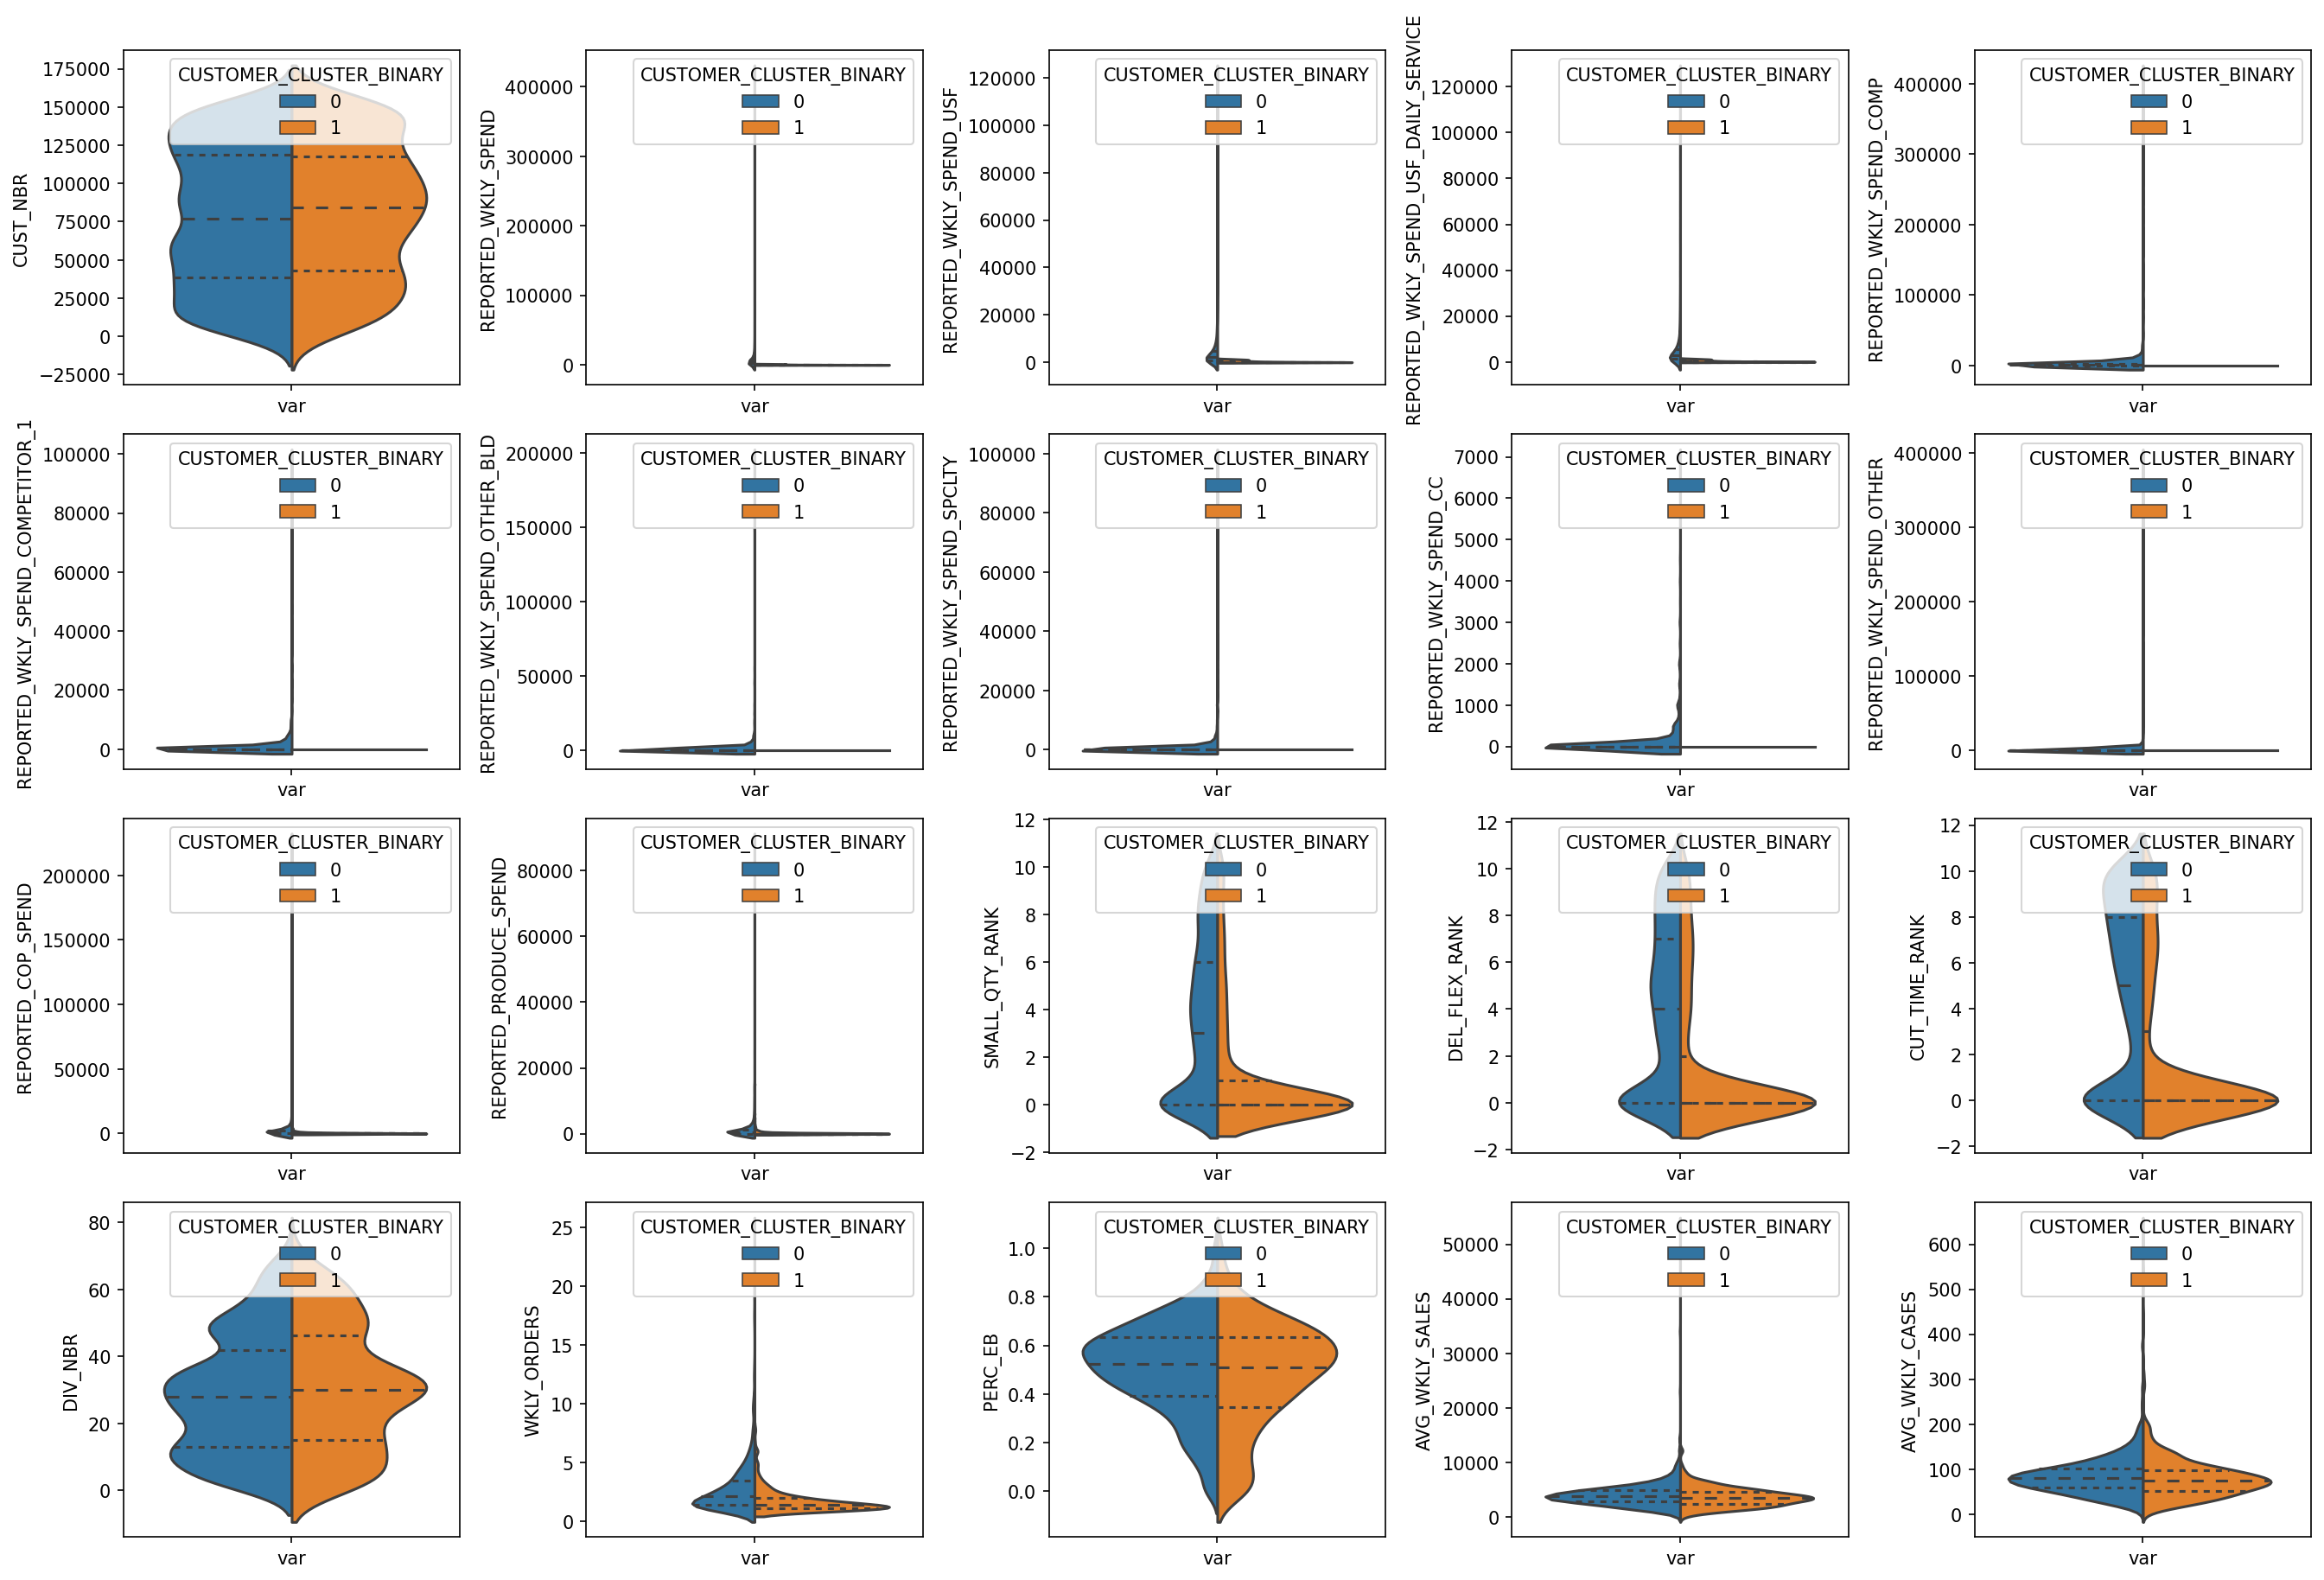

In [990]:
num_df = df_train[num_col_train].copy()
num_df['var'] = 'var'
nrows = 4  
ncols = 5  
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 12), dpi=150)
for r in range(nrows):
    for c in range(ncols):
        i = r * ncols + c  # index of the current column
        if i >= len(num_col_train):  # check if we've reached the end of the columns
            break
        ax = sns.violinplot(x='var', y=num_col_train[i], data=num_df, hue='CUSTOMER_CLUSTER_BINARY', split=True, inner='quart', ax=axes[r, c])
        ax.set(xlabel=None)
        ax.set_ylabel(f'{num_col_train[i]}', fontsize=10)
        ax.tick_params(labelsize=10)

plt.tight_layout()

**use ttest to calculate if there is significant difference in the distribution**

[Text(0.5, 0, '')]

Text(0, 0.5, 'CUST_NBR')

Text(0.5, 0.9, 'p = 0.0227')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_USF')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_COMP')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_COMPETITOR_1')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_OTHER_BLD')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_SPCLTY')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_CC')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_OTHER')

Text(0.5, 0.9, 'p = 0.0002')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_COP_SPEND')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_PRODUCE_SPEND')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'SMALL_QTY_RANK')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'DEL_FLEX_RANK')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'CUT_TIME_RANK')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'DIV_NBR')

[Text(0.5, 0, '')]

Text(0, 0.5, 'WKLY_ORDERS')

[Text(0.5, 0, '')]

Text(0, 0.5, 'PERC_EB')

[Text(0.5, 0, '')]

Text(0, 0.5, 'AVG_WKLY_SALES')

[Text(0.5, 0, '')]

Text(0, 0.5, 'AVG_WKLY_CASES')

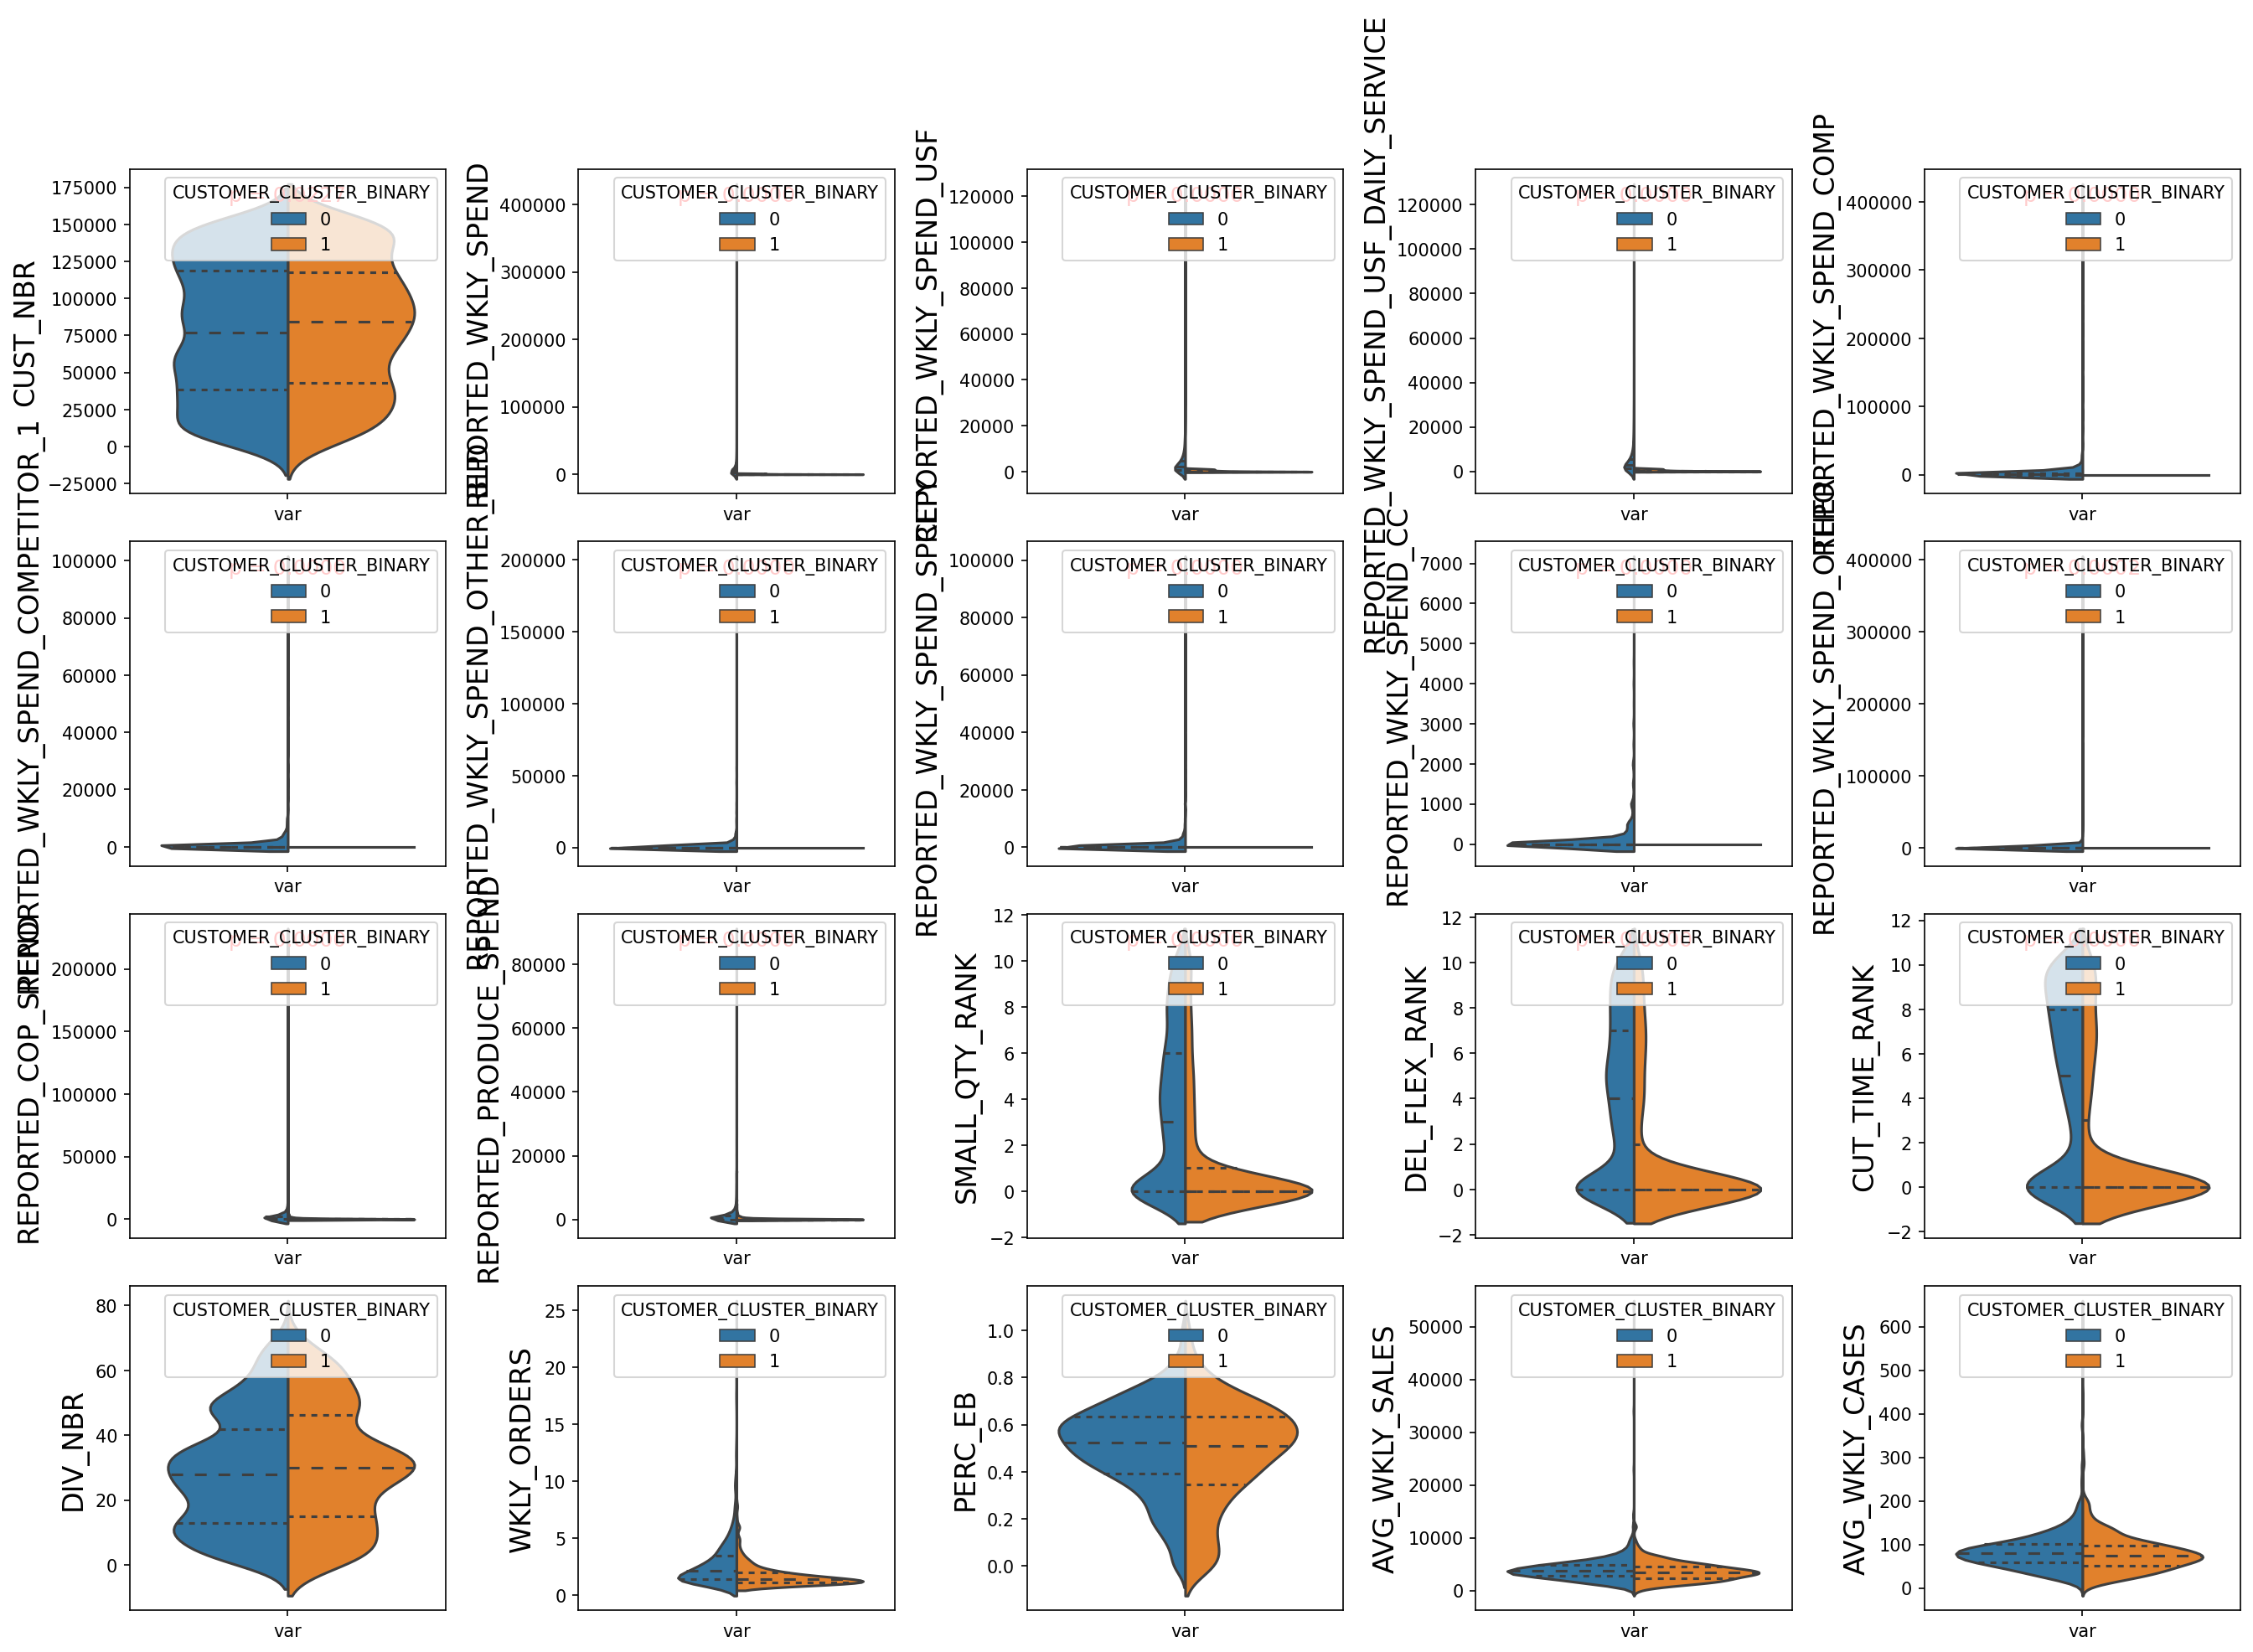

In [992]:
from scipy.stats import ttest_ind
num_df = df_train[num_col_train].copy()
num_df['var'] = 'var'
nrows = 4  
ncols = 5  
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 12), dpi=150)

for r in range(nrows):
    for c in range(ncols):
        i = r * ncols + c  # index of the current column
        if i >= len(num_col_train):  # check if we've reached the end of the columns
            break
        ax = sns.violinplot(x='var', y=num_col_train[i], data=num_df, hue='CUSTOMER_CLUSTER_BINARY', split=True, inner='quart', ax=axes[r, c])
        ax.set(xlabel=None)
        ax.set_ylabel(f'{num_col_train[i]}', fontsize=16)
        ax.tick_params(labelsize=10)

        # perform two-sample t-test
        x0 = df_train.loc[df_train['CUSTOMER_CLUSTER_BINARY'] == 0, num_col_train[i]].values
        x1 = df_train.loc[df_train['CUSTOMER_CLUSTER_BINARY'] == 1, num_col_train[i]].values
        t, p = ttest_ind(x0, x1, equal_var=False)
        if p < 0.05:  # if p-value is less than 0.05, annotate the plot with the p-value
            ax.text(0.5, 0.9, f'p = {p:.4f}', transform=ax.transAxes, ha='center', fontsize=12, color='red')

plt.tight_layout()

**use Mann-Whitney U test to calculate if there is significant difference in the distribution**

[Text(0.5, 0, '')]

Text(0, 0.5, 'CUST_NBR')

Text(0.5, 0.9, 'p = 0.0266')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_USF')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_COMP')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_COMPETITOR_1')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_OTHER_BLD')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_SPCLTY')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_CC')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_WKLY_SPEND_OTHER')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_COP_SPEND')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'REPORTED_PRODUCE_SPEND')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'SMALL_QTY_RANK')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'DEL_FLEX_RANK')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'CUT_TIME_RANK')

Text(0.5, 0.9, 'p = 0.0000')

[Text(0.5, 0, '')]

Text(0, 0.5, 'DIV_NBR')

[Text(0.5, 0, '')]

Text(0, 0.5, 'WKLY_ORDERS')

[Text(0.5, 0, '')]

Text(0, 0.5, 'PERC_EB')

[Text(0.5, 0, '')]

Text(0, 0.5, 'AVG_WKLY_SALES')

[Text(0.5, 0, '')]

Text(0, 0.5, 'AVG_WKLY_CASES')

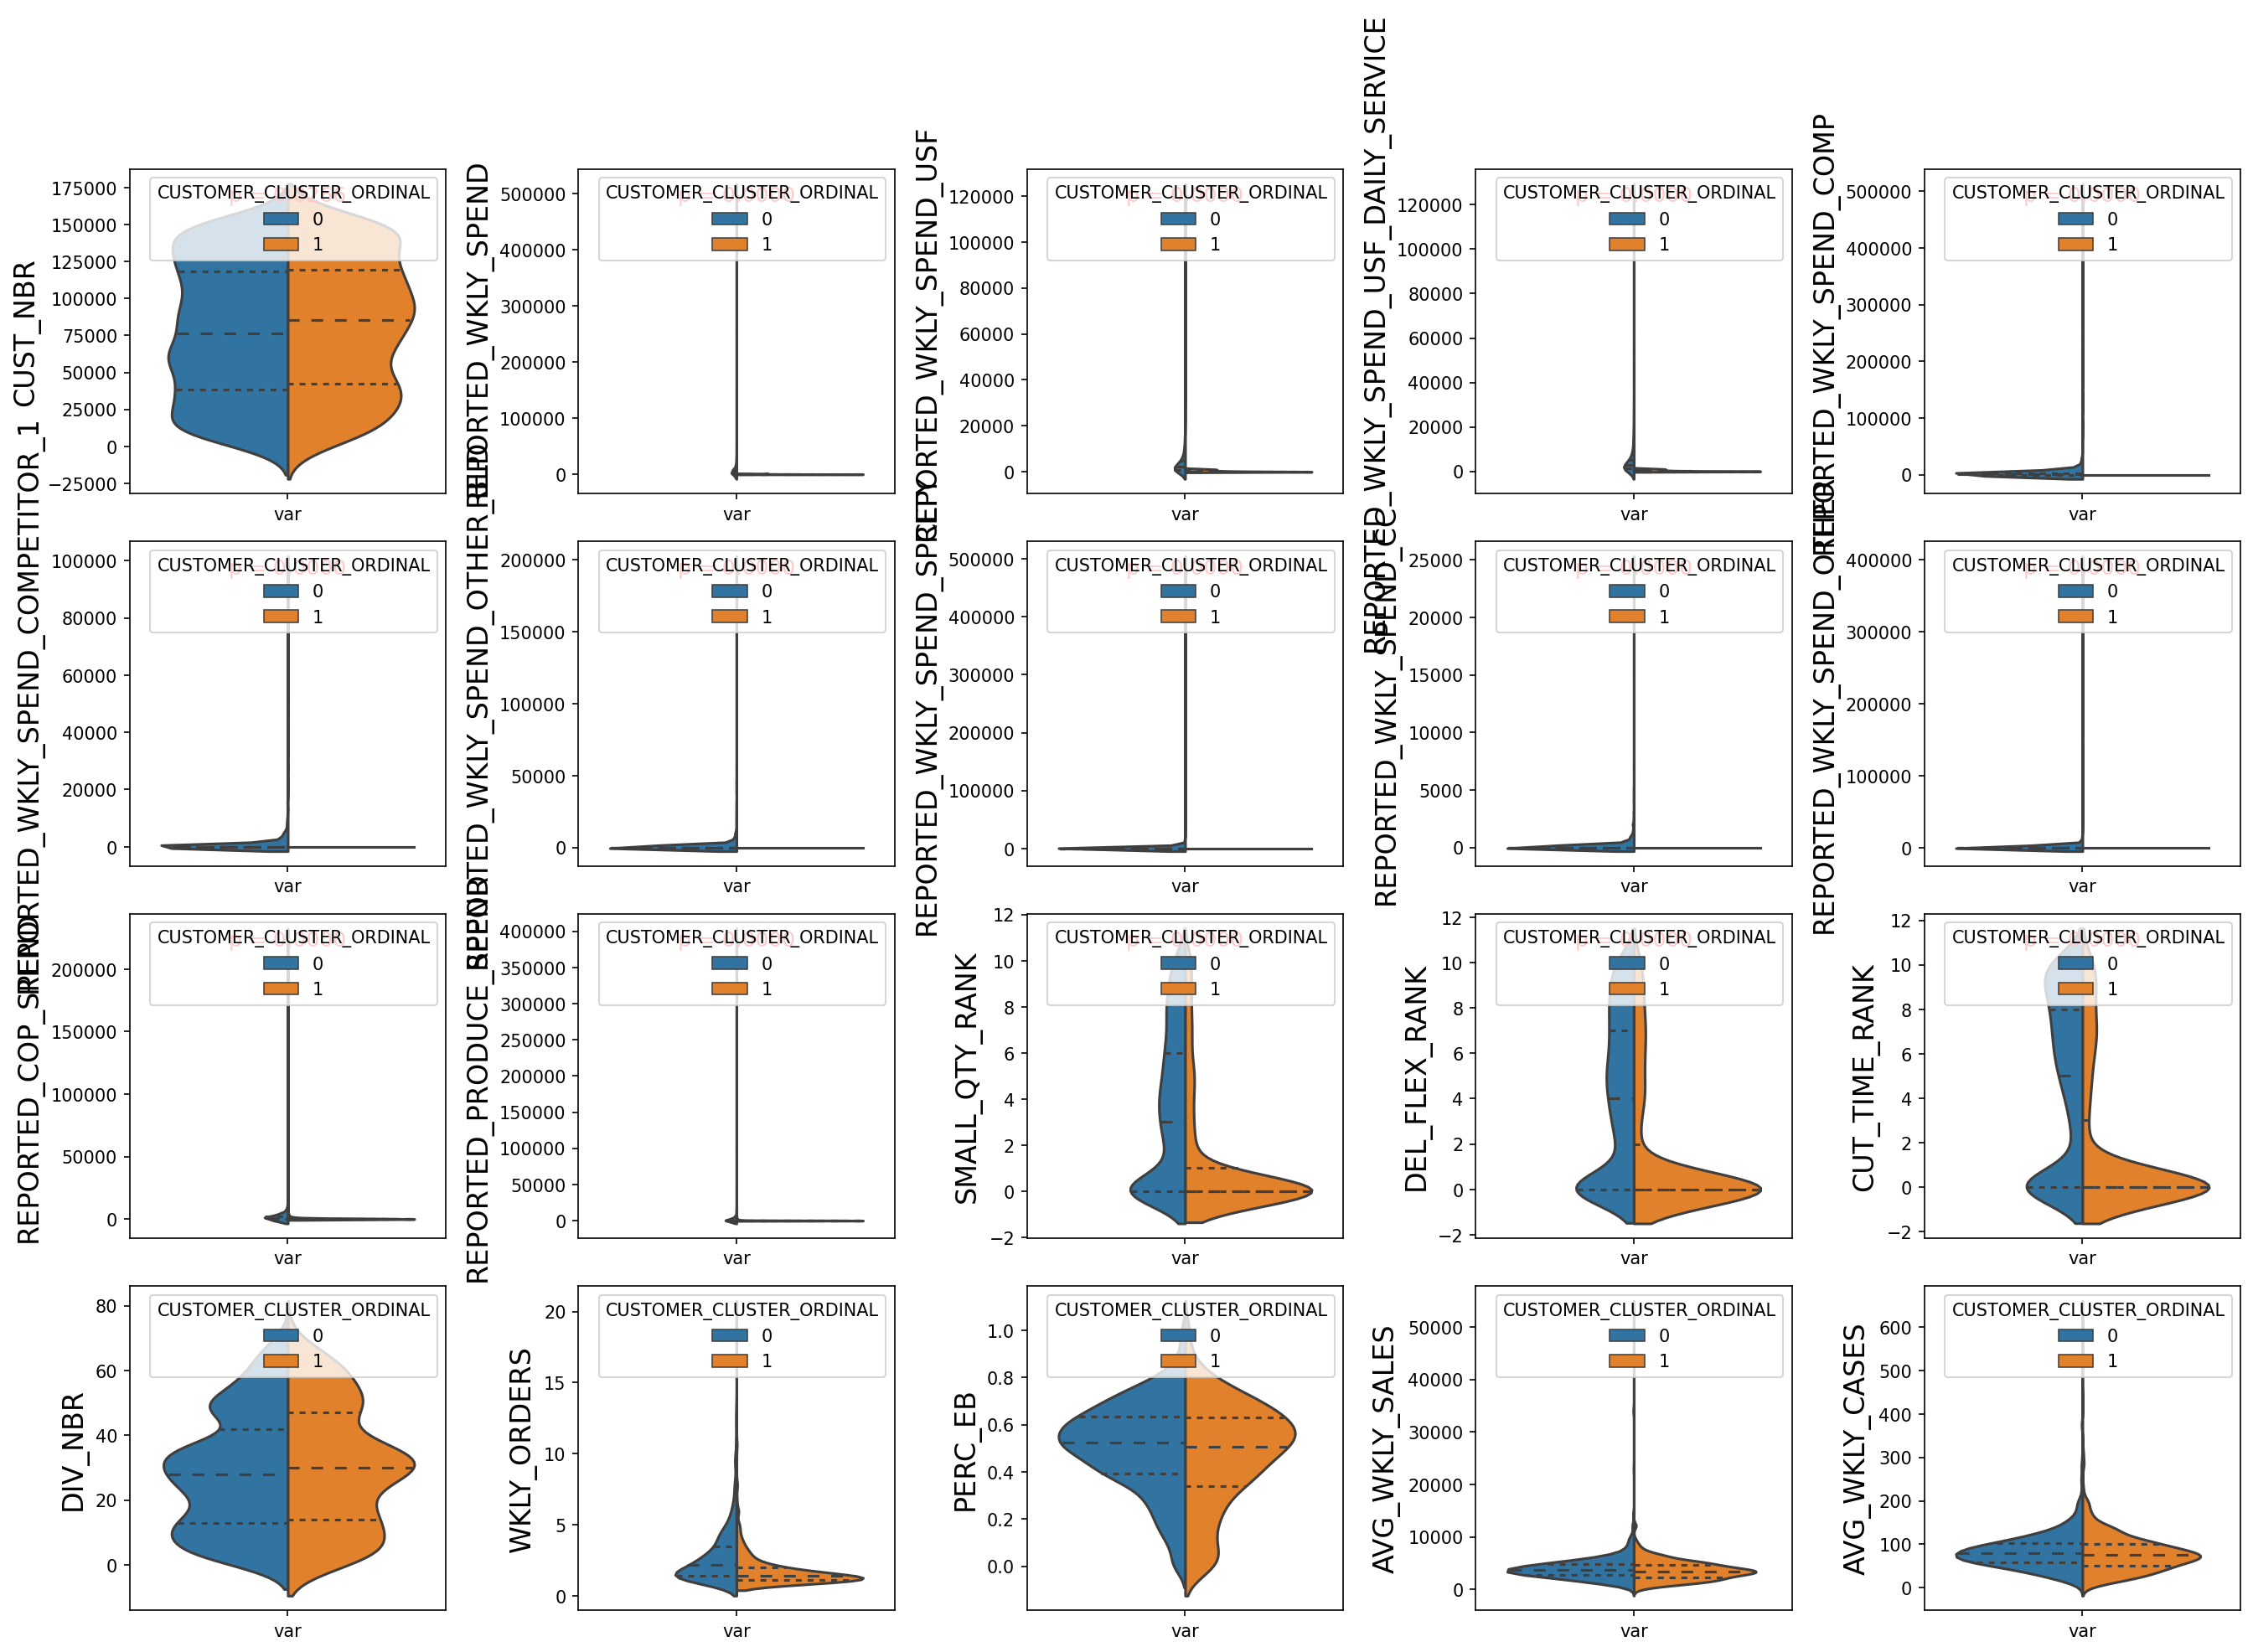

In [821]:
from scipy.stats import mannwhitneyu

num_df = df_train[num_col_train].copy()
num_df['var'] = 'var'
nrows = 4  
ncols = 5  
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 12), dpi=150)

for r in range(nrows):
    for c in range(ncols):
        i = r * ncols + c  # index of the current column
        if i >= len(num_col_train):  # check if we've reached the end of the columns
            break
        ax = sns.violinplot(x='var', y=num_col_train[i], data=num_df, hue='CUSTOMER_CLUSTER_ORDINAL', split=True, inner='quart', ax=axes[r, c])
        ax.set(xlabel=None)
        ax.set_ylabel(f'{num_col_train[i]}', fontsize=16)
        ax.tick_params(labelsize=10)

        # perform Mann-Whitney U test
        x0 = df_train.loc[df_train['CUSTOMER_CLUSTER_ORDINAL'] == 0, num_col_train[i]].values
        x1 = df_train.loc[df_train['CUSTOMER_CLUSTER_ORDINAL'] == 1, num_col_train[i]].values
        stat, p = mannwhitneyu(x0, x1, alternative='two-sided')
        if p < 0.05:  # if p-value is less than 0.05, annotate the plot with the p-value
            ax.text(0.5, 0.9, f'p = {p:.4f}', transform=ax.transAxes, ha='center', fontsize=12, color='red')

plt.tight_layout()


**We found that in the majority of numerical columns, the distribution of data differs between the "0" and "1" groups of the target label (high_value_customers = 1).**
* This indicates that these columns may play a significant role in predicting the target label. 
* To further analyze their importance, we can employ statistical methods such as Pearson correlation and Variance Inflation Factor (VIF), or algorithm-based strategies like Recursive Feature Elimination with Cross-Validation (RFECV). 
* These techniques will aid in identifying and eliminating columns that are not useful for modeling. By reducing the dimensionality of the dataset and enhancing model interpretability, we can improve the effectiveness of our modeling process.

<a id='Data_Quality'></a>
<h2 style="color:blue">Multivariate Analysis</h2>

### Pearson correlation and VIF analysis of numerical columns

<Figure size 1000x700 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Correlation Heatmap of Numerical Columns')

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5]),
 [Text(0.5, 0, 'CUST_NBR'),
  Text(1.5, 0, 'REPORTED_WKLY_SPEND'),
  Text(2.5, 0, 'REPORTED_WKLY_SPEND_USF'),
  Text(3.5, 0, 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE'),
  Text(4.5, 0, 'REPORTED_WKLY_SPEND_COMP'),
  Text(5.5, 0, 'REPORTED_WKLY_SPEND_COMPETITOR_1'),
  Text(6.5, 0, 'REPORTED_WKLY_SPEND_OTHER_BLD'),
  Text(7.5, 0, 'REPORTED_WKLY_SPEND_SPCLTY'),
  Text(8.5, 0, 'REPORTED_WKLY_SPEND_CC'),
  Text(9.5, 0, 'REPORTED_WKLY_SPEND_OTHER'),
  Text(10.5, 0, 'REPORTED_COP_SPEND'),
  Text(11.5, 0, 'REPORTED_PRODUCE_SPEND'),
  Text(12.5, 0, 'SMALL_QTY_RANK'),
  Text(13.5, 0, 'DEL_FLEX_RANK'),
  Text(14.5, 0, 'CUT_TIME_RANK'),
  Text(15.5, 0, 'DIV_NBR'),
  Text(16.5, 0, 'WKLY_ORDERS'),
  Text(17.5, 0, 'PERC_EB'),
  Text(18.5, 0, 'AVG_WKLY_SALES'),
  Text(19.5, 0, 'AVG_WKLY_CASES'),
  Text(20.5, 0, 'composite_score'),
  Text(21.5, 0, 'CUSTOMER_

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5]),
 [Text(0, 0.5, 'CUST_NBR'),
  Text(0, 1.5, 'REPORTED_WKLY_SPEND'),
  Text(0, 2.5, 'REPORTED_WKLY_SPEND_USF'),
  Text(0, 3.5, 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE'),
  Text(0, 4.5, 'REPORTED_WKLY_SPEND_COMP'),
  Text(0, 5.5, 'REPORTED_WKLY_SPEND_COMPETITOR_1'),
  Text(0, 6.5, 'REPORTED_WKLY_SPEND_OTHER_BLD'),
  Text(0, 7.5, 'REPORTED_WKLY_SPEND_SPCLTY'),
  Text(0, 8.5, 'REPORTED_WKLY_SPEND_CC'),
  Text(0, 9.5, 'REPORTED_WKLY_SPEND_OTHER'),
  Text(0, 10.5, 'REPORTED_COP_SPEND'),
  Text(0, 11.5, 'REPORTED_PRODUCE_SPEND'),
  Text(0, 12.5, 'SMALL_QTY_RANK'),
  Text(0, 13.5, 'DEL_FLEX_RANK'),
  Text(0, 14.5, 'CUT_TIME_RANK'),
  Text(0, 15.5, 'DIV_NBR'),
  Text(0, 16.5, 'WKLY_ORDERS'),
  Text(0, 17.5, 'PERC_EB'),
  Text(0, 18.5, 'AVG_WKLY_SALES'),
  Text(0, 19.5, 'AVG_WKLY_CASES'),
  Text(0, 20.5, 'composite_score'),
  Text(0, 21.5, 'CUSTOMER_

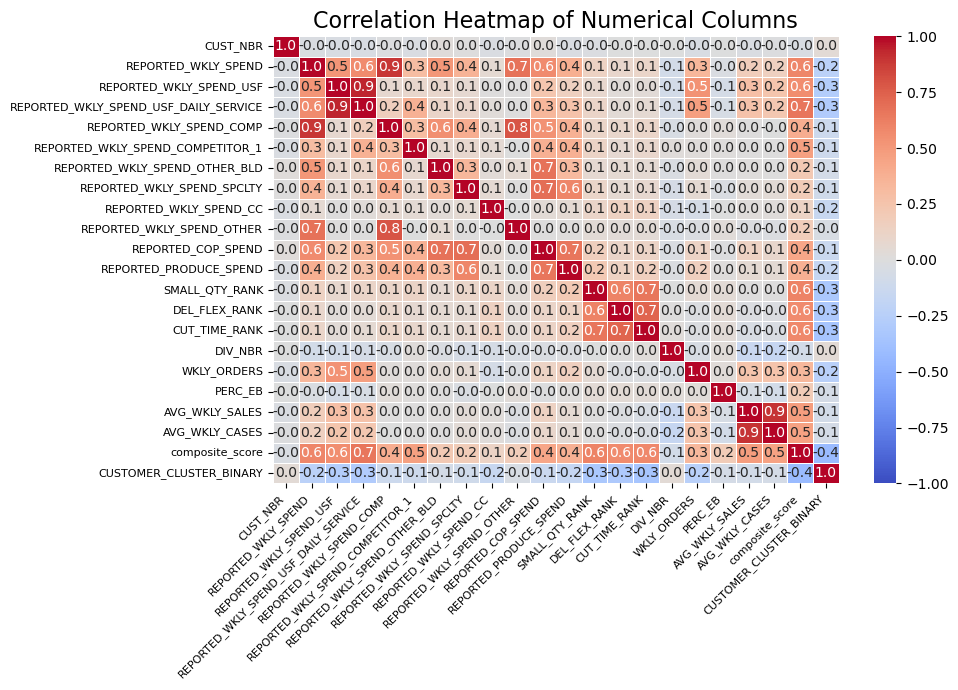

In [993]:
plt.figure(figsize=(10, 7))
sns.heatmap(df_train[num_col_train].corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=True, fmt=".1f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Columns", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

<AxesSubplot:>

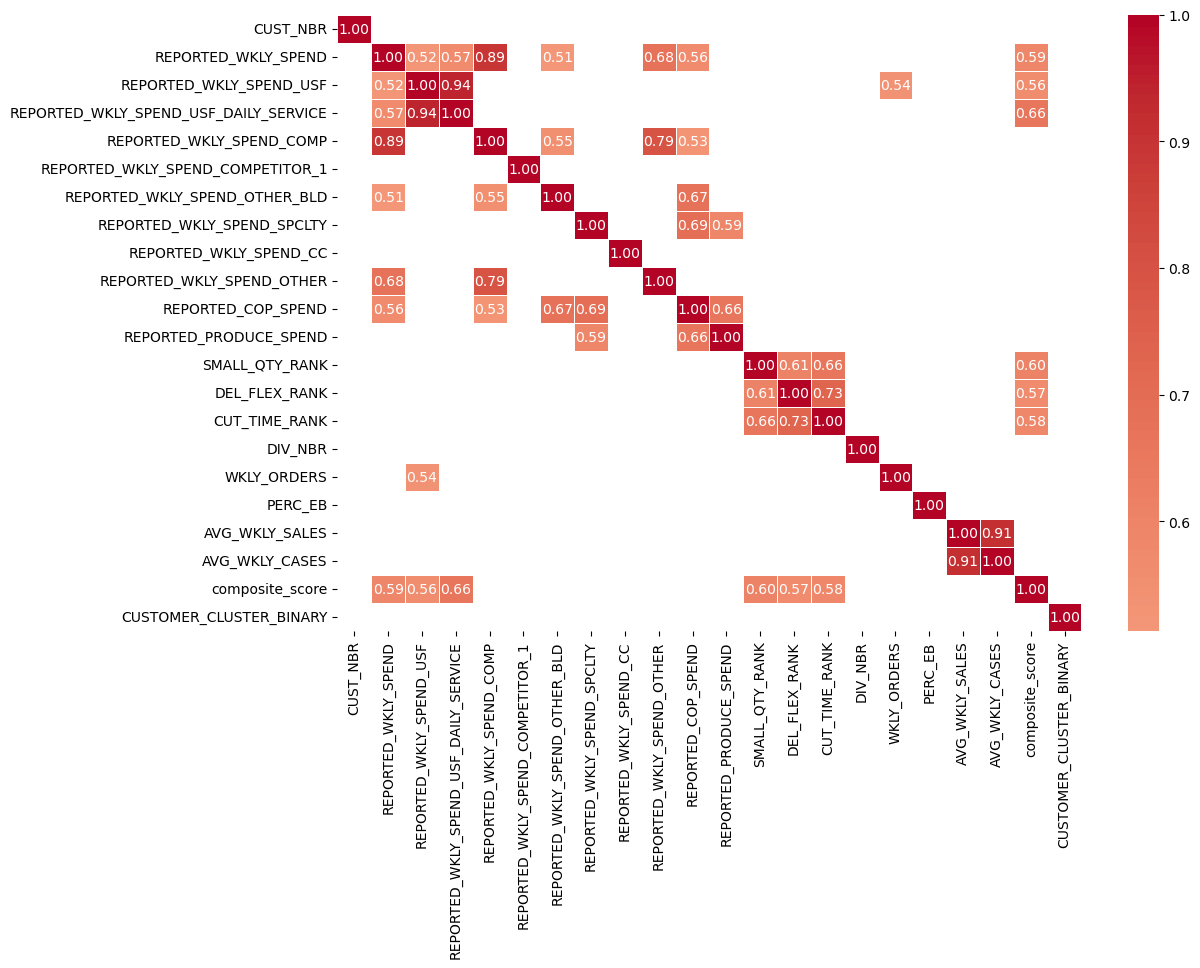

In [994]:
# Compute the correlation matrix
corr = df_train[num_col_train].corr()

# Create a mask to hide the correlations below the threshold
mask = np.abs(corr) < 0.5

# Create a heatmap with the masked correlation matrix
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, annot=True, fmt=".2f", linewidth=.5,
           annot_kws={"size": 10, "color": "white"})
plt.show()

**Let's calculate the VIF score and used VIF score to eliminate columns showing high multicollinearity.**

In [995]:
df_train[num_col_train].isnull().sum()

CUST_NBR                                    0
REPORTED_WKLY_SPEND                         0
REPORTED_WKLY_SPEND_USF                     0
REPORTED_WKLY_SPEND_USF_DAILY_SERVICE       0
REPORTED_WKLY_SPEND_COMP                    0
REPORTED_WKLY_SPEND_COMPETITOR_1            0
REPORTED_WKLY_SPEND_OTHER_BLD               0
REPORTED_WKLY_SPEND_SPCLTY                  0
REPORTED_WKLY_SPEND_CC                      0
REPORTED_WKLY_SPEND_OTHER                   0
REPORTED_COP_SPEND                          0
REPORTED_PRODUCE_SPEND                      0
SMALL_QTY_RANK                              0
DEL_FLEX_RANK                               0
CUT_TIME_RANK                               0
DIV_NBR                                  1402
WKLY_ORDERS                              1402
PERC_EB                                  1404
AVG_WKLY_SALES                           1402
AVG_WKLY_CASES                           1402
composite_score                             0
CUSTOMER_CLUSTER_BINARY           

In [996]:
# Impute missing values with mean for each column
df_num_imputed = df_num.fillna(df_num.mean())

# Calculate VIF for each imputed numerical column
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_num_imputed.values, i) for i in range(df_num_imputed.shape[1])]
vif["Features"] = df_num_imputed.columns

# Filter for high VIF columns
vif_high = vif[vif['VIF Factor'] > 5].sort_values(by='VIF Factor', ascending=False).reset_index(drop=True)

# Print the high VIF columns
print("Features with VIF > 5:")
print(vif_high)

Features with VIF > 5:
      VIF Factor                               Features
0   1.801440e+15                 REPORTED_WKLY_SPEND_CC
1   1.585775e+13             REPORTED_WKLY_SPEND_SPCLTY
2   1.165226e+13          REPORTED_WKLY_SPEND_OTHER_BLD
3   6.627814e+12               REPORTED_WKLY_SPEND_COMP
4   3.004403e+12              REPORTED_WKLY_SPEND_OTHER
5   2.212527e+12       REPORTED_WKLY_SPEND_COMPETITOR_1
6   2.085145e+11                    REPORTED_WKLY_SPEND
7   1.191849e+10                REPORTED_WKLY_SPEND_USF
8   7.872532e+01                         AVG_WKLY_SALES
9   7.653925e+01                         AVG_WKLY_CASES
10  4.332955e+01  REPORTED_WKLY_SPEND_USF_DAILY_SERVICE
11  8.133153e+00                 REPORTED_PRODUCE_SPEND
12  5.164654e+00                          CUT_TIME_RANK


- **VIF starts at 1 and has no upper limit**
- **VIF = 1, no correlation between the independent variable and the other variables**
- **VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others**

Variance Inflation Factor (VIF) is a measure of how much the variance of an estimated regression coefficient is increased due to multicollinearity in the data. If there's no multicollinearity, then the VIFs will be close to 1.

Features with high VIF indicate they are highly correlated with other features in the dataset. When VIF is greater than 10, it suggests strong multicollinearity with other independent variables, which can undermine the statistical significance of the coefficient estimate and make interpretation tricky.

Let's interpret the given output:

1. **REPORTED_WKLY_SPEND_CC**: This variable has a VIF of approximately \(1.80 \times 10^{15}\), which is an extremely high value, suggesting it is highly collinear with one or more of the other variables. You should consider excluding it or combining it with other variables to reduce its VIF.

2. **REPORTED_WKLY_SPEND_SPCLTY** to **REPORTED_WKLY_SPEND_USF**: These features have VIF values ranging from \(10^{10}\) to \(10^{13}\). This suggests that these features are also highly collinear with other predictors.

3. **AVG_WKLY_SALES** and **AVG_WKLY_CASES**: These features have VIFs around 78, which, while lower than the previously mentioned features, are still above the common threshold of 10, indicating multicollinearity issues.

4. **REPORTED_WKLY_SPEND_USF_DAILY_SERVICE**: This variable has a VIF of 43.32, indicating some multicollinearity, though less severe than the earlier variables.

### Recommendations:

1. **Feature Engineering:** Consider combining features or creating new features that better represent the underlying relationships.
   
2. **Exclude Features:** Based on domain knowledge, you might want to exclude some of the features that are redundant.
   
3. **Regularization Techniques:** Consider using regularization techniques like Ridge or Lasso regression that penalize certain model parameters if they're likely to cause overfitting.
   
4. **Principal Component Analysis (PCA):** This can be used to transform the original variables into a new set of variables that are orthogonal (uncorrelated), and then you can use these new variables for modeling.

5. **Correlation Analysis:** Before removing variables based solely on VIF, check pairwise correlations to understand which variables are driving the multicollinearity.

In conclusion, high VIF values suggest that predictors are correlated and might not be giving you independent information. Dealing with multicollinearity can help improve model interpretability and reduce overfitting.

<Figure size 1500x700 with 0 Axes>

<AxesSubplot:>

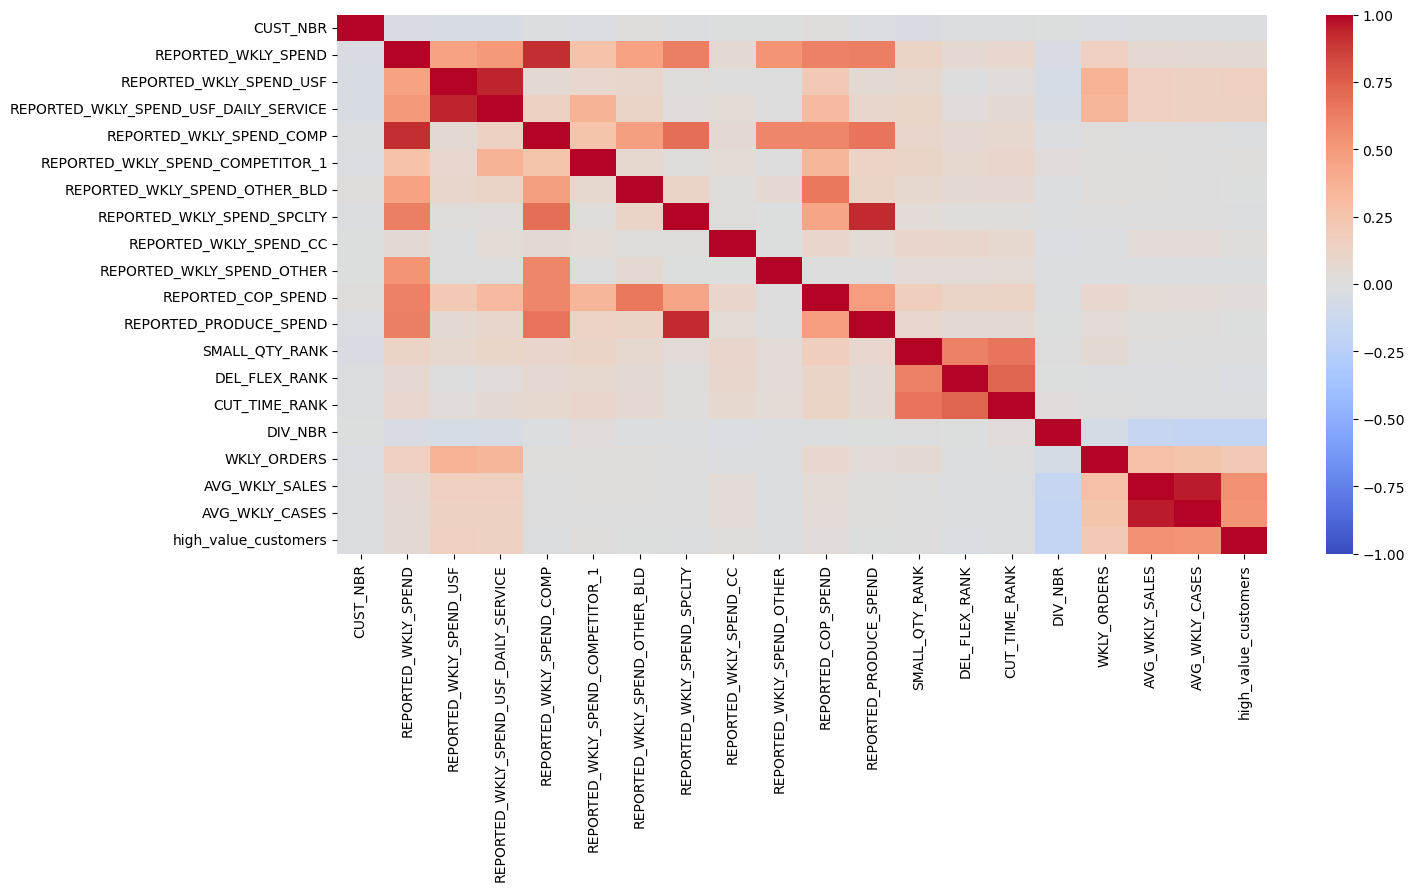

In [997]:
# This assumes df_num_imputed is a list of column names
plt.figure(figsize=(15, 7))
sns.heatmap(df_num_imputed.corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

### PhiK analysis of categorical columns

In [998]:
from scipy import stats
import phik
from phik import resources, report

In [999]:
cat_col_train
num_col_train

['MENU_TYP_DESC', 'PYR_SEG_CD', 'CUSTOMER_CLUSTER']

['CUST_NBR',
 'REPORTED_WKLY_SPEND',
 'REPORTED_WKLY_SPEND_USF',
 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE',
 'REPORTED_WKLY_SPEND_COMP',
 'REPORTED_WKLY_SPEND_COMPETITOR_1',
 'REPORTED_WKLY_SPEND_OTHER_BLD',
 'REPORTED_WKLY_SPEND_SPCLTY',
 'REPORTED_WKLY_SPEND_CC',
 'REPORTED_WKLY_SPEND_OTHER',
 'REPORTED_COP_SPEND',
 'REPORTED_PRODUCE_SPEND',
 'SMALL_QTY_RANK',
 'DEL_FLEX_RANK',
 'CUT_TIME_RANK',
 'DIV_NBR',
 'WKLY_ORDERS',
 'PERC_EB',
 'AVG_WKLY_SALES',
 'AVG_WKLY_CASES',
 'composite_score',
 'CUSTOMER_CLUSTER_BINARY']

In [1000]:
col_phik = num_col_train + cat_col_train

In [1001]:
col_phik

['CUST_NBR',
 'REPORTED_WKLY_SPEND',
 'REPORTED_WKLY_SPEND_USF',
 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE',
 'REPORTED_WKLY_SPEND_COMP',
 'REPORTED_WKLY_SPEND_COMPETITOR_1',
 'REPORTED_WKLY_SPEND_OTHER_BLD',
 'REPORTED_WKLY_SPEND_SPCLTY',
 'REPORTED_WKLY_SPEND_CC',
 'REPORTED_WKLY_SPEND_OTHER',
 'REPORTED_COP_SPEND',
 'REPORTED_PRODUCE_SPEND',
 'SMALL_QTY_RANK',
 'DEL_FLEX_RANK',
 'CUT_TIME_RANK',
 'DIV_NBR',
 'WKLY_ORDERS',
 'PERC_EB',
 'AVG_WKLY_SALES',
 'AVG_WKLY_CASES',
 'composite_score',
 'CUSTOMER_CLUSTER_BINARY',
 'MENU_TYP_DESC',
 'PYR_SEG_CD',
 'CUSTOMER_CLUSTER']

interval columns not set, guessing: ['CUST_NBR', 'REPORTED_WKLY_SPEND', 'REPORTED_WKLY_SPEND_USF', 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE', 'REPORTED_WKLY_SPEND_COMP', 'REPORTED_WKLY_SPEND_COMPETITOR_1', 'REPORTED_WKLY_SPEND_OTHER_BLD', 'REPORTED_WKLY_SPEND_SPCLTY', 'REPORTED_WKLY_SPEND_CC', 'REPORTED_WKLY_SPEND_OTHER', 'REPORTED_COP_SPEND', 'REPORTED_PRODUCE_SPEND', 'SMALL_QTY_RANK', 'DEL_FLEX_RANK', 'CUT_TIME_RANK', 'DIV_NBR', 'WKLY_ORDERS', 'PERC_EB', 'AVG_WKLY_SALES', 'AVG_WKLY_CASES', 'composite_score', 'CUSTOMER_CLUSTER_BINARY']


<AxesSubplot:>

Text(0.5, 1.0, 'Phik test for all features')

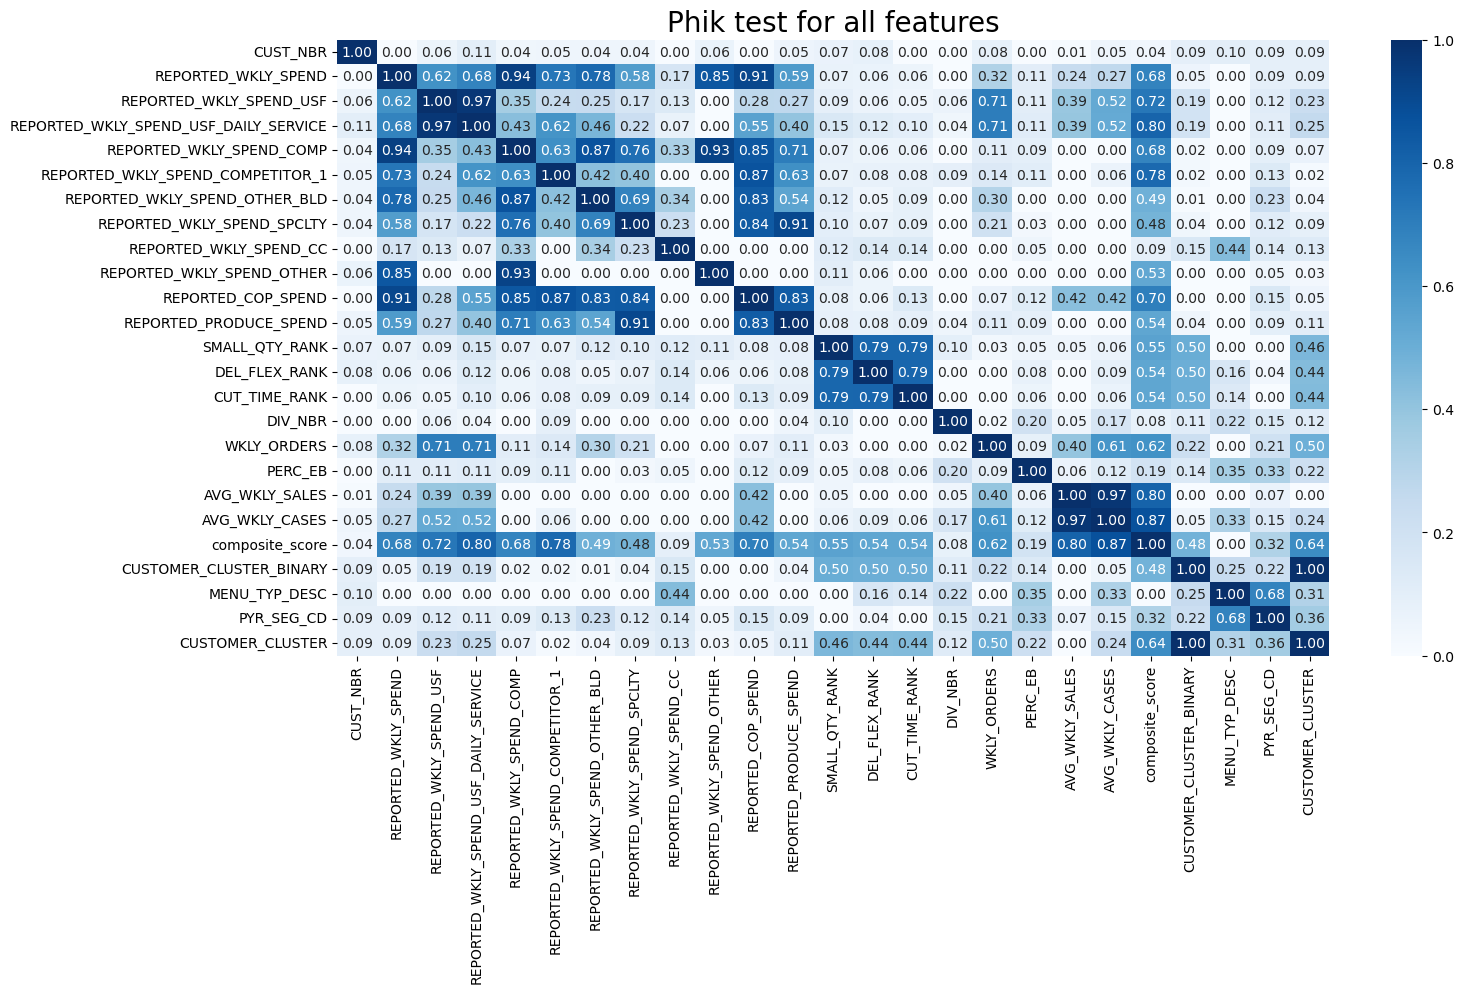

In [1002]:
result = df_train[col_phik].phik_matrix()

fig = plt.figure(figsize=(16, 8))
sns.heatmap(result, annot=True, cmap='Blues', fmt=".2f")

plt.title('Phik test for all features', fontsize=20)
plt.show()

**I decide to keep all features in the model as there is no high correlation between two or three feature, as well as relative weak correlation with potential customers.

In [184]:
# for col in ['DIV_NBR']:
#    col_phik.remove(col)

In [1003]:
# col_phik

In [186]:
# df_train_stat = df_train.loc[:, col_phik]

In [366]:
# df_train_stat.info()

**Let's generate the new dataset with selected columns and save it**

In [358]:
# let save the dataset
# df_train_stat.to_csv('df_train_filled_stat.csv', index = False)
# df_train_stat.head()

### Feature selection using Recursive Feature Elimination with cross validationb (RFECV)

**To encode the categorical data, we will use ordinal encoding for the 'NAME_EDUCATION_TYPE' column and dummy encoding for the rest of the columns.**

In [848]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [1004]:
placeholder = 'MISSING_VALUE'
df_train['MENU_TYP_DESC'].fillna(placeholder, inplace=True)

In [1014]:
encoder = OneHotEncoder(categories=[
    [
        'MISSING_VALUE', 'BAR & GRILL', 'MT UNAVAILABLE', 'SEAFOOD & FISH', 'STEAK & SEAFOOD',
        'VARIED MENU', 'HAMBURGERS', 'AMERICAN', 'JAPANESE', 'ITALIAN- PIZZA & PASTA',
        'FUSION / ECLECTIC INTERNATIONAL', 'SANDWICHES / SOUPS / SALADS',
        'BARBECUE', 'CHINESE', 'BRAZILIAN', 'MEXICAN', 'FRIED CHICKEN',
        'SOUTHERN & SOUL', 'COFFEE / TEA', 'SMOOTHIE / JUICE', 'EUROPEAN',
        'FROZEN DESSERTS', 'AMERICAN TRADITIONAL', 'PIZZERIA', 'FRENCH',
        'CHICKEN WINGS', 'BAKERIES / DONUTS / SNACKS', 'DELI', 'GREEK', 'DONUTS',
        'AFRICAN', 'SOUTHWESTERN/ TEX-MEX', 'MEDITERRANEAN', 'OTHER LATIN AMERICA',
        'SPANISH, TAPAS', 'OTHER ASIAN (CAMBODGIA, MALAYSIA, INDONESIA, ...)',
        'PUB / BREW PUB', 'HAWAIIAN', 'SNACKS', 'SANDWICHES',
        'INDIAN/ PAKISTANI/ BANGLADESHI / SRI LANKAN', 'BAKERY CAFE', 'CARIBBEAN',
        'BAGELS', 'KOREAN', 'CLASSIC MENU UNCLASSIFIED', 'CLASSIC MENU',
        'FAMILY STEAK', 'HOT DOGS', 'THAI','ASIAN', 'SOUTH & CENTRAL AMERICA/ CARIBBEAN'
    ]
    ])

In [1007]:
df_train['MENU_TYP_DESC'].head()

3185    ITALIAN- PIZZA & PASTA
1766             MISSING_VALUE
3699               VARIED MENU
2135            MT UNAVAILABLE
3946                  AMERICAN
Name: MENU_TYP_DESC, dtype: object

In [843]:
cat_col_temp = ['PYR_SEG_CD']

In [844]:
df_train_dummy = pd.get_dummies(df_train, columns=cat_col_temp)

In [845]:
df_train_dummy.head()

CUST_NBR  REPORTED_WKLY_SPEND  REPORTED_WKLY_SPEND_USF  \
3034    132098           855.227308               855.227308   
1029     70117          2045.129231               445.129231   
106     124563         15449.528460             15449.528460   
937      91927          1282.586731              1282.586731   
2175    111933          2230.170577               730.170577   

      REPORTED_WKLY_SPEND_USF_DAILY_SERVICE  REPORTED_WKLY_SPEND_COMP  \
3034                             855.227308                       0.0   
1029                            1305.129231                    1600.0   
106                            15449.528460                       0.0   
937                             1282.586731                       0.0   
2175                            1180.170577                    1500.0   

      REPORTED_WKLY_SPEND_COMPETITOR_1  REPORTED_WKLY_SPEND_OTHER_BLD  \
3034                               0.0                            0.0   
1029                               0.0                          900.0   
106                                0.0                            0.0   
937                                0.0                            0.0   
2175                               0.0                            0.0   

      REPORTED_WKLY_SPEND_SPCLTY  REPORTED_WKLY_SPEND_CC  \
3034                         0.0                     0.0   
1029                       700.0                     0.0   
106                          0.0                     0.0   
937                          0.0                     0.0   
2175                      1000.0                   500.0   

      REPORTED_WKLY_SPEND_OTHER  REPORTED_COP_SPEND  REPORTED_PRODUCE_SPEND  \
3034                        0.0                 0.0                     0.0   
1029                        0.0               650.0                  1500.0   
106                         0.0             17500.0                  2500.0   
937                         0.0               600.0                   300.0   
2175                        0.0               700.0                   900.0   

      SMALL_QTY_RANK  DEL_FLEX_RANK  CUT_TIME_RANK  DIV_NBR  WKLY_ORDERS  \
3034               0              0              0     64.0     1.903226   
1029               6              4              3      NaN          NaN   
106                3              7              4     32.0     1.800000   
937                8              7              9     33.0     3.259259   
2175               8              4              3      NaN          NaN   

       PERC_EB   MENU_TYP_DESC  AVG_WKLY_SALES  AVG_WKLY_CASES  \
3034  0.767938     VARIED MENU     2379.455144       65.952940   
1029       NaN   MISSING_VALUE             NaN             NaN   
106   0.082942  MT UNAVAILABLE     5232.933452      137.541821   
937   0.392161     VARIED MENU     6180.161692      132.422698   
2175       NaN   MISSING_VALUE             NaN             NaN   

      composite_score  CUSTOMER_CLUSTER  CUSTOMER_CLUSTER_ORDINAL  \
3034        -3.533614                 1                         1   
1029         0.002099                 2                         0   
106          4.251854                 2                         0   
937          4.539694                 1                         1   
2175         0.637711                 2                         0   

      PYR_SEG_CD_Education  PYR_SEG_CD_Government  PYR_SEG_CD_Health Care  \
3034                 False                  False                   False   
1029                 False                  False                   False   
106                   True                  False                   False   
937                  False                  False                   False   
2175                 False                  False                   False   

      PYR_SEG_CD_Hospitality  PYR_SEG_CD_Independent Restaurant  \
3034                   False                               True   
1029                   False             

In [852]:
y = df_train_dummy['CUSTOMER_CLUSTER_ORDINAL']
X = df_train_dummy.drop('CUSTOMER_CLUSTER_ORDINAL', axis = 1)

### Summary of EDA study

** Here is the summary of EDA analysis of both numerial and categorical features in the dataset**

- Features selected for final model
- Strategy to fillin missing values
- Strategy to encode categorical variable

**Table 1. Exploratory Data Analysis Summary of 22 Key Features**

No.	Feature names	Definition (unique value examples)	Missing
(filling strategy)	Distribution	Encoding type	
1	CUST_NBR	Unique Identifier for a customer	No	Normal	-	
2	REPORTED_WKLY_SPEND	How much do you spend each week with all distributors	No	Skewed
	-	
3	REPORTED_WKLY_SPEND_USF	How much do you spend each week with US Foods	No	Skewed
	-	
4	REPORTED_WKLY_SPEND_USF_DAILY_SERVICE	How much do you spend each week with the US Foods Daily Delivery Service 	No	Skewed
	-	
5	REPORTED_WKLY_SPEND_COMP	How much do you spend each week with all our competitors	No	Skewed
53.9% Zeros	-	
6	REPORTED_WKLY_SPEND_COMPETITOR_1	How much do you spend each week with our primary competitor 	No	Normal
83.0% Zeros	-	
7	REPORTED_WKLY_SPEND_OTHER_BLD	How much do you spend each week with our other broadline competitors	20% (Median)	Skewed
86.8% Zeros	-	
8	REPORTED_WKLY_SPEND_SPCLTY	How much do you spend each week with specialty distributors	No	Skewed
82.5% Zeros	-	
9	REPORTED_WKLY_SPEND_CC	How much do you spend each week at cash and carry stores 	No	Skewed
87.0% Zeros	-	
10	REPORTED_WKLY_SPEND_OTHER	How much do you spend each week with other distributors	No	Skewed
84.2% Zeros	-	
11	REPORTED_COP_SPEND	How much of your purchasing in dollars with all sellers is Center of Plate (Protein items)	No	Skewed
39.1% Zeros	-	
12	REPORTED_PRODUCE_SPEND	How much of your purchasing in dollars with all sellers is Produce	No	Skewed
42.4% Zeros	-	
13	SMALL_QTY_RANK	How important is being able to order small quantities of items [customer ranked 1-10, 0 means they didn't rank]	No	Normal
43.6% Zeros	-	
14	DEL_FLEX_RANK	How important is having a flexible delivery schedule [customer ranked 1-10, 0 means they didn't rank]	No	Normal
43.6% Zeros		
15	CUT_TIME_RANK	How important is a later order deadline [customer ranked 1-10, 0 means they didn't rank]	No	Normal
43.6% Zeros	- 	
16	DIV_NBR	Unique Identifier for a divison	43.1% (unknown)	Normal
	-	
17	WKLY_ORDERS	weekly average of orders placed	43.1% (median)	Skewed	-	
18	PERC_EB	percentage of purchases that are exclusive brands	43.1% (median)	Normal
	-	
19	MENU_TYP_DESC	classification of the restaurant's menu type	43.1%	-	Onehot	
20	PYR_SEG_CD	Pyramid segmentation of the restaurant 	43.1%	-	Onehot	
21
	AVG_WKLY_SALES	weekly average sales dollars	43.1% (median)	Skewed
	-	
22	AVG_WKLY_CASES	weekly average cases purchased	43.1% (median)	Skewed
	-	


<a id="4"></a>
<h1 style="background-color:#16DCC9;font-family:Calibri;font-size:200%;text-align:left">Modelling</h1>

In [1017]:
# Import models and metrics lib
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import warnings

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import auc, roc_curve, f1_score, accuracy_score, recall_score, precision_score

## Preset a function for model evaluation

In [1018]:
# A function for model evaluation
def report_loss_cf(name, model, X_train, y_train, X_test, y_test, graph = 0):
    
    print('Model performance for: ', name)
    
    def calculate_loss(model, X, y):
        pred = model.predict(X)
        pred_proba = model.predict_proba(X)

        accuracy = accuracy_score(y, pred)
        precision = precision_score(y, pred)
        recall = recall_score(y, pred)
        f1 = f1_score(y, pred)
        auc = roc_auc_score(y, pred_proba[:,1])
        fpr, tpr, _ = roc_curve(y, pred_proba[:,1])
        return pred, accuracy, precision, recall, f1, auc, fpr, tpr
    
    y_train_pred, accuracy_train, precision_train, recall_train, f1_train, auc_train, fpr_train, tpr_train = calculate_loss(
        model, X_train, y_train)
    print(f'train set accuracy: {accuracy_train:.3f}')
    print(f'train set precision: {precision_train:.3f}')
    print(f'train set recall: {recall_train:.3f}')
    print(f'train set f1 score: {f1_train:.3f}')
    print(f'training set AUC score: {auc_train:.3f}')
    print()
    
    y_test_pred, accuracy_test, precision_test, recall_test, f1_test, auc_test, fpr_test, tpr_test = calculate_loss(
        model, X_test, y_test)
    print(f'test set accuracy: {accuracy_test:.3f}')
    print(f'test set precision: {precision_test:.3f}')
    print(f'test set recall: {recall_test:.3f}')
    print(f'test set f1 score: {f1_test:.3f}')
    print(f'test set AUC score: {auc_test:.3f}')

    if graph == 0:
        return 

    elif graph == 1:
        
        fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (7, 3))
        cm_train = confusion_matrix(y_train, y_train_pred)
        cm_test = confusion_matrix(y_test, y_test_pred)
        
        sns.heatmap(cm_train, annot = True, cmap = "Blues", fmt = 'g', ax = ax1)
        ax1.set_title('train set')
        ax1.set_xlabel('Predicted labl')
        ax1.set_ylabel('True label')
        ax1.xaxis.set_ticklabels(['0', '1'])
        ax1.yaxis.set_ticklabels(['0', '1'])
        
        sns.heatmap(cm_test, annot = True, cmap = "Blues", fmt = 'g', ax = ax2)
        ax2.set_title('test set')
        ax2.set_xlabel('Predicted labl')
        ax2.set_ylabel('True label')
        ax2.xaxis.set_ticklabels(['0', '1'])
        ax2.yaxis.set_ticklabels(['0', '1'])
        plt.tight_layout()
        plt.show()
        
    #elif graph == 2:   
        
        plt.figure(figsize = (5,4))
        plt.plot([0,1], [0,1], linestyle = '--', label = 'random')
        plt.plot(fpr_train, tpr_train,label = "Train_AUC=" + str(auc_train.round(3)))
        plt.plot(fpr_test,tpr_test,label = "Test_AUC=" + str(auc_test.round(3)))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc = 4)
        plt.tight_layout()
        plt.show()

## Pipeline for Data Processing

In [1019]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, OrdinalEncoder

In [1020]:
cat_col_final = ['REPORTED_WKLY_SPEND', 'REPORTED_WKLY_SPEND_USF', 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE',
                 'REPORTED_WKLY_SPEND_COMP', 'REPORTED_WKLY_SPEND_COMPETITOR_1', 'REPORTED_WKLY_SPEND_OTHER_BLD', 
                 'REPORTED_WKLY_SPEND_SPCLTY', 'REPORTED_WKLY_SPEND_CC', 'REPORTED_WKLY_SPEND_OTHER', 'REPORTED_COP_SPEND', 
                 'REPORTED_PRODUCE_SPEND', 'SMALL_QTY_RANK', 'DEL_FLEX_RANK', 'CUT_TIME_RANK','DIV_NBR', 'WKLY_ORDERS', 
                 'PERC_EB','AVG_WKLY_SALES','AVG_WKLY_CASES']
num_col_final = ['MENU_TYP_DESC', 'PYR_SEG_CD']

In [1021]:
# built up the prprocess pipeline to avoid data leakage
num_feat = ['REPORTED_WKLY_SPEND', 'REPORTED_WKLY_SPEND_USF', 'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE', 
                 'REPORTED_WKLY_SPEND_COMP', 'REPORTED_WKLY_SPEND_COMPETITOR_1', 'REPORTED_WKLY_SPEND_SPCLTY', 
                 'REPORTED_WKLY_SPEND_CC', 'REPORTED_WKLY_SPEND_OTHER', 'REPORTED_COP_SPEND', 'REPORTED_PRODUCE_SPEND', 
                 'SMALL_QTY_RANK', 'DEL_FLEX_RANK', 'CUT_TIME_RANK']

num_feat_median = ['WKLY_ORDERS','PERC_EB','AVG_WKLY_SALES', 'AVG_WKLY_CASES']
num_feat_mode = ['DIV_NBR']

cat_feat_onehot = ['MENU_TYP_DESC', 'PYR_SEG_CD']

num_transformer = Pipeline(steps=[("scaler", StandardScaler())])


num_transformer_median = Pipeline(
    steps=[
        ("imputer_num", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

num_transformer_mode = Pipeline(
    steps=[("imputer_num", SimpleImputer(strategy="most_frequent")), 
           ("scaler", StandardScaler())]
)

cat_transformer_onehot = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ("scaler", StandardScaler(with_mean=False))
    ]
)

In [1022]:
# construct the transformer objects above into a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_feat),
        ("num_median", num_transformer_median, num_feat_median),
        ("num_mode", num_transformer_mode, num_feat_mode),
        ("cat_onehot", cat_transformer_onehot, cat_feat_onehot),
    ]
)

## Logistic Regression

In [1038]:
# Pipeline for Data Processing
df = pd.read_csv('merged_data.csv')
df['CUSTOMER_CLUSTER'] = df.apply(label_clusters, axis=1)
df['CUSTOMER_CLUSTER_BINARY'] = df['CUSTOMER_CLUSTER'].apply(lambda x: 1 if x == "Potential Customers" else 0)

In [1039]:
for col in corr_columns:
     df[col] = df[col].interpolate(method='linear')
df.head()

CUST_NBR  REPORTED_WKLY_SPEND  REPORTED_WKLY_SPEND_USF  \
0     24682          53874.74544              53731.46154   
1     40724          13023.91865              13023.91865   
2     40724          13023.91865              13023.91865   
3     40724          13023.91865              13023.91865   
4     40724          13023.91865              13023.91865   

   REPORTED_WKLY_SPEND_USF_DAILY_SERVICE  REPORTED_WKLY_SPEND_COMP  \
0                            53803.10349                143.283897   
1                            13023.91865                  0.000000   
2                            13023.91865                  0.000000   
3                            13023.91865                  0.000000   
4                            13023.91865                  0.000000   

   REPORTED_WKLY_SPEND_COMPETITOR_1  REPORTED_WKLY_SPEND_OTHER_BLD  \
0                               0.0                     143.283897   
1                               0.0                       0.000000   
2                               0.0                       0.000000   
3                               0.0                       0.000000   
4                               0.0                       0.000000   

   REPORTED_WKLY_SPEND_SPCLTY  REPORTED_WKLY_SPEND_CC  \
0                         0.0                     0.0   
1                         0.0                     0.0   
2                         0.0                     0.0   
3                         0.0                     0.0   
4                         0.0                     0.0   

   REPORTED_WKLY_SPEND_OTHER  REPORTED_COP_SPEND  REPORTED_PRODUCE_SPEND  \
0                        0.0        32253.205310              107.462923   
1                        0.0         7814.351192             2604.783731   
2                        0.0         6000.000000             2000.000000   
3                        0.0         6000.000000             2000.000000   
4                        0.0            0.000000                0.000000   

   SMALL_QTY_RANK  DEL_FLEX_RANK  CUT_TIME_RANK  DIV_NBR  WKLY_ORDERS  \
0              10              9              4      1.0          3.5   
1               5              1              8      6.0          4.5   
2               8              9              1      6.0          4.5   
3               4              3              7      6.0          4.5   
4               0              0              0      6.0          4.5   

    PERC_EB   MENU_TYP_DESC   PYR_SEG_CD  AVG_WKLY_SALES  AVG_WKLY_CASES  \
0  0.163933  MT UNAVAILABLE       Retail    53731.461540      562.846154   
1  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479   
2  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479   
3  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479   
4  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479   

           CUSTOMER_CLUSTER  CUSTOMER_CLUSTER_BINARY  
0  Already on Daily Service                        0  
1  Already on Daily Service                        0  
2  Already on Daily Service                        0  
3  Already on Daily Service                        0  
4  Already on Daily Service                        0

In [1040]:
df.CUSTOMER_CLUSTER_BINARY.describe()

count    4106.000000
mean        0.308329
std         0.461860
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: CUSTOMER_CLUSTER_BINARY, dtype: float64

In [1041]:
# For Model Deployment
# Select the specified columns
clean_data = df[cat_col_final + num_col_final + ['CUSTOMER_CLUSTER_BINARY']]

# Save the clean data to 'clean_data.csv'
clean_data.to_csv('clean_data.csv', index=False)

In [1042]:
y = df['CUSTOMER_CLUSTER_BINARY']
X = df[cat_col_final + num_col_final]

In [1043]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    stratify = y, 
                                                    random_state = 42
                                                   )

In [1044]:
import time
from sklearn.linear_model import LogisticRegression

start = time.time()

steps=[("pre",preprocessor),        
       ("lr", LogisticRegression(class_weight = 'balanced'))]

lg = Pipeline(steps)
model_lg = lg.fit(X_train, y_train)

Model performance for:  Logistic Regression
train set accuracy: 0.929
train set precision: 0.827
train set recall: 0.975
train set f1 score: 0.895
training set AUC score: 0.986

test set accuracy: 0.932
test set precision: 0.834
test set recall: 0.972
test set f1 score: 0.898
test set AUC score: 0.981


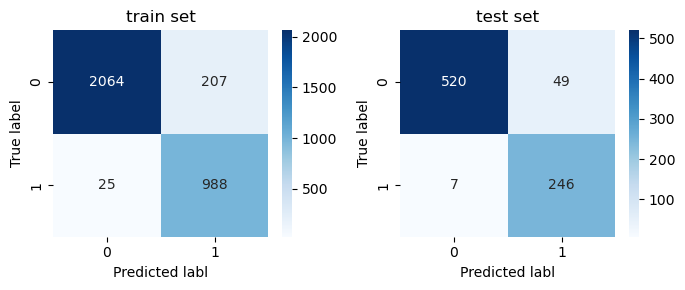

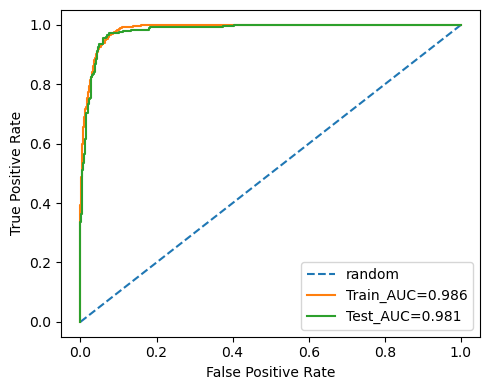

This model train session took 0.020138370990753173minutes.


In [1045]:
report_loss_cf('Logistic Regression', model_lg, X_train, y_train, X_test, y_test, graph = 1)

end = time.time()
print(f'This model train session took {(end-start)/60}minutes.')

**Perform random search cross-validation**

In [1046]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

In [1047]:
param_grid = {
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [0.1, 1.0, 10],
    'lr__solver': ['liblinear', 'saga']
}

steps=[("pre",preprocessor),        
       ("lr", LogisticRegression(class_weight = 'balanced', max_iter=100000))]

random_search = RandomizedSearchCV(lg, param_distributions=param_grid, n_iter=10, cv=5, random_state=42)
random_search.fit(X_train, y_train)

# Retrieve the best hyperparameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Evaluate the model
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

print("Best Hyperparameters:", best_params)
print("Training Score:", train_score)
print("Testing Score:", test_score)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pre',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['REPORTED_WKLY_SPEND',
                                                                                'REPORTED_WKLY_SPEND_USF',
                                                                                'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE',
                                                                                'REPORTED_WKLY_SPEND_COMP',
                                                                                'REPORTED_WKLY_SPEND_COMPETITOR_1',
                                                                                'REPORTED_WKLY_SPEND_SPCLTY',
                                                                                'REPORTED_WKLY_SPEND_CC',
                                                                                'RE...
                                                                                                SimpleImputer(fill_value='unknown',
                                                                                                              strategy='constant')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore')),
                                                                                               ('scaler',
                                                                                                StandardScaler(with_mean=False))]),
                                                                               ['MENU_TYP_DESC',
                                                                                'PYR_SEG_CD'])])),
                                             ('lr',
                                              LogisticRegression(class_weight='balanced'))]),
                   param_distributions={'lr__C': [0.1, 1.0, 10],
                                        'lr__penalty': ['l1', 'l2'],
                                        'lr__solver': ['liblinear', 'saga']},
                   random_state=42)

Best Hyperparameters: {'lr__solver': 'liblinear', 'lr__penalty': 'l1', 'lr__C': 10}
Training Score: 0.9820341047503045
Testing Score: 0.9841849148418491


**Perform BayesSearchCV to see if we can improve the performance**

In [778]:
# pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.Collecting scikit-optimize
     -------------------------------------- 100.3/100.3 kB 1.2 MB/s eta 0:00:00



In [1049]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV

In [1050]:
param_grid = {
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [0.1, 1.0, 10],
    'lr__solver': ['liblinear', 'saga']
}

# using BayesSearchCV to tune the parameters
steps=[("pre",preprocessor),        
       ("lr", LogisticRegression(class_weight = 'balanced', max_iter=10000))]

lg = Pipeline(steps)
bayes_cv = BayesSearchCV(lg, param_grid, cv=5, n_jobs=-1, random_state=42)

bayes_cv.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('pre',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('scaler',
                                                                                           StandardScaler())]),
                                                                          ['REPORTED_WKLY_SPEND',
                                                                           'REPORTED_WKLY_SPEND_USF',
                                                                           'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE',
                                                                           'REPORTED_WKLY_SPEND_COMP',
                                                                           'REPORTED_WKLY_SPEND_COMPETITOR_1',
                                                                           'REPORTED_WKLY_SPEND_SPCLTY',
                                                                           'REPORTED_WKLY_SPEND_CC',
                                                                           'REPORTE...
                                                                                           SimpleImputer(fill_value='unknown',
                                                                                                         strategy='constant')),
                                                                                          ('onehot',
                                                                                           OneHotEncoder(handle_unknown='ignore')),
                                                                                          ('scaler',
                                                                                           StandardScaler(with_mean=False))]),
                                                                          ['MENU_TYP_DESC',
                                                                           'PYR_SEG_CD'])])),
                                        ('lr',
                                         LogisticRegression(class_weight='balanced',
                                                            max_iter=10000))]),
              n_jobs=-1, random_state=42,
              search_spaces={'lr__C': [0.1, 1.0, 10],
                             'lr__penalty': ['l1', 'l2'],
                             'lr__solver': ['liblinear', 'saga']})

In [ ]:
# Get the best hyperparameters
best_params = bayes_cv.best_params_
best_score = bayes_cv.best_score_
print(best_params)
print(best_score)

Model performance for:  Logistic Regression
train set accuracy: 0.982
train set precision: 0.948
train set recall: 0.998
train set f1 score: 0.972
training set AUC score: 0.998

test set accuracy: 0.983
test set precision: 0.958
test set recall: 0.988
test set f1 score: 0.973
test set AUC score: 0.998


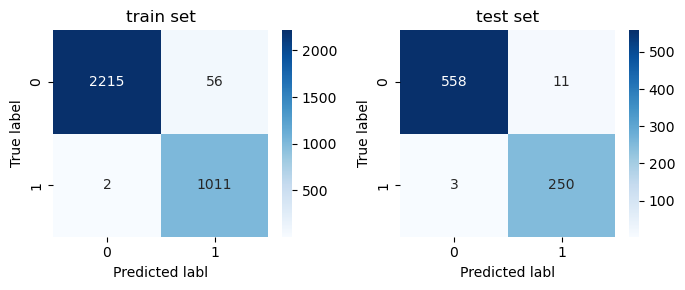

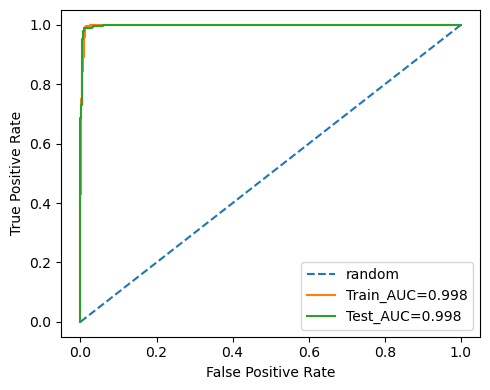

In [1051]:
# Get the best model
steps=[("pre",preprocessor),        
       ("lr", LogisticRegression(class_weight = 'balanced', penalty='l1', solver='liblinear', C=10))]

lg_opt = Pipeline(steps)
model_lgopt = lg_opt.fit(X_train, y_train)

report_loss_cf('Logistic Regression', model_lgopt, X_train, y_train, X_test, y_test, graph = 1)

**plot the feature importance from this logistic regression model**

In [1052]:
# Get the feature importances
importance = model_lgopt.named_steps['lr'].coef_[0]
indices = np.argsort(np.abs(importance))[::-1][:20] # <-- slice the indices array to show the first 20
feature_names = model_lgopt.named_steps['pre'].get_feature_names_out()[indices]
feature_names = [name[5:] for name in feature_names]  # Remove first 5 characters from each feature name
feature_names = [name[1:] if name.startswith('_') else name for name in feature_names]
importance = importance[indices]

# Set up the color map
cmap = plt.cm.get_cmap('coolwarm')

<Figure size 1000x600 with 0 Axes>

<AxesSubplot:xlabel='importance', ylabel='feature'>

Text(0.5, 1.0, 'Top 20 Feature Importances')

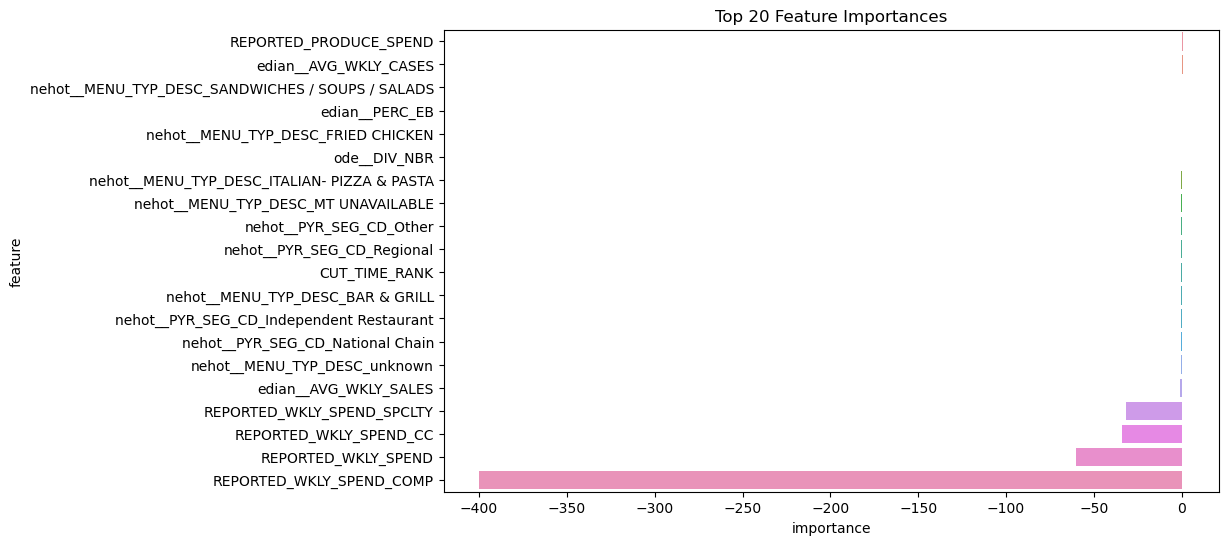

In [1053]:
#create a dataframe to store the feature names and their importance
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})

#sort the dataframe based on importance
feature_importance.sort_values(by = 'importance', ascending = False, inplace = True)

#plot the dataframe
plt.figure(figsize = (10, 6))
sns.barplot(x = 'importance', y = 'feature', data = feature_importance)
plt.title('Top 20 Feature Importances')
plt.show()

In [1054]:
feature_importance

feature  importance
4                             REPORTED_PRODUCE_SPEND    0.931818
6                              edian__AVG_WKLY_CASES    0.742658
9   nehot__MENU_TYP_DESC_SANDWICHES / SOUPS / SALADS    0.369785
10                                    edian__PERC_EB    0.350680
18                nehot__MENU_TYP_DESC_FRIED CHICKEN    0.201739
19                                      ode__DIV_NBR    0.195464
17       nehot__MENU_TYP_DESC_ITALIAN- PIZZA & PASTA   -0.225842
16               nehot__MENU_TYP_DESC_MT UNAVAILABLE   -0.279328
15                           nehot__PYR_SEG_CD_Other   -0.290189
14                        nehot__PYR_SEG_CD_Regional   -0.311841
13                                     CUT_TIME_RANK   -0.314831
12                  nehot__MENU_TYP_DESC_BAR & GRILL   -0.317445
11          nehot__PYR_SEG_CD_Independent Restaurant   -0.328627
8                   nehot__PYR_SEG_CD_National Chain   -0.402846
7                       nehot__MENU_TYP_DESC_unknown   -0.608372
5                              edian__AVG_WKLY_SALES   -0.769411
3                         REPORTED_WKLY_SPEND_SPCLTY  -31.753955
2                             REPORTED_WKLY_SPEND_CC  -34.044459
1                                REPORTED_WKLY_SPEND  -60.002543
0                           REPORTED_WKLY_SPEND_COMP -400.119972

### Top 20 Feature SHAP Values

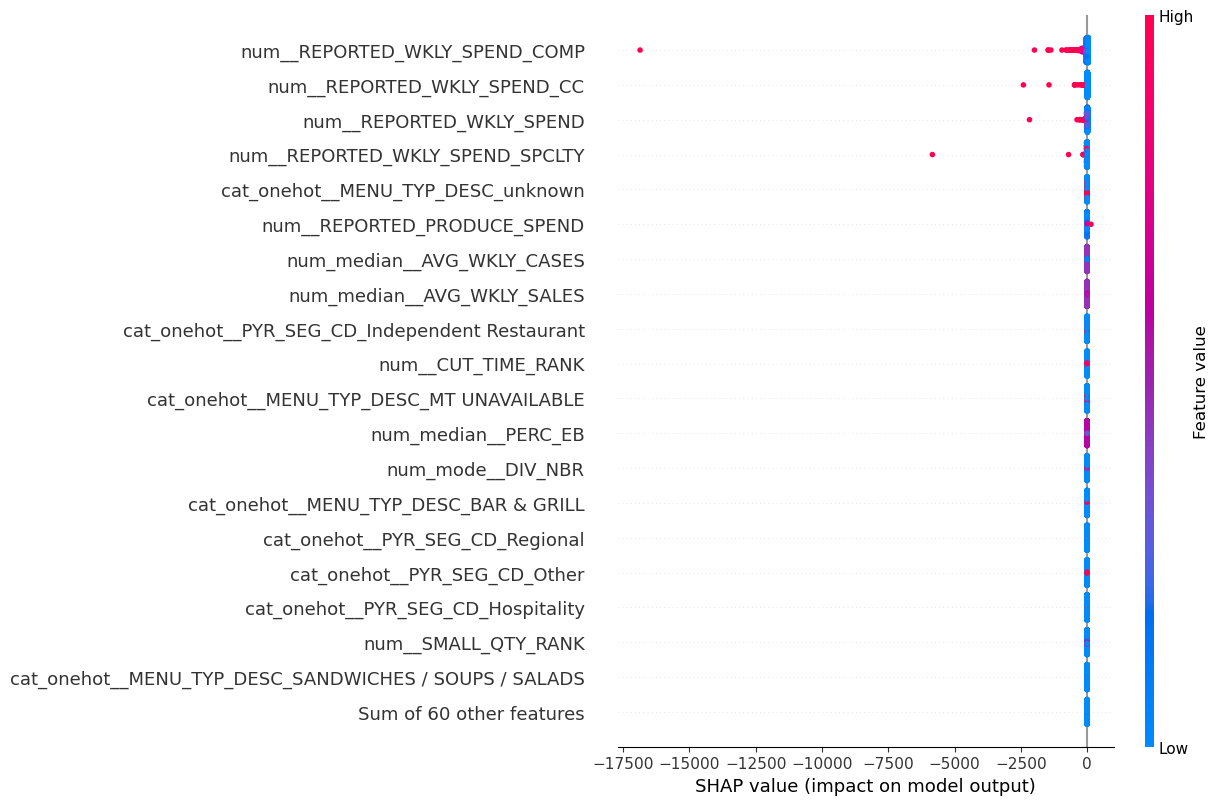

In [1055]:
import shap
shap.initjs()

# Fit the preprocessor to the training data and transform it
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Transform the test data using the preprocessor (do not fit again)
X_test_preprocessed = preprocessor.transform(X_test)

# Get the logistic regression model from the pipeline
logistic_model = lg_opt.named_steps['lr']

# Create the Independent masker using the transformed training data
masker = shap.maskers.Independent(X_train_preprocessed)

# Create the LinearExplainer using the logistic_model and the masker
explainer = shap.LinearExplainer(logistic_model, masker)

# Get the SHAP values for the test data
shap_values = explainer.shap_values(X_test_preprocessed)

# Plot the SHAP values
feature_names = preprocessor.get_feature_names_out(input_features=X.columns)

explanation = shap.Explanation(values=shap_values, data=X_test_preprocessed, feature_names=feature_names)

# Create the beeswarm plot using the Explanation object
shap.plots.beeswarm(explanation, max_display=20)


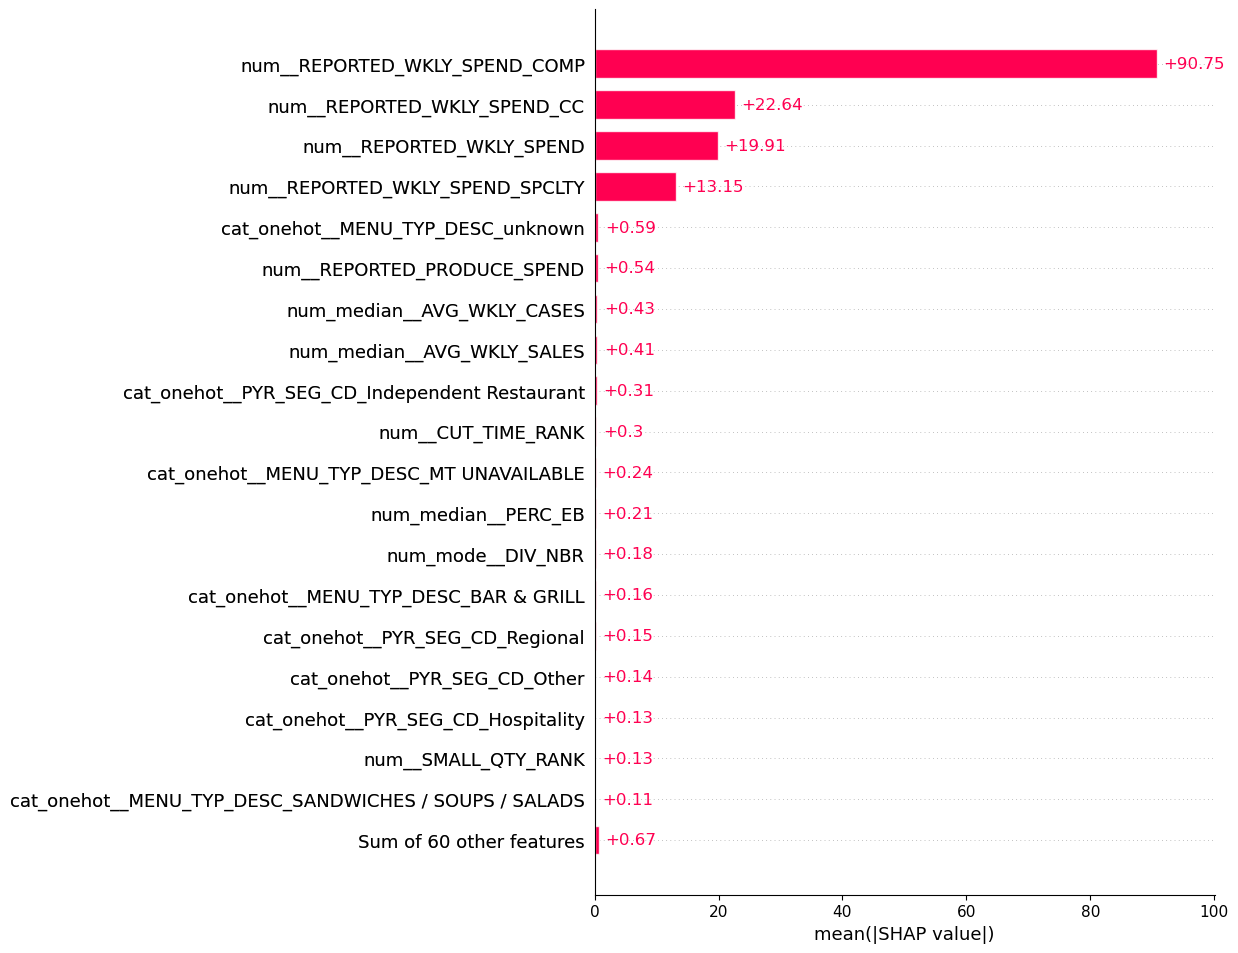

In [1056]:
shap.plots.bar(explanation, max_display=20)

**Feature importance for your potential customers who are more likely to choose daily US Foods delivery:**

**Positive Feature Importance:**

* REPORTED_PRODUCE_SPEND (0.931818): The amount a customer spends on Produce items, such as fruits and vegetables, is the most positively influential feature. An increased spend in this category implies they are more likely to opt for US Foods daily delivery.

* edian__AVG_WKLY_CASES (0.742658): This feature represents the weekly average cases a customer purchases. A higher average indicates a greater tendency to use US Foods daily delivery.

* nehot__MENU_TYP_DESC_SANDWICHES / SOUPS / SALADS (0.369785): Restaurants that majorly serve sandwiches, soups, or salads on their menu have a stronger inclination towards the daily delivery service.

* edian__PERC_EB (0.350680): This represents the percentage of purchases that are exclusive brands. A higher percentage suggests the customer prefers US Foods daily delivery.

* nehot__MENU_TYP_DESC_FRIED CHICKEN (0.201739) and ode__DIV_NBR (0.195464): Restaurants that frequently serve fried chicken and specific divisions (as per the unique identifier) are positively associated with daily delivery, though to a lesser degree than the above features.

**Negative Feature Importance:**

* nehot__MENU_TYP_DESC_ITALIAN- PIZZA & PASTA (-0.225842): Italian-oriented establishments, particularly those with menus focused on pizza and pasta, are less inclined towards the daily delivery service.

* CUT_TIME_RANK (-0.314831): This denotes the importance a customer places on a later order deadline. A higher rank (closer to 10) implies they value this feature more, but its negative influence indicates that they might be less inclined to use the daily delivery.

* nehot__PYR_SEG_CD_Independent Restaurant (-0.328627): Independent restaurants, when compared to chains, are less likely to prefer daily delivery.

* REPORTED_WKLY_SPEND_SPCLTY (-31.753955): This represents the weekly amount a customer spends with specialty distributors. A high spend in this category reduces the likelihood of choosing US Foods daily delivery.

* REPORTED_WKLY_SPEND_CC (-34.044459): Customers who spend more weekly at cash and carry stores are less likely to choose the daily delivery service.

* REPORTED_WKLY_SPEND (-60.002543): This feature represents the weekly spend with all distributors. The more a customer spends in total weekly, the less inclined they seem to use the daily service.

* REPORTED_WKLY_SPEND_COMP (-400.119972): This is the amount a customer spends weekly with all competitors. The high negative importance of this feature indicates that the more a potential customer spends weekly with competitors, the far less likely they are to opt for US Foods daily delivery.

**To conclude, customers who emphasize the importance of later order deadlines, or spend more with specialty distributors and competitors (especially on a weekly basis) seem less inclined towards US Foods daily delivery. On the other hand, establishments with higher produce spends, or specific menu preferences, showcase a stronger affinity for the service.**

In [1057]:
# generate pridiction from model 1 (logistic regression) and output the results to LG_results.csv
pred_y = pd.DataFrame(model_lgopt.predict_proba(X)[:,1])
pred_y.columns = ['Predicted Probability']
pred_y.to_csv('LG_results.csv',index=False, header =False)

df_new=df.copy()
df_new['Predicted Probability'] = pred_y*100
df_new.head()

CUST_NBR  REPORTED_WKLY_SPEND  REPORTED_WKLY_SPEND_USF  \
0     24682          53874.74544              53731.46154   
1     40724          13023.91865              13023.91865   
2     40724          13023.91865              13023.91865   
3     40724          13023.91865              13023.91865   
4     40724          13023.91865              13023.91865   

   REPORTED_WKLY_SPEND_USF_DAILY_SERVICE  REPORTED_WKLY_SPEND_COMP  \
0                            53803.10349                143.283897   
1                            13023.91865                  0.000000   
2                            13023.91865                  0.000000   
3                            13023.91865                  0.000000   
4                            13023.91865                  0.000000   

   REPORTED_WKLY_SPEND_COMPETITOR_1  REPORTED_WKLY_SPEND_OTHER_BLD  \
0                               0.0                     143.283897   
1                               0.0                       0.000000   
2                               0.0                       0.000000   
3                               0.0                       0.000000   
4                               0.0                       0.000000   

   REPORTED_WKLY_SPEND_SPCLTY  REPORTED_WKLY_SPEND_CC  \
0                         0.0                     0.0   
1                         0.0                     0.0   
2                         0.0                     0.0   
3                         0.0                     0.0   
4                         0.0                     0.0   

   REPORTED_WKLY_SPEND_OTHER  REPORTED_COP_SPEND  REPORTED_PRODUCE_SPEND  \
0                        0.0        32253.205310              107.462923   
1                        0.0         7814.351192             2604.783731   
2                        0.0         6000.000000             2000.000000   
3                        0.0         6000.000000             2000.000000   
4                        0.0            0.000000                0.000000   

   SMALL_QTY_RANK  DEL_FLEX_RANK  CUT_TIME_RANK  DIV_NBR  WKLY_ORDERS  \
0              10              9              4      1.0          3.5   
1               5              1              8      6.0          4.5   
2               8              9              1      6.0          4.5   
3               4              3              7      6.0          4.5   
4               0              0              0      6.0          4.5   

    PERC_EB   MENU_TYP_DESC   PYR_SEG_CD  AVG_WKLY_SALES  AVG_WKLY_CASES  \
0  0.163933  MT UNAVAILABLE       Retail    53731.461540      562.846154   
1  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479   
2  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479   
3  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479   
4  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479   

           CUSTOMER_CLUSTER  CUSTOMER_CLUSTER_BINARY  Predicted Probability  
0  Already on Daily Service                        0          5.665816e-104  
1  Already on Daily Service                        0           3.435278e-20  
2  Already on Daily Service                        0           5.332270e-20  
3  Already on Daily Service                        0           3.302405e-20  
4  Already on Daily Service                        0           3.063440e-20

In [1058]:
# use numpy to categorize the values into three tiers
df_new['Tier'] = np.where(df_new['Predicted Probability'] < 30, 'D',
                 np.where(df_new['Predicted Probability'] < 50, 'C', 
                 np.where(df_new['Predicted Probability'] < 80, 'B','A')))

# print the results
df_new.head()

CUST_NBR  REPORTED_WKLY_SPEND  REPORTED_WKLY_SPEND_USF  \
0     24682          53874.74544              53731.46154   
1     40724          13023.91865              13023.91865   
2     40724          13023.91865              13023.91865   
3     40724          13023.91865              13023.91865   
4     40724          13023.91865              13023.91865   

   REPORTED_WKLY_SPEND_USF_DAILY_SERVICE  REPORTED_WKLY_SPEND_COMP  \
0                            53803.10349                143.283897   
1                            13023.91865                  0.000000   
2                            13023.91865                  0.000000   
3                            13023.91865                  0.000000   
4                            13023.91865                  0.000000   

   REPORTED_WKLY_SPEND_COMPETITOR_1  REPORTED_WKLY_SPEND_OTHER_BLD  \
0                               0.0                     143.283897   
1                               0.0                       0.000000   
2                               0.0                       0.000000   
3                               0.0                       0.000000   
4                               0.0                       0.000000   

   REPORTED_WKLY_SPEND_SPCLTY  REPORTED_WKLY_SPEND_CC  \
0                         0.0                     0.0   
1                         0.0                     0.0   
2                         0.0                     0.0   
3                         0.0                     0.0   
4                         0.0                     0.0   

   REPORTED_WKLY_SPEND_OTHER  REPORTED_COP_SPEND  REPORTED_PRODUCE_SPEND  \
0                        0.0        32253.205310              107.462923   
1                        0.0         7814.351192             2604.783731   
2                        0.0         6000.000000             2000.000000   
3                        0.0         6000.000000             2000.000000   
4                        0.0            0.000000                0.000000   

   SMALL_QTY_RANK  DEL_FLEX_RANK  CUT_TIME_RANK  DIV_NBR  WKLY_ORDERS  \
0              10              9              4      1.0          3.5   
1               5              1              8      6.0          4.5   
2               8              9              1      6.0          4.5   
3               4              3              7      6.0          4.5   
4               0              0              0      6.0          4.5   

    PERC_EB   MENU_TYP_DESC   PYR_SEG_CD  AVG_WKLY_SALES  AVG_WKLY_CASES  \
0  0.163933  MT UNAVAILABLE       Retail    53731.461540      562.846154   
1  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479   
2  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479   
3  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479   
4  0.573987  MT UNAVAILABLE  Hospitality     4031.561051       74.332479   

           CUSTOMER_CLUSTER  CUSTOMER_CLUSTER_BINARY  Predicted Probability  \
0  Already on Daily Service                        0          5.665816e-104   
1  Already on Daily Service                        0           3.435278e-20   
2  Already on Daily Service                        0           5.332270e-20   
3  Already on Daily Service                        0           3.302405e-20   
4  Already on Daily Service                        0           3.063440e-20   

  Tier  
0    D  
1    D  
2    D  
3    D  
4    D

In [1059]:
df_new[['CUSTOMER_CLUSTER_BINARY','Tier']].head()

CUSTOMER_CLUSTER_BINARY Tier
0                        0    D
1                        0    D
2                        0    D
3                        0    D
4                        0    D

In [1060]:
print(lg.named_steps.keys())

dict_keys(['pre', 'lr'])


**Plot precision_recall_curve and threshold curve of X-test**

Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Precision-Recall Curve')

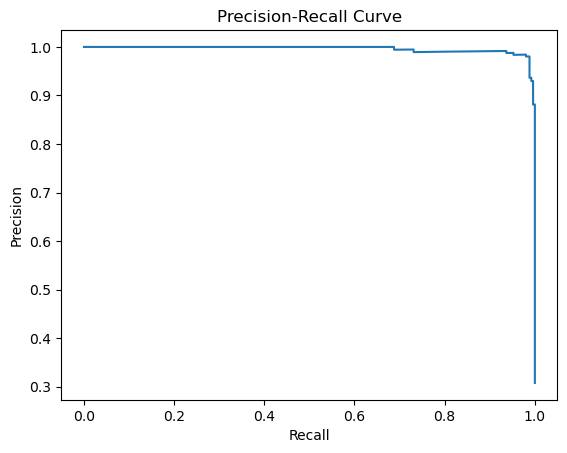

Text(0.5, 0, 'Threshold')

Text(0, 0.5, 'Score')

Text(0.5, 1.0, 'Threshold Plot')

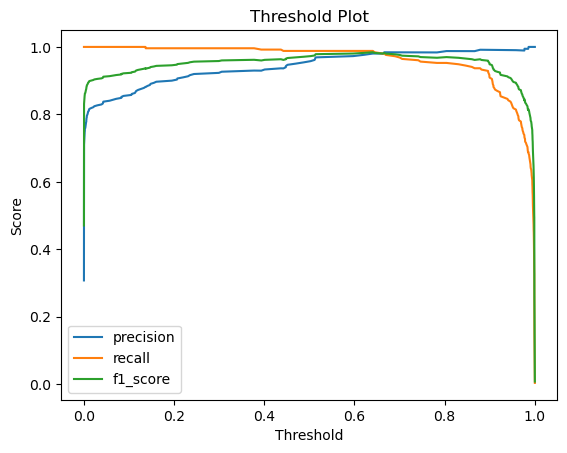

In [1061]:
from sklearn.metrics import precision_recall_curve

# get predicted probabilities for the positive class
y_proba = model_lgopt.predict_proba(X_test)[:, 1]

# compute precision and recall for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# plot precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# plot threshold plot
f1_score = 2 * (precision * recall) / (precision + recall)
plt.plot(thresholds, precision[:-1], label='precision')
plt.plot(thresholds, recall[:-1], label='recall')
plt.plot(thresholds, f1_score[:-1], label='f1_score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Threshold Plot')
plt.show()

### Summary for logisitic regression
Our Logistic Regression model is performing exceptionally well. It's correctly predicting outcomes about 98% of the time. When it says something is positive, it's right around 95% of the time, and it rarely misses any positive cases. These results hold true for both our sample training data and the new test data, which is promising for when we use the model in real-world situations.

**Take-away message for further discussion:**

* What Makes Customers More Likely to Choose US Foods Daily Delivery:

Customers who spend a lot on fruits and vegetables.

Those who order a lot of items weekly.

Restaurants that mainly serve sandwiches, soups, or salads.

Establishments that frequently buy exclusive brands.

Restaurants that serve a lot of fried chicken.


* What Makes Customers Less Likely to Choose US Foods Daily Delivery:

Italian food places, especially those serving pizza and pasta.

Customers who value having a longer time window to place their orders.

Independent restaurants, as opposed to big chains.

Those who spend more with special food suppliers.

Customers who buy a lot from cash and carry stores.

Those who already spend a lot with other distributors every week.

Especially, those who spend a significant amount with our competitors.

**In essence, while some customers are drawn to the US Foods daily delivery based on their food choices and purchasing habits, others seem less inclined due to their existing relationships with other suppliers or specific needs related to order timings.**

## XGBoost (Treed based model)

In [1097]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

Model performance for:  XGBoost
train set accuracy: 1.000
train set precision: 1.000
train set recall: 1.000
train set f1 score: 1.000
training set AUC score: 1.000

test set accuracy: 1.000
test set precision: 1.000
test set recall: 1.000
test set f1 score: 1.000
test set AUC score: 1.000


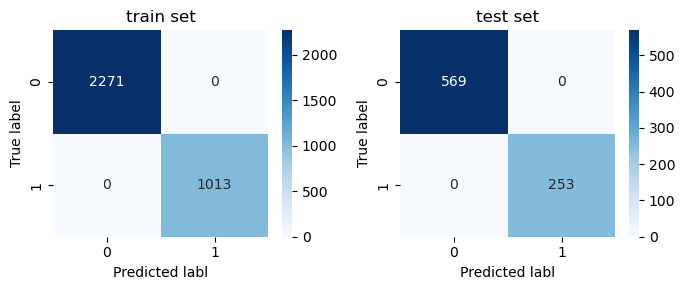

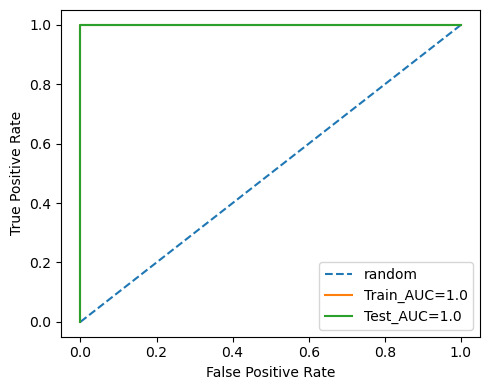

In [1098]:
start = time.time()

steps=[("pre",preprocessor),        
       ("xgb", XGBClassifier(random_state=42))]

xgb = Pipeline(steps)
model_xgb = xgb.fit(X_train, y_train)

# fit the pipeline to the training data
model_xgb = xgb.fit(X_train, y_train)

report_loss_cf('XGBoost', model_xgb, X_train, y_train, X_test, y_test, graph = 1)

? Overfitting: This happens when the model memorizes the training data and fails to generalize well to new, unseen data. However, since your test set also has perfect scores, this is less likely to be the only issue.

? Data Leakage: This is the most common cause of perfect scores. Data leakage occurs when the model inadvertently gets access to the target variable during training.

In [1088]:
import time
from xgboost import XGBClassifier

start = time.time()

steps = [("pre", preprocessor),            
         ("Ensemble", XGBClassifier(random_state=42))]

model = Pipeline(steps)

params = {
    'Ensemble__n_estimators': np.arange(20, 110, 10),
    'Ensemble__max_depth': np.arange(2, 12, 2),
    'Ensemble__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'Ensemble__gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'Ensemble__colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7],
    'Ensemble__subsample': [0.8, 0.9, 1.0]
}

model_xgb = RandomizedSearchCV(model,
                               params,
                               n_iter=50,
                               cv=5,
                               n_jobs=-1,
                               scoring='roc_auc')

# Fit the model
model_xgb.fit(X_train, y_train)

end = time.time()




RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pre',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['REPORTED_WKLY_SPEND',
                                                                                'REPORTED_WKLY_SPEND_USF',
                                                                                'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE',
                                                                                'REPORTED_WKLY_SPEND_COMP',
                                                                                'REPORTED_WKLY_SPEND_COMPETITOR_1',
                                                                                'REPORTED_WKLY_SPEND_SPCLTY',
                                                                                'REPORTED_WKLY_SPEND_CC',
                                                                                'RE...
                                                            random_state=42, ...))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'Ensemble__colsample_bytree': [0.3, 0.4,
                                                                       0.5, 0.6,
                                                                       0.7],
                                        'Ensemble__gamma': [0, 0.1, 0.2, 0.3,
                                                            0.4],
                                        'Ensemble__learning_rate': [0.01, 0.05,
                                                                    0.1, 0.2,
                                                                    0.3],
                                        'Ensemble__max_depth': array([ 2,  4,  6,  8, 10]),
                                        'Ensemble__n_estimators': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100]),
                                        'Ensemble__subsample': [0.8, 0.9, 1.0]},
                   scoring='roc_auc')

In [1089]:
print(model_xgb.best_params_)
print(model_xgb.best_score_)
print(f'This random search session took {(end-start)/60} minutes.')

{'Ensemble__subsample': 1.0, 'Ensemble__n_estimators': 50, 'Ensemble__max_depth': 6, 'Ensemble__learning_rate': 0.3, 'Ensemble__gamma': 0.4, 'Ensemble__colsample_bytree': 0.7}
0.999943577613333
This random search session took 0.21872336864471437 minutes.


Model performance for:  XGBoost
train set accuracy: 1.000
train set precision: 1.000
train set recall: 1.000
train set f1 score: 1.000
training set AUC score: 1.000

test set accuracy: 1.000
test set precision: 1.000
test set recall: 1.000
test set f1 score: 1.000
test set AUC score: 1.000


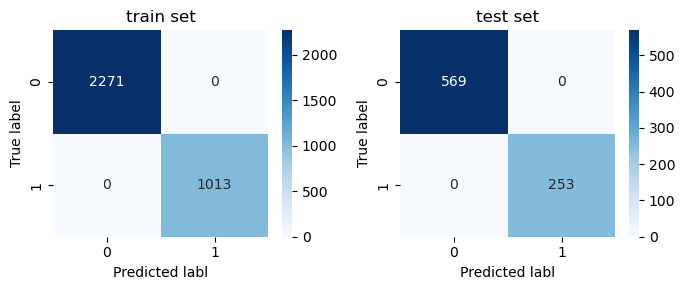

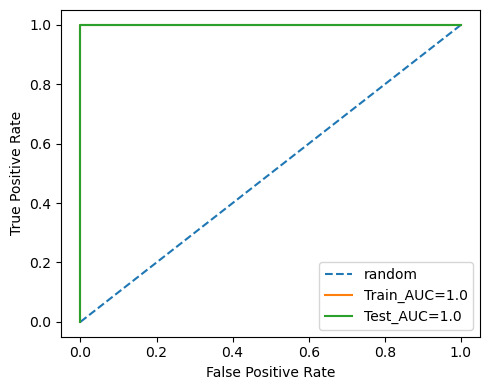

In [1090]:
report_loss_cf('XGBoost', model_xgb, X_train, y_train, X_test, y_test, graph = 1)

## Random Forest (Treed based model)

In [1069]:
steps = [("pre", preprocessor),            
         ("Ensemble", RandomForestClassifier(class_weight='balanced',random_state = 42))]

model = Pipeline(steps)

params = {'Ensemble__n_estimators' : np.arange(20,110,10),
          'Ensemble__max_depth': np.arange(2,12,2),
          'Ensemble__min_samples_split' : [2,4,6,8,10,20,40,60],
          'Ensemble__min_samples_leaf' : [1,5,10,20],
          'Ensemble__max_features': ['sqrt', 'log2'],
         }

rs = RandomizedSearchCV(model,
                        params,
                        n_iter=50,
                        cv=5,
                        n_jobs=-1,
                        scoring='roc_auc')

rs.fit(X_train, y_train)

end = time.time()

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('pre',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['REPORTED_WKLY_SPEND',
                                                                                'REPORTED_WKLY_SPEND_USF',
                                                                                'REPORTED_WKLY_SPEND_USF_DAILY_SERVICE',
                                                                                'REPORTED_WKLY_SPEND_COMP',
                                                                                'REPORTED_WKLY_SPEND_COMPETITOR_1',
                                                                                'REPORTED_WKLY_SPEND_SPCLTY',
                                                                                'REPORTED_WKLY_SPEND_CC',
                                                                                'RE...
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'Ensemble__max_depth': array([ 2,  4,  6,  8, 10]),
                                        'Ensemble__max_features': ['sqrt',
                                                                   'log2'],
                                        'Ensemble__min_samples_leaf': [1, 5, 10,
                                                                       20],
                                        'Ensemble__min_samples_split': [2, 4, 6,
                                                                        8, 10,
                                                                        20, 40,
                                                                        60],
                                        'Ensemble__n_estimators': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100])},
                   scoring='roc_auc')

In [1081]:
print(rs.best_params_)
print(rs.best_score_)
print(f'This random search session took {(end-start)/60} minutes.')

{'Ensemble__n_estimators': 40, 'Ensemble__min_samples_split': 10, 'Ensemble__min_samples_leaf': 1, 'Ensemble__max_features': 'sqrt', 'Ensemble__max_depth': 6}
0.9998372323723551
This random search session took -1.8939613978068033 minutes.


Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Precision-Recall Curve')

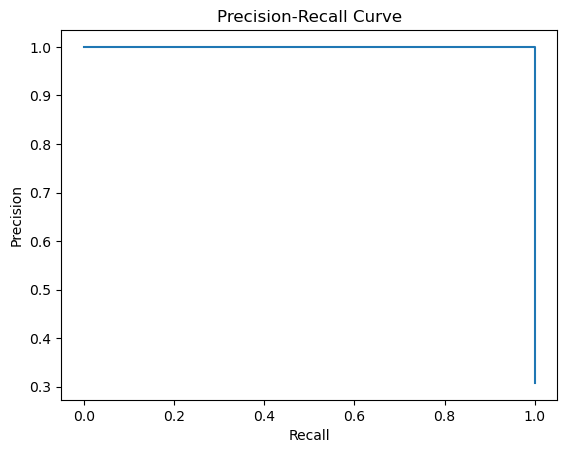

Text(0.5, 0, 'Threshold')

Text(0, 0.5, 'Score')

Text(0.5, 1.0, 'Threshold Plot')

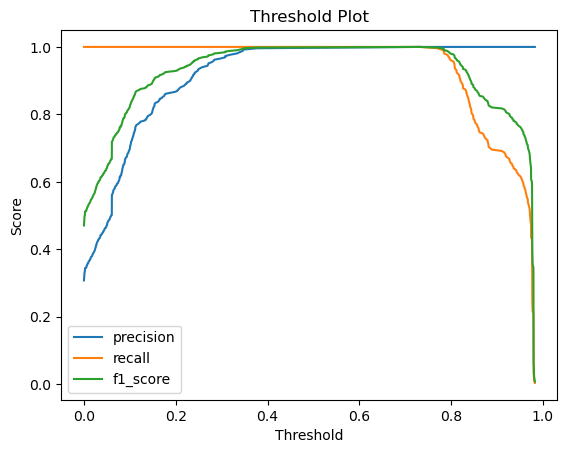

In [1082]:
# get predicted probabilities for the positive class
y_proba = rs.predict_proba(X_test)[:, 1]

# compute precision and recall for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# plot precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# plot threshold plot
f1_score = 2 * (precision * recall) / (precision + recall)
plt.plot(thresholds, precision[:-1], label='precision')
plt.plot(thresholds, recall[:-1], label='recall')
plt.plot(thresholds, f1_score[:-1], label='f1_score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.title('Threshold Plot')
plt.show()

In [1072]:
# Get the best model
steps = [("pre", preprocessor),            
         ("Ensemble", RandomForestClassifier(class_weight='balanced',
                                             n_estimators = 100, 
                                             min_samples_split = 2, 
                                             min_samples_leaf = 10,
                                             max_features = 'log2', 
                                             max_depth = 2,
                                             random_state = 42))]

rf_opt = Pipeline(steps)
model_rfopt = rf_opt.fit(X_train, y_train)

Model performance for:  Random Forest
train set accuracy: 0.942
train set precision: 0.843
train set recall: 0.999
train set f1 score: 0.914
training set AUC score: 0.997

test set accuracy: 0.954
test set precision: 0.869
test set recall: 1.000
test set f1 score: 0.930
test set AUC score: 0.998


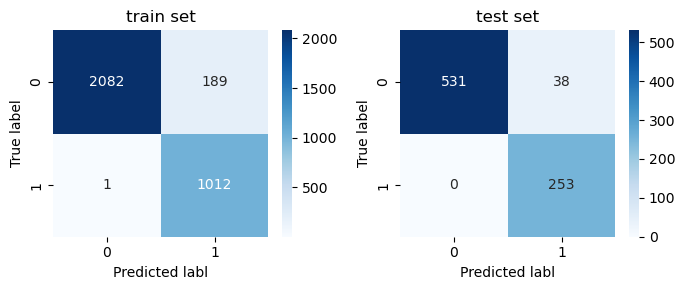

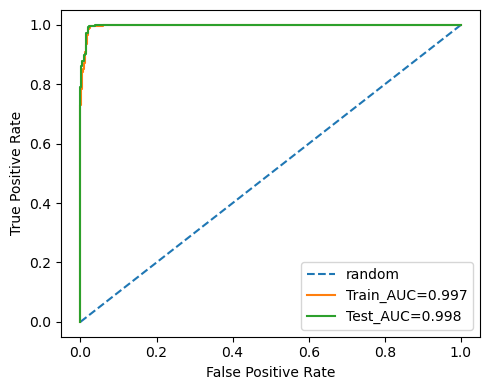

In [1083]:

report_loss_cf('Random Forest', model_rfopt, X_train, y_train, X_test, y_test, graph = 1)

Random Forest vs. Logistic Regression: When comparing the metrics quantitatively:

AUC: The Random Forest model has a training AUC of 0.997 and a test AUC of 0.998, which are both higher than the Logistic Regression's 0.986 (train) and 0.981 (test). This suggests that the Random Forest model distinguishes between the positive and negative classes more effectively.

Accuracy: The Random Forest also boasts higher accuracy scores, with 0.942 on the training set and 0.954 on the test set, compared to the Logistic Regression's 0.929 (train) and 0.932 (test).

Recall: For recall, the Random Forest model achieves nearly perfect scores of 0.999 and 1.000 on the training and test sets respectively, while the Logistic Regression has slightly lower scores of 0.975 (train) and 0.972 (test).

**Random Forest vs. Logistic Regression: The Random Forest seems to perform slightly better than the Logistic Regression across most metrics, especially in terms of AUC.**

I should be cautious about the XGBoost results and investigate further before deploying any model into a real-world application.

## The loss function of max profit

**I need to discuss this with HM and subject matter expertise.**
To maximize our profit, we need to understand and cater to the spending habits, restaurant types, and preferences of potential customers. This means recognizing what makes them tick, whether it's the type of food they serve, where they currently spend their money, or what delivery features matter most to them. By doing so, we can better position US Foods Daily Delivery as their go-to choice.


**Loss Function for Max Profit:**

Objective: Maximize profit by predicting and enhancing the likelihood of a potential customer choosing the US Foods Daily Delivery service.

**Components:**

1. Spending Habits: The more a customer spends weekly with competitors, especially the primary competitor, the less likely they are to choose the US Foods Daily Delivery service. This would indicate a negative correlation between spending with competitors and potential profit for US Foods.

2. Restaurant Type & Preferences: Certain types of restaurants, like those focusing on sandwiches, soups, salads, or fried chicken, are more inclined towards the US Foods Daily Delivery service. On the other hand, establishments like bars & grills, Italian pizza & pasta joints, or those categorized under 'MT UNAVAILABLE' showed less inclination.

3. Exclusive Brands: A higher percentage of purchases of exclusive brands indicate a higher likelihood of opting for US Foods Daily Delivery.

4. Order Preferences: Features like the importance of ordering in small quantities (SMALL_QTY_RANK), the flexibility in delivery schedule (DEL_FLEX_RANK), and a later order deadline (CUT_TIME_RANK) influence the decision. The data suggests that a later order deadline might be acting as a deterrent for some customers.

5. Spending Categories: Spending in specific categories like produce (REPORTED_PRODUCE_SPEND) has a positive impact, whereas spending at specialty distributors (REPORTED_WKLY_SPEND_SPCLTY) or cash and carry stores (REPORTED_WKLY_SPEND_CC) might have a negative correlation with the choice of US Foods Daily Delivery.

6. Restaurant's Pyramid Segmentation: There's a differentiation in behavior based on the restaurant's pyramid segmentation. National chains, independent restaurants, and regional outlets might have varied inclinations towards the service.

7. Division Identifier (DIV_NBR): This unique identifier might capture regional or operational nuances that influence the decision-making process.



The below is an example how I create a loss funtion of max profit for Loan Default Predictor, which is the last project on my resume.

〖𝑃𝑟𝑜𝑓𝑖𝑡=𝑇𝐹 ∗𝑙𝑜𝑎𝑛 𝑎𝑚𝑜𝑢𝑛𝑡 ∗{〖 [1+𝑟2/12] 〗^(30∗12 )−[1+𝑟1/12] 〗^(30∗12 )}   
                    −𝐹𝑁∗1/2∗𝑙𝑜𝑎𝑛 𝑎𝑚𝑜𝑢𝑛𝑡 
                    −𝐹𝑃〖∗𝑙𝑜𝑎𝑛 𝑎𝑚𝑜𝑢𝑛𝑡 ∗{〖 [1+𝑟2/12] 〗^(30∗12 )−[1+𝑟1/12] 〗^(30∗12 )}   


## Summary of the notebook

Summary:
1. Objective:
To determine which customer is best to target for this selected service offering. 

2. Data Processing:
Data Cleaning: Removed duplicates, handled missing values, and managed outliers.

Feature Engineering: Created new features from the existing ones to better represent underlying patterns.

Data Splitting: Divided the dataset into training and testing sets for model validation.

3. Model Evaluation:
XGBoost, Random Forest, Logistic Regression


4. Key Features Impacting Choice for US Foods Daily Delivery:

* More Likely:

a. High expenditure on fruits and vegetables.

b. High frequency of weekly orders.

c. Predominance of sandwiches, soups, or salads in the menu.

d. Regular purchase of exclusive brands.

e. High consumption of fried chicken.

* Less Likely:

a. Predominantly Italian cuisine, especially pizza and pasta.

b. Preference for a longer order window.

c. Independence as opposed to being a part of big chains.

d. More expenditure with specialized food suppliers.

e. Higher purchases from cash and carry stores.

f. Significant spending with other distributors every week.

e. Notably, a considerable expenditure with competitors.

* Next Steps:

Stakeholder Meeting: Discuss the findings with HR and domain experts. This is vital for integrating business insights and refining the model if necessary.

Function for Maximum Profit: Collaborate with experts to design a function that helps calculate maximum profit, leveraging the insights gained from the modeling exercise.


# Strategic Customer Segmentation for Optimizing Daily Delivery Services at US Foods

**1. Based on the survey responses and the transaction data, what customer should we offer the daily delivery service to? And why? Are there customers who should not be eligible for the service? If so, why?**


* Customers to Offer Daily Delivery Service:

Customers who spend a lot on fruits and vegetables: These customers are likely to require fresh produce frequently. Daily delivery ensures that they always get fresh items.

Those who order a lot of items weekly: These establishments might benefit from daily deliveries to manage inventory better and ensure they never run out of stock.

Restaurants that mainly serve sandwiches, soups, or salads: Such establishments require fresh ingredients regularly to maintain the quality and taste of their dishes.

Establishments that frequently buy exclusive brands: Exclusive brands might have limited shelf life or need to be consumed when fresh. Daily delivery ensures these items are always at their best.

Restaurants serving a lot of fried chicken: Fast turnover and the need for fresh chicken might necessitate frequent deliveries.

* Customers who might not be Eligible:

Italian food places, especially those serving pizza and pasta: Their ingredients might have longer shelf lives, reducing the need for daily deliveries.

Customers who value having a longer time window to place their orders: Daily delivery might not align with their ordering habits.

Independent restaurants: They might have established relationships with local suppliers and might not see the need for daily deliveries.

Customers who spend more with special food suppliers: Their specialized needs might be better met by their existing suppliers.

**2. Develop a visualization tool or output that can be used to support business decisions. What recommendations can you make to the business?**

Dashboard Insights: We can use platforms like Tableau or Power BI. We can consider the following aspects: 

(1) Customer profiling by spending habits, ordering cadence, and cuisine focus.

* Spending Habits: Highlighting the importance of customers who focus on fruits, vegetables, exclusive brands, or fried chicken, given the higher demand for freshness and quality in these categories.

* Ordering Cadence: Display those ordering bulk items weekly, emphasizing the convenience of daily deliveries for inventory management.

* Cuisine Focus: Specifically, point out establishments that are majorly into sandwiches, salads, and soups, as they would likely require fresh stock often.

(2) Engagement metrics:
* Order Regularity: Detailing how frequently customers place orders can help assess the potential demand for daily delivery.
* Spending Analysis: A snapshot of average order values, total spending, and comparisons between segments can guide resource allocation.

(3) Predictive visuals:
* Likelihood of Daily Delivery Adoption: Based on prior data and segment behavior, predict which segments might lean towards or against the daily delivery model.

There are three key recommendations for business strategy: 
(1) Tailored marketing approach: capitalize on dashboard data to design targeted campaigns. For instance, focus on customers deeply involved in fresh produce and those restaurants specializing in quick-serve dishes like sandwiches. 
(2) Special Incentives: Recognize potential hesitant segments and introduce trial periods or discounts to encourage them to test the daily delivery model. 
(3) Feedback loop: Prioritize customer feedback. Continuous refinement based on this feedback ensures that the delivery model remains in tune with evolving customer needs.


**3. How would you partner with the broader analytics team (including data scientists) to enhance this analysis?**

To enhance our analysis, several pivotal steps are paramount. Firstly, it's essential to continuously update and refine our models in collaboration with data scientists, ensuring we assimilate fresh data points and valuable customer feedback. Secondly, a collaborative approach with analysts is crucial to amalgamate both internal and external data, enhancing the depth of our insights. Furthermore, we should actively experiment with innovative data attributes, aiming to boost the accuracy of our models. Establishing robust mechanisms for continuous learning is also crucial. Drawing from varied sources like A/B test outcomes, hands-on customer feedback, and detailed interviews can offer invaluable perspectives. Lastly, a holistic strategy must weave together statistical insights and business acumen, resulting in an approach that's both analytically rigorous and attuned to the nuances of our business landscape.

In essence, the partnership with the broader analytics team would focus on continuous improvement, data enrichment, and ensuring that the analysis remains actionable and relevant to the evolving business landscape.

**The end, happy to discuss this project!**

**Few things I need to confirm with HM/DS teams during interview:**
    
Why
1.	Why do you want to provide these benefits to these customers? What do you expect to get from them? What is your pain point? [Understand Business Goal]
2.	How do you define good candidates? Why do you want to predict the good customers? [Defining target variable]
3.	What is the cost of inaccurate predictions? The impact of false negative and false positive? [Defining Metrics, evaluating the model]
4.	What is the base line? What are you doing to mitigate this problem without ML models? Are there any other options? [Defining Benchmark]

What
1.	Target: the variable directly describing good customers, regression vs classification
a.	Whether labels are available
b.	How to get labels
c.	How to make sure the labels are in high quality
2.	What data do you have?
3.	What have you tried?
4.	What challenges have you encountered?